# Importing the Libraries

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.signal import find_peaks
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# Load the Sales Data file

In [2]:
# Load the Excel file
file_path = r'Sales Data.xlsx'  
sales_df = pd.read_excel(file_path, sheet_name='Sales', header=[0, 1])
distribution_df = pd.read_excel(file_path, sheet_name='Distribution', header=[0, 1])
shipment_df = pd.read_excel(file_path, sheet_name='Shipment', header=[0, 1])

# Raw Data

### A. Raw Sales Data

In [3]:
sales_df.head()


Unnamed: 0_level_0 Value ('000 HKD)                                   \
              Period            Brand        V1        V2      V3 V3.1   
0         2011-07-01         28518.30  12706.50  12196.90  3614.4  NaN   
1         2011-08-01         31712.50  14190.50  13250.50  4271.6  NaN   
2         2011-09-01         28436.80  12422.50  11946.70  4067.6  NaN   
3         2011-10-01         29048.80  12652.50  12690.90  3705.5  NaN   
4         2011-11-01         30463.54  13737.66  12723.97  4001.9  NaN   

  Volume (SU)                                  Avg Price per SU              \
        Brand       V1       V2        V3 V3.1            Brand          V1   
0    85935.60  36127.4  40971.6   8835.60  NaN       331.856646  351.713658   
1    95135.20  40373.7  44402.1  10359.40  NaN       333.341392  351.478809   
2    85814.00  36034.5  40029.2   9750.30  NaN       331.377165  344.739070   
3    88047.70  36697.8  42431.3   8918.60  NaN       329.921168  344.775436   
4    92028.93  39742.8  42395.0   9891.13  NaN       331.021343  345.664120   

                               Avg Price per USD                        \
           V2          V3 V3.1             Brand         V1         V2   
0  297.691572  409.072389  NaN         43.141364  45.722776  38.699904   
1  298.420570  412.340483  NaN         43.334381  45.692245  38.794674   
2  298.449632  417.176907  NaN         43.079031  44.816079  38.798452   
3  299.092887  415.480008  NaN         42.889752  44.820807  38.882075   
4  300.129025  404.594824  NaN         43.032775  44.936336  39.016773   

              
          V3  
0  53.179411  
1  53.604263  
2  54.232998  
3  54.012401  
4  52.597327

### B. Raw Distribution Data

In [4]:
distribution_df.head()


Unnamed: 0_level_0   WTD                    NUMD            
              Period Brand   V1  V2  V3 V3.1 Brand  V1  V2  V3
0         2011-07-01   100  100  99  96  NaN    48  46  46  40
1         2011-08-01   100   99  99  96  NaN    48  46  46  40
2         2011-09-01   100   99  99  95  NaN    48  46  46  39
3         2011-10-01    99   99  99  94  NaN    48  46  46  38
4         2011-11-01   100  100  99  93  NaN    48  46  45  39

### C. Raw Shipment Data

In [5]:
shipment_df.head()

Unnamed: 0_level_0  Shipment SU                                           \
              Period        Brand          V1          V2          V3 V3.1   
0         2011-07-01  111110.7650  43869.0272  59022.5266   8219.2112  NaN   
1         2011-08-01   98568.4740  48970.1280  40447.5286   9150.8174  NaN   
2         2011-09-01  122461.0034  54010.9639  58820.3602   9629.6793  NaN   
3         2011-10-01  134933.0212  60733.5058  63417.0106  10782.5048  NaN   
4         2011-11-01  122066.2618  52525.5475  60432.8513   9107.8630  NaN   

  Volume (SU)                              
        Brand       V1       V2        V3  
0    85935.60  36127.4  40971.6   8835.60  
1    95135.20  40373.7  44402.1  10359.40  
2    85814.00  36034.5  40029.2   9750.30  
3    88047.70  36697.8  42431.3   8918.60  
4    92028.93  39742.8  42395.0   9891.13

# Sales Data Preprocessing

In [6]:
# Flatten the multi-level column names by joining them
def flatten_columns(df):
    df.columns = ['_'.join(col).strip() if 'Unnamed' not in col[1] else col[0] for col in df.columns]
    return df.dropna(axis=1, how='all')  # Drop any columns that are entirely empty

# Apply column flattening for each DataFrame
sales_df = flatten_columns(sales_df)
distribution_df = flatten_columns(distribution_df)
shipment_df = flatten_columns(shipment_df)

In [7]:
# Remove the Volume (SU) columns entirely from the Shipment DataFrame
shipment_df = shipment_df.loc[:, ~shipment_df.columns.str.contains("Volume \(SU\)", na=False)]

In [8]:
# Function to dynamically rename columns to the desired format
def dynamic_rename(col, sheet_name):
    # For Sales tab renaming
    if sheet_name == 'Sales':
        col = re.sub(r"Value \(\'000 HKD\)_(Brand|V[1-3])", r"Sales_\1_Value", col)
        col = re.sub(r"Volume \(SU\)_(Brand|V[1-3])", r"\1_Volume_SU", col)
        col = re.sub(r"Avg Price per SU_(Brand|V[1-3])", r"\1_Avg_Price_per_SU", col)
        col = re.sub(r"Avg Price per USD_(Brand|V[1-3])", r"\1_Avg_Price_per_USD", col)
        if col.startswith('Unnamed: 0'):
            col = 'Period'

    # For Distribution tab renaming 
    elif sheet_name == 'Distribution':
        col = re.sub(r"WTD_(Brand|V[1-3])", r"\1_WTD", col)
        col = re.sub(r"NUMD_(Brand|V[1-3])", r"\1_NUMD", col)
        if col.startswith('Unnamed: 0'):
            col = 'Period'

    # For Shipment tab renaming 
    elif sheet_name == 'Shipment':
        col = re.sub(r"Shipment SU_(Brand|V[1-3])", r"\1_Shipment_SU", col)
        if col.startswith('Unnamed: 0'):
            col = 'Period'

    return col

In [9]:
# Apply the dynamic renaming function to each sheet
sales_df.columns = [dynamic_rename(col, 'Sales') for col in sales_df.columns]
distribution_df.columns = [dynamic_rename(col, 'Distribution') for col in distribution_df.columns]
shipment_df.columns = [dynamic_rename(col, 'Shipment') for col in shipment_df.columns]

In [10]:
# Save the cleaned DataFrames to a new Excel file
with pd.ExcelWriter('Cleaned_Sales_Data.xlsx') as writer:
    sales_df.to_excel(writer, sheet_name='Sales', index=False)
    distribution_df.to_excel(writer, sheet_name='Distribution', index=False)
    shipment_df.to_excel(writer, sheet_name='Shipment', index=False)

# Cleaned Data

### A. Sales data

In [11]:
sales_df.head()

Period  Sales_Brand_Value  Sales_V1_Value  Sales_V2_Value  \
0 2011-07-01           28518.30        12706.50        12196.90   
1 2011-08-01           31712.50        14190.50        13250.50   
2 2011-09-01           28436.80        12422.50        11946.70   
3 2011-10-01           29048.80        12652.50        12690.90   
4 2011-11-01           30463.54        13737.66        12723.97   

   Sales_V3_Value  Brand_Volume_SU  V1_Volume_SU  V2_Volume_SU  V3_Volume_SU  \
0          3614.4         85935.60       36127.4       40971.6       8835.60   
1          4271.6         95135.20       40373.7       44402.1      10359.40   
2          4067.6         85814.00       36034.5       40029.2       9750.30   
3          3705.5         88047.70       36697.8       42431.3       8918.60   
4          4001.9         92028.93       39742.8       42395.0       9891.13   

   Brand_Avg_Price_per_SU  V1_Avg_Price_per_SU  V2_Avg_Price_per_SU  \
0              331.856646           351.713658           297.691572   
1              333.341392           351.478809           298.420570   
2              331.377165           344.739070           298.449632   
3              329.921168           344.775436           299.092887   
4              331.021343           345.664120           300.129025   

   V3_Avg_Price_per_SU  Brand_Avg_Price_per_USD  V1_Avg_Price_per_USD  \
0           409.072389                43.141364             45.722776   
1           412.340483                43.334381             45.692245   
2           417.176907                43.079031             44.816079   
3           415.480008                42.889752             44.820807   
4           404.594824                43.032775             44.936336   

   V2_Avg_Price_per_USD  V3_Avg_Price_per_USD  
0             38.699904             53.179411  
1             38.794674             53.604263  
2             38.798452             54.232998  
3             38.882075             54.012401  
4             39.016773             52.597327

### B. Distribution data

In [12]:
distribution_df.head()


Period  Brand_WTD  V1_WTD  V2_WTD  V3_WTD  Brand_NUMD  V1_NUMD  V2_NUMD  \
0 2011-07-01        100     100      99      96          48       46       46   
1 2011-08-01        100      99      99      96          48       46       46   
2 2011-09-01        100      99      99      95          48       46       46   
3 2011-10-01         99      99      99      94          48       46       46   
4 2011-11-01        100     100      99      93          48       46       45   

   V3_NUMD  
0       40  
1       40  
2       39  
3       38  
4       39

### C. Shipment Data

In [13]:
shipment_df.head()

Period  Brand_Shipment_SU  V1_Shipment_SU  V2_Shipment_SU  \
0 2011-07-01        111110.7650      43869.0272      59022.5266   
1 2011-08-01         98568.4740      48970.1280      40447.5286   
2 2011-09-01        122461.0034      54010.9639      58820.3602   
3 2011-10-01        134933.0212      60733.5058      63417.0106   
4 2011-11-01        122066.2618      52525.5475      60432.8513   

   V3_Shipment_SU  
0       8219.2112  
1       9150.8174  
2       9629.6793  
3      10782.5048  
4       9107.8630

# Merge the data

In [14]:
# Now merge the DataFrames on the Period column
# First merge sales_df and distribution_df on 'Period'
merged_df = pd.merge(sales_df, distribution_df, on='Period', how='left')

# Then merge the result with shipment_df on 'Period'
merged_df = pd.merge(merged_df, shipment_df, on='Period', how='left')

# Save the final merged DataFrame to a new Excel file
merged_file_path = 'Merged_Sales_Distribution_Shipment_Data.xlsx'
merged_df.to_excel(merged_file_path, index=False)

In [15]:
merged_df.head()

Period  Sales_Brand_Value  Sales_V1_Value  Sales_V2_Value  \
0 2011-07-01           28518.30        12706.50        12196.90   
1 2011-08-01           31712.50        14190.50        13250.50   
2 2011-09-01           28436.80        12422.50        11946.70   
3 2011-10-01           29048.80        12652.50        12690.90   
4 2011-11-01           30463.54        13737.66        12723.97   

   Sales_V3_Value  Brand_Volume_SU  V1_Volume_SU  V2_Volume_SU  V3_Volume_SU  \
0          3614.4         85935.60       36127.4       40971.6       8835.60   
1          4271.6         95135.20       40373.7       44402.1      10359.40   
2          4067.6         85814.00       36034.5       40029.2       9750.30   
3          3705.5         88047.70       36697.8       42431.3       8918.60   
4          4001.9         92028.93       39742.8       42395.0       9891.13   

   Brand_Avg_Price_per_SU  ...  V2_WTD  V3_WTD  Brand_NUMD  V1_NUMD  V2_NUMD  \
0              331.856646  ...      99      96          48       46       46   
1              333.341392  ...      99      96          48       46       46   
2              331.377165  ...      99      95          48       46       46   
3              329.921168  ...      99      94          48       46       46   
4              331.021343  ...      99      93          48       46       45   

   V3_NUMD  Brand_Shipment_SU  V1_Shipment_SU  V2_Shipment_SU  V3_Shipment_SU  
0       40        111110.7650      43869.0272      59022.5266       8219.2112  
1       40         98568.4740      48970.1280      40447.5286       9150.8174  
2       39        122461.0034      54010.9639      58820.3602       9629.6793  
3       38        134933.0212      60733.5058      63417.0106      10782.5048  
4       39        122066.2618      52525.5475      60432.8513       9107.8630  

[5 rows x 29 columns]

In [16]:
merged_df.shape

(41, 29)

# Load the Media data

In [17]:


# Load the Excel file
file_path = 'Media_Data.xlsx' 
 

# Load the data with multi-level headers, specifying header rows
brand_df = pd.read_excel(file_path, sheet_name='Brand', header=[0, 1, 2, 3])
v1_df = pd.read_excel(file_path, sheet_name='V1', header=[0, 1, 2, 3])
v2_df = pd.read_excel(file_path, sheet_name='V2', header=[0, 1, 2, 3])
v3_df = pd.read_excel(file_path, sheet_name='V3', header=[0, 1, 2, 3])

# Raw Media data

### A. Raw Brand Data

In [18]:
brand_df.head()

Unnamed: 0_level_0 TV including ISP (GRPs) - F30-39               \
    Unnamed: 0_level_1          TOTAL GRPs - (ISP + TV) ISP TV Total   
                  Unit                              GRP          GRP   
        Responsibility                              AOR          AOR   
0  2010-01-01 00:00:00                              NaN          NaN   
1  2010-02-02 00:00:00                              NaN          NaN   
2  2010-03-06 00:00:00                              NaN          NaN   
3  2010-04-07 00:00:00                              NaN          NaN   
4  2010-05-09 00:00:00                              NaN          NaN   

                                                                        \
  ISP Digital Total 5 Seconder  10 Seconder  15 Seconder  20 Seconder    
                GRP         GRP          GRP          GRP          GRP   
                AOR         AOR          AOR          AOR          AOR   
0               NaN         NaN          NaN          NaN          NaN   
1               NaN         NaN          NaN          NaN          NaN   
2               NaN         NaN          NaN          NaN          NaN   
3               NaN         NaN          NaN          NaN          NaN   
4               NaN         NaN          NaN          NaN          NaN   

                             ...             Trial Sampling  \
  25 Seconder  30 Seconder   ... Pls add all Trial Elements   
           GRP          GRP  ...       Unnamed: 209_level_2   
           AOR          AOR  ...                        P&G   
0          NaN          NaN  ...                        NaN   
1          NaN          NaN  ...                        NaN   
2          NaN          NaN  ...                        NaN   
3          NaN          NaN  ...                        NaN   
4          NaN          NaN  ...                        NaN   

                       Promotion                                            \
  Pls add all Promotion Elements                                             
            Unnamed: 210_level_2 Unnamed: 211_level_2 Unnamed: 212_level_2   
                             P&G                  P&G                  P&G   
0                            NaN                  NaN                  NaN   
1                            NaN                  NaN                  NaN   
2                            NaN                  NaN                  NaN   
3                            NaN                  NaN                  NaN   
4                            NaN                  NaN                  NaN   

                                                                  \
                                                                   
  Unnamed: 213_level_2 Unnamed: 214_level_2 Unnamed: 215_level_2   
                   P&G                  P&G                  P&G   
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

                                                                  
                                                                  
  Unnamed: 216_level_2 Unnamed: 217_level_2 Unnamed: 218_level_2  
                   P&G                  P&G                  P&G  
0                  NaN                  NaN                  NaN  
1                  NaN                  NaN                  NaN  
2                  NaN                  NaN                  NaN  
3                  NaN                  NaN                  NaN  
4                  NaN                  NaN                  NaN  

[5 rows x 219 columns]

### B. Raw V1 Data

In [19]:
v1_df.head()

Unnamed: 0_level_0      TV (GRPs) - F30-39                                 \
    Unnamed: 0_level_1 TOTAL GRPs - (ISP + TV) ISP TV Total ISP Digital Total   
                  Unit                     GRP          GRP               GRP   
        Responsibility                     AOR          AOR               AOR   
0  2010-01-01 00:00:00                     0.0          0.0               0.0   
1  2010-02-02 00:00:00                     0.0          0.0               0.0   
2  2010-03-06 00:00:00                     0.0          0.0               0.0   
3  2010-04-07 00:00:00                     0.0          0.0               0.0   
4  2010-05-09 00:00:00                     0.0          0.0               0.0   

                                                                   \
  5 Seconder  10 Seconder  15 Seconder  20 Seconder  25 Seconder    
          GRP          GRP          GRP          GRP          GRP   
          AOR          AOR          AOR          AOR          AOR   
0         0.0          0.0          0.0          0.0          0.0   
1         0.0          0.0          0.0          0.0          0.0   
2         0.0          0.0          0.0          0.0          0.0   
3         0.0          0.0          0.0          0.0          0.0   
4         0.0          0.0          0.0          0.0          0.0   

                ... Ecommerce                                            \
  30 Seconder   ...   Offtake             Traffic      Conversion rate    
           GRP  ...      NT$M Unnamed: 206_level_2 Unnamed: 207_level_2   
           AOR  ...       P&G                  P&G                  P&G   
0          0.0  ...       NaN                  NaN                  NaN   
1          0.0  ...       NaN                  NaN                  NaN   
2          0.0  ...       NaN                  NaN                  NaN   
3          0.0  ...       NaN                  NaN                  NaN   
4          0.0  ...       NaN                  NaN                  NaN   

  Ecommerce\n(Spends)             Trial Sampling  \
              Offtake Pls add all Trial Elements   
                 NT$M       Unnamed: 209_level_2   
                  P&G                        P&G   
0                 NaN                        NaN   
1                 NaN                        NaN   
2                 NaN                        NaN   
3                 NaN                        NaN   
4                 NaN                        NaN   

                       Promotion                                            \
  Pls add all Promotion Elements                                             
            Unnamed: 210_level_2 Unnamed: 211_level_2 Unnamed: 212_level_2   
                             P&G                  P&G                  P&G   
0                            NaN                  NaN                  NaN   
1                            NaN                  NaN                  NaN   
2                            NaN                  NaN                  NaN   
3                            NaN                  NaN                  NaN   
4                            NaN                  NaN                  NaN   

                                             
                                             
  Unnamed: 213_level_2 Unnamed: 214_level_2  
                   P&G                  P&G  
0                  NaN                  NaN  
1                  NaN                  NaN  
2                  NaN                  NaN  
3                  NaN                  NaN  
4                  NaN                  NaN  

[5 rows x 215 columns]

### C. Raw V2 Data

In [20]:
v2_df.head()

Unnamed: 0_level_0      TV (GRPs) - F30-39                                 \
    Unnamed: 0_level_1 TOTAL GRPs - (ISP + TV) ISP TV Total ISP Digital Total   
                  Unit                     GRP          GRP               GRP   
        Responsibility                     AOR          AOR               AOR   
0  2010-01-01 00:00:00                   975.0        975.0               0.0   
1  2010-02-02 00:00:00                   835.0        835.0               0.0   
2  2010-03-06 00:00:00                   477.0        477.0               0.0   
3  2010-04-07 00:00:00                   740.0        740.0               0.0   
4  2010-05-09 00:00:00                   806.0        806.0               0.0   

                                                                   \
  5 Seconder  10 Seconder  15 Seconder  20 Seconder  25 Seconder    
          GRP          GRP          GRP          GRP          GRP   
          AOR          AOR          AOR          AOR          AOR   
0         0.0          0.0          0.0          0.0          0.0   
1         0.0          0.0          0.0          0.0          0.0   
2         0.0          0.0          0.0          0.0          0.0   
3         0.0          0.0          0.0          0.0          0.0   
4         0.0          0.0          0.0          0.0          0.0   

                ... Ecommerce                                            \
  30 Seconder   ...   Offtake             Traffic      Conversion rate    
           GRP  ...      NT$M Unnamed: 206_level_2 Unnamed: 207_level_2   
           AOR  ...       P&G                  P&G                  P&G   
0        975.0  ...       NaN                  NaN                  NaN   
1        835.0  ...       NaN                  NaN                  NaN   
2        477.0  ...       NaN                  NaN                  NaN   
3        740.0  ...       NaN                  NaN                  NaN   
4        806.0  ...       NaN                  NaN                  NaN   

  Ecommerce\n(Spends)             Trial Sampling  \
              Offtake Pls add all Trial Elements   
                 NT$M       Unnamed: 209_level_2   
                  P&G                        P&G   
0                 NaN                        NaN   
1                 NaN                        NaN   
2                 NaN                        NaN   
3                 NaN                        NaN   
4                 NaN                        NaN   

                       Promotion                                            \
  Pls add all Promotion Elements                                             
            Unnamed: 210_level_2 Unnamed: 211_level_2 Unnamed: 212_level_2   
                             P&G                  P&G                  P&G   
0                            NaN                  NaN                  NaN   
1                            NaN                  NaN                  NaN   
2                            NaN                  NaN                  NaN   
3                            NaN                  NaN                  NaN   
4                            NaN                  NaN                  NaN   

                                             
                                             
  Unnamed: 213_level_2 Unnamed: 214_level_2  
                   P&G                  P&G  
0                  NaN                  NaN  
1                  NaN                  NaN  
2                  NaN                  NaN  
3                  NaN                  NaN  
4                  NaN                  NaN  

[5 rows x 215 columns]

### D. Raw V3 Data

In [21]:
v3_df.head()

Unnamed: 0_level_0      TV (GRPs) - F30-39                                 \
    Unnamed: 0_level_1 TOTAL GRPs - (ISP + TV) ISP TV Total ISP Digital Total   
                  Unit                     GRP          GRP               GRP   
        Responsibility                     AOR          AOR               AOR   
0  2010-01-01 00:00:00                     0.0          0.0               0.0   
1  2010-02-02 00:00:00                     0.0          0.0               0.0   
2  2010-03-06 00:00:00                     0.0          0.0               0.0   
3  2010-04-07 00:00:00                     0.0          0.0               0.0   
4  2010-05-09 00:00:00                     0.0          0.0               0.0   

                                                                   \
  5 Seconder  10 Seconder  15 Seconder  20 Seconder  25 Seconder    
          GRP          GRP          GRP          GRP          GRP   
          AOR          AOR          AOR          AOR          AOR   
0         0.0          0.0          0.0          0.0          0.0   
1         0.0          0.0          0.0          0.0          0.0   
2         0.0          0.0          0.0          0.0          0.0   
3         0.0          0.0          0.0          0.0          0.0   
4         0.0          0.0          0.0          0.0          0.0   

                ... Ecommerce                                            \
  30 Seconder   ...   Offtake             Traffic      Conversion rate    
           GRP  ...      NT$M Unnamed: 206_level_2 Unnamed: 207_level_2   
           AOR  ...       P&G                  P&G                  P&G   
0          0.0  ...       NaN                  NaN                  NaN   
1          0.0  ...       NaN                  NaN                  NaN   
2          0.0  ...       NaN                  NaN                  NaN   
3          0.0  ...       NaN                  NaN                  NaN   
4          0.0  ...       NaN                  NaN                  NaN   

  Ecommerce\n(Spends)             Trial Sampling  \
              Offtake Pls add all Trial Elements   
                 NT$M       Unnamed: 209_level_2   
                  P&G                        P&G   
0                 NaN                        NaN   
1                 NaN                        NaN   
2                 NaN                        NaN   
3                 NaN                        NaN   
4                 NaN                        NaN   

                       Promotion                                            \
  Pls add all Promotion Elements                                             
            Unnamed: 210_level_2 Unnamed: 211_level_2 Unnamed: 212_level_2   
                             P&G                  P&G                  P&G   
0                            NaN                  NaN                  NaN   
1                            NaN                  NaN                  NaN   
2                            NaN                  NaN                  NaN   
3                            NaN                  NaN                  NaN   
4                            NaN                  NaN                  NaN   

                                             
                                             
  Unnamed: 213_level_2 Unnamed: 214_level_2  
                   P&G                  P&G  
0                  NaN                  NaN  
1                  NaN                  NaN  
2                  NaN                  NaN  
3                  NaN                  NaN  
4                  NaN                  NaN  

[5 rows x 215 columns]

# Media Data Pre-processing

### Define a function to filter significant columns

In [22]:



def filter_numeric_columns(df, date_col_index=0, start_date="2011-07-01", end_date="2014-06-30", threshold=0.6):

    # Convert the specified column to datetime format
    df.iloc[:, date_col_index] = pd.to_datetime(df.iloc[:, date_col_index], errors='coerce', dayfirst=True)
    
    # Convert start and end dates to timestamps
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    # Filter rows based on the date range in the specified column
    df_filtered = df[(df.iloc[:, date_col_index] >= start_date) & (df.iloc[:, date_col_index] <= end_date)]

    # Replace 0.00 with NaN across the filtered dataset
    df_filtered = df_filtered.replace(0.00, np.nan)
    # Function to check if a column has at least `threshold` percentage of numeric values
    def is_column_numeric_enough(column):
        # Replace '-' with None and convert to numeric, ignoring errors
        numeric_values = pd.to_numeric(column.replace(['0'], None), errors='coerce')
        # Count non-NaN entries that are not zero
        valid_numeric_count = numeric_values[numeric_values != 0].notna().sum()
        # Return True if the column meets or exceeds the threshold
        return valid_numeric_count / len(column) >= threshold

    # Apply the numeric filter to each column
    numeric_columns = df_filtered.columns[df_filtered.apply(is_column_numeric_enough, axis=0)]
    # Always include the Period column
    if df.columns[date_col_index] not in numeric_columns:
        numeric_columns = [df.columns[date_col_index]] + list(numeric_columns)

    df_final = df_filtered[numeric_columns]

    # Ensure Period column remains datetime
    period_col_name = df.columns[date_col_index]
    df_final[period_col_name] = pd.to_datetime(df_final[period_col_name], errors='coerce', dayfirst=True)

    # Flatten the multi-level column headers
    df_final.columns = ['_'.join([str(i) for i in col if str(i) != 'nan']) for col in df_final.columns]

    return df_final



### A. Clean the Brand data

In [23]:
brand_df_final = filter_numeric_columns(brand_df)
brand_df_final.columns = ['Period', 'Brand_SEM_Yahoo_Always_on_Imp', 'Brand_SEM_Yahoo_Always_on_Clicks', 'Brand_SEM_Yahoo_Always_on_spends_USM','Brand_Social_FB_Ad_spend_likes','Brand_Social_FB_Ad_spend_PTAT','Brand_Number_of_births_CPA','Brand_YouTube_SideBySide_Video_views','Brand_CRM_Pampers' ]  # Add all new column names

C:\Users\Admin\AppData\Local\Temp\ipykernel_13372\1306266970.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[period_col_name] = pd.to_datetime(df_final[period_col_name], errors='coerce', dayfirst=True)


### B. Clean the V1 data

In [24]:
v1_df_final = filter_numeric_columns(v1_df)
v1_df_final.columns = ['Period','V1_TV_F30_39_Total_GRP','V1_TV_F30_39_ISP_Total_GRP','V1_TV_Spends_Total_USM','V1_TV_Spends_ISP_USM','V1_iMedia_Imp_Total','V1_iMedia_Clicks_Total','V1_iMedia_Parenting_BBK_Imp','V1_iMedia_Parenting_BBK_Clicks','V1_iMedia_BBK_Imp','V1_iMedia_BBK_Clicks','V1_iMedia_Spends_Total_USM_Digital','V1_iMedia_Spends_Parenting_BBK_USM_Digital','V1_iMedia_Spends_BBK_USM_Digital']

C:\Users\Admin\AppData\Local\Temp\ipykernel_13372\1306266970.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[period_col_name] = pd.to_datetime(df_final[period_col_name], errors='coerce', dayfirst=True)


### C. Clean the V2 data

In [25]:
v2_df_final = filter_numeric_columns(v2_df)
v2_df_final.columns = ['Period']

C:\Users\Admin\AppData\Local\Temp\ipykernel_13372\1306266970.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[period_col_name] = pd.to_datetime(df_final[period_col_name], errors='coerce', dayfirst=True)


### D. Clean the V3 data

In [26]:
v3_df_final = filter_numeric_columns(v3_df)
v3_df_final.columns = ['Period']

C:\Users\Admin\AppData\Local\Temp\ipykernel_13372\1306266970.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[period_col_name] = pd.to_datetime(df_final[period_col_name], errors='coerce', dayfirst=True)













# Cleaned Media Data

### A. Cleaned Brand Data

In [27]:
brand_df_final.head()

Period  Brand_SEM_Yahoo_Always_on_Imp  \
18 2011-07-31                     66442189.0   
19 2011-08-01                     74218274.0   
20 2011-09-01                     62093623.0   
21 2011-10-03                     55363384.0   
22 2011-11-04                     58743642.0   

    Brand_SEM_Yahoo_Always_on_Clicks  Brand_SEM_Yahoo_Always_on_spends_USM  \
18                           24418.0                              5.037171   
19                           23888.0                              4.619848   
20                           22417.0                              4.624386   
21                           18600.0                              3.597169   
22                           21662.0                              4.457098   

    Brand_Social_FB_Ad_spend_likes  Brand_Social_FB_Ad_spend_PTAT  \
18                         74109.0                     172.133333   
19                         75408.0                   76277.064516   
20                         77106.0                   77099.533333   
21                         77227.0                   77205.258065   
22                         77366.0                   77464.533333   

    Brand_Number_of_births_CPA Brand_YouTube_SideBySide_Video_views  \
18                      8128.0                                  NaN   
19                      8531.0                                  NaN   
20                      8099.0                                  NaN   
21                      8352.0                                  NaN   
22                      7816.0                                  NaN   

   Brand_CRM_Pampers  
18         40.458478  
19         22.657005  
20         22.240559  
21         26.985212  
22         41.319185

In [28]:
brand_df_final.shape

(36, 9)

### B. Cleaned V1 Data

In [29]:
v1_df_final.head()

Period  V1_TV_F30_39_Total_GRP  V1_TV_F30_39_ISP_Total_GRP  \
18 2011-07-31                   200.0                       200.0   
19 2011-08-01                   100.0                       100.0   
20 2011-09-01                   100.0                       100.0   
21 2011-10-03                    91.0                        91.0   
22 2011-11-04                   686.0                       686.0   

    V1_TV_Spends_Total_USM  V1_TV_Spends_ISP_USM  V1_iMedia_Imp_Total  \
18                9.178440              9.178440            2108173.0   
19                3.856487              3.856487             507787.0   
20                5.321952              5.321952            3076266.0   
21                3.856487              3.856487            3250974.0   
22               47.161647             47.161647             867203.0   

    V1_iMedia_Clicks_Total  V1_iMedia_Parenting_BBK_Imp  \
18                  2549.0                    2108173.0   
19                   357.0                     507787.0   
20                  2077.0                    3076266.0   
21                  2130.0                    3250974.0   
22                  1743.0                     867203.0   

    V1_iMedia_Parenting_BBK_Clicks  V1_iMedia_BBK_Imp  V1_iMedia_BBK_Clicks  \
18                          2549.0          2108173.0                2549.0   
19                           357.0           507787.0                 357.0   
20                          2077.0          3076266.0                2077.0   
21                          2130.0          3250974.0                2130.0   
22                          1743.0           867203.0                1743.0   

    V1_iMedia_Spends_Total_USM_Digital  \
18                           14.182385   
19                            0.703259   
20                            7.032588   
21                           10.314462   
22                            5.127854   

    V1_iMedia_Spends_Parenting_BBK_USM_Digital  \
18                                   14.182385   
19                                    0.703259   
20                                    7.032588   
21                                   10.314462   
22                                    5.127854   

    V1_iMedia_Spends_BBK_USM_Digital  
18                         14.182385  
19                          0.703259  
20                          7.032588  
21                         10.314462  
22                          5.127854

In [30]:
v1_df_final.shape

(36, 14)

### C. Cleaned V2 Data

In [31]:
v2_df_final.head()

Period
18 2011-07-31
19 2011-08-01
20 2011-09-01
21 2011-10-03
22 2011-11-04

In [32]:
v2_df_final.shape

(36, 1)

### D. Cleaned V3 Data

In [33]:
v3_df_final.head()

Period
18 2011-07-31
19 2011-08-01
20 2011-09-01
21 2011-10-03
22 2011-11-04

In [34]:
v3_df_final.shape

(36, 1)

# Merge the Media Data

In [35]:
# First merge brand_df_final and v1_df_final on 'Period'
media_merged = pd.merge(brand_df_final, v1_df_final, on='Period', how='left')
# v1_df_final and v2_df_final have no columns to merge


### Merged Media Data

In [36]:
media_merged.head()

Period  Brand_SEM_Yahoo_Always_on_Imp  Brand_SEM_Yahoo_Always_on_Clicks  \
0 2011-07-31                     66442189.0                           24418.0   
1 2011-08-01                     74218274.0                           23888.0   
2 2011-09-01                     62093623.0                           22417.0   
3 2011-10-03                     55363384.0                           18600.0   
4 2011-11-04                     58743642.0                           21662.0   

   Brand_SEM_Yahoo_Always_on_spends_USM  Brand_Social_FB_Ad_spend_likes  \
0                              5.037171                         74109.0   
1                              4.619848                         75408.0   
2                              4.624386                         77106.0   
3                              3.597169                         77227.0   
4                              4.457098                         77366.0   

   Brand_Social_FB_Ad_spend_PTAT  Brand_Number_of_births_CPA  \
0                     172.133333                      8128.0   
1                   76277.064516                      8531.0   
2                   77099.533333                      8099.0   
3                   77205.258065                      8352.0   
4                   77464.533333                      7816.0   

  Brand_YouTube_SideBySide_Video_views Brand_CRM_Pampers  \
0                                  NaN         40.458478   
1                                  NaN         22.657005   
2                                  NaN         22.240559   
3                                  NaN         26.985212   
4                                  NaN         41.319185   

   V1_TV_F30_39_Total_GRP  ...  V1_TV_Spends_ISP_USM  V1_iMedia_Imp_Total  \
0                   200.0  ...              9.178440            2108173.0   
1                   100.0  ...              3.856487             507787.0   
2                   100.0  ...              5.321952            3076266.0   
3                    91.0  ...              3.856487            3250974.0   
4                   686.0  ...             47.161647             867203.0   

   V1_iMedia_Clicks_Total  V1_iMedia_Parenting_BBK_Imp  \
0                  2549.0                    2108173.0   
1                   357.0                     507787.0   
2                  2077.0                    3076266.0   
3                  2130.0                    3250974.0   
4                  1743.0                     867203.0   

   V1_iMedia_Parenting_BBK_Clicks  V1_iMedia_BBK_Imp  V1_iMedia_BBK_Clicks  \
0                          2549.0          2108173.0                2549.0   
1                           357.0           507787.0                 357.0   
2                          2077.0          3076266.0                2077.0   
3                          2130.0          3250974.0                2130.0   
4                          1743.0           867203.0                1743.0   

   V1_iMedia_Spends_Total_USM_Digital  \
0                           14.182385   
1                            0.703259   
2                            7.032588   
3                           10.314462   
4                            5.127854   

   V1_iMedia_Spends_Parenting_BBK_USM_Digital  \
0                                   14.182385   
1                                    0.703259   
2                                    7.032588   
3                                   10.314462   
4                                    5.127854   

   V1_iMedia_Spends_BBK_USM_Digital  
0                         14.182385  
1                          0.703259  
2                          7.032588  
3                         10.314462  
4                          5.127854  

[5 rows x 22 columns]

In [37]:
media_merged['Period'] = pd.to_datetime(media_merged['Period'], errors='coerce')

media_merged['Period'] = media_merged['Period'].dt.to_period('M').dt.to_timestamp('D')

# Merge Media data and Sales data

In [38]:
sales_media_merged = pd.merge(merged_df,media_merged,on='Period',how = 'left')

### Merged Media and Sales data

In [39]:
sales_media_merged.head()

Period  Sales_Brand_Value  Sales_V1_Value  Sales_V2_Value  \
0 2011-07-01           28518.30        12706.50        12196.90   
1 2011-08-01           31712.50        14190.50        13250.50   
2 2011-09-01           28436.80        12422.50        11946.70   
3 2011-10-01           29048.80        12652.50        12690.90   
4 2011-11-01           30463.54        13737.66        12723.97   

   Sales_V3_Value  Brand_Volume_SU  V1_Volume_SU  V2_Volume_SU  V3_Volume_SU  \
0          3614.4         85935.60       36127.4       40971.6       8835.60   
1          4271.6         95135.20       40373.7       44402.1      10359.40   
2          4067.6         85814.00       36034.5       40029.2       9750.30   
3          3705.5         88047.70       36697.8       42431.3       8918.60   
4          4001.9         92028.93       39742.8       42395.0       9891.13   

   Brand_Avg_Price_per_SU  ...  V1_TV_Spends_ISP_USM  V1_iMedia_Imp_Total  \
0              331.856646  ...              9.178440            2108173.0   
1              333.341392  ...              3.856487             507787.0   
2              331.377165  ...              5.321952            3076266.0   
3              329.921168  ...              3.856487            3250974.0   
4              331.021343  ...             47.161647             867203.0   

   V1_iMedia_Clicks_Total  V1_iMedia_Parenting_BBK_Imp  \
0                  2549.0                    2108173.0   
1                   357.0                     507787.0   
2                  2077.0                    3076266.0   
3                  2130.0                    3250974.0   
4                  1743.0                     867203.0   

   V1_iMedia_Parenting_BBK_Clicks  V1_iMedia_BBK_Imp  V1_iMedia_BBK_Clicks  \
0                          2549.0          2108173.0                2549.0   
1                           357.0           507787.0                 357.0   
2                          2077.0          3076266.0                2077.0   
3                          2130.0          3250974.0                2130.0   
4                          1743.0           867203.0                1743.0   

   V1_iMedia_Spends_Total_USM_Digital  \
0                           14.182385   
1                            0.703259   
2                            7.032588   
3                           10.314462   
4                            5.127854   

   V1_iMedia_Spends_Parenting_BBK_USM_Digital  \
0                                   14.182385   
1                                    0.703259   
2                                    7.032588   
3                                   10.314462   
4                                    5.127854   

   V1_iMedia_Spends_BBK_USM_Digital  
0                         14.182385  
1                          0.703259  
2                          7.032588  
3                         10.314462  
4                          5.127854  

[5 rows x 50 columns]

In [40]:
sales_media_merged.shape

(41, 50)

# Saving the Merged data to an Excel file

In [41]:
# Save the final merged DataFrame to a new Excel file
sales_media_merged_file_path = 'Merged_Sales_Media_Data.xlsx'
sales_media_merged.to_excel(sales_media_merged_file_path, index=False)

# Exploratory Data Analysis

## Checking for datatype and missing values

In [42]:
# Check the datatype of each column
print(sales_media_merged.dtypes)

Period                                        datetime64[ns]
Sales_Brand_Value                                    float64
Sales_V1_Value                                       float64
Sales_V2_Value                                       float64
Sales_V3_Value                                       float64
Brand_Volume_SU                                      float64
V1_Volume_SU                                         float64
V2_Volume_SU                                         float64
V3_Volume_SU                                         float64
Brand_Avg_Price_per_SU                               float64
V1_Avg_Price_per_SU                                  float64
V2_Avg_Price_per_SU                                  float64
V3_Avg_Price_per_SU                                  float64
Brand_Avg_Price_per_USD                              float64
V1_Avg_Price_per_USD                                 float64
V2_Avg_Price_per_USD                                 float64
V3_Avg_Price_per_USD    

Since, Brand_YouTube_SideBySide_Video_views and Brand_CRM_Pampers are objects, try to convert them to numeric

In [43]:
# Convert object columns to numeric if possible, setting errors='coerce' will turn non-numeric values to NaN
sales_media_merged['Brand_YouTube_SideBySide_Video_views'] = pd.to_numeric(sales_media_merged['Brand_YouTube_SideBySide_Video_views'], errors='coerce')
sales_media_merged['Brand_CRM_Pampers'] = pd.to_numeric(sales_media_merged['Brand_CRM_Pampers'], errors='coerce')


In [44]:
# Re-Check the datatype of each column
print(sales_media_merged.dtypes)

Period                                        datetime64[ns]
Sales_Brand_Value                                    float64
Sales_V1_Value                                       float64
Sales_V2_Value                                       float64
Sales_V3_Value                                       float64
Brand_Volume_SU                                      float64
V1_Volume_SU                                         float64
V2_Volume_SU                                         float64
V3_Volume_SU                                         float64
Brand_Avg_Price_per_SU                               float64
V1_Avg_Price_per_SU                                  float64
V2_Avg_Price_per_SU                                  float64
V3_Avg_Price_per_SU                                  float64
Brand_Avg_Price_per_USD                              float64
V1_Avg_Price_per_USD                                 float64
V2_Avg_Price_per_USD                                 float64
V3_Avg_Price_per_USD    

In [45]:
#Check for any missing values
print(sales_media_merged.isnull().sum())

Period                                         0
Sales_Brand_Value                              0
Sales_V1_Value                                 0
Sales_V2_Value                                 0
Sales_V3_Value                                 0
Brand_Volume_SU                                0
V1_Volume_SU                                   0
V2_Volume_SU                                   0
V3_Volume_SU                                   0
Brand_Avg_Price_per_SU                         0
V1_Avg_Price_per_SU                            0
V2_Avg_Price_per_SU                            0
V3_Avg_Price_per_SU                            0
Brand_Avg_Price_per_USD                        0
V1_Avg_Price_per_USD                           0
V2_Avg_Price_per_USD                           0
V3_Avg_Price_per_USD                           0
Brand_WTD                                      0
V1_WTD                                         0
V2_WTD                                         0
V3_WTD              

In [46]:
# Use both forward fill and backward fill on numeric columns
sales_media_merged.fillna(method='ffill', inplace=True)


In [47]:
sales_media_merged.fillna(method='bfill', inplace=True)

In [48]:
#Re-Check whether there are any missing values
print(sales_media_merged.isnull().sum())

Period                                        0
Sales_Brand_Value                             0
Sales_V1_Value                                0
Sales_V2_Value                                0
Sales_V3_Value                                0
Brand_Volume_SU                               0
V1_Volume_SU                                  0
V2_Volume_SU                                  0
V3_Volume_SU                                  0
Brand_Avg_Price_per_SU                        0
V1_Avg_Price_per_SU                           0
V2_Avg_Price_per_SU                           0
V3_Avg_Price_per_SU                           0
Brand_Avg_Price_per_USD                       0
V1_Avg_Price_per_USD                          0
V2_Avg_Price_per_USD                          0
V3_Avg_Price_per_USD                          0
Brand_WTD                                     0
V1_WTD                                        0
V2_WTD                                        0
V3_WTD                                  

All the missing values have been replaced.

## Statistical summary

In [49]:
sales_media_merged.describe()

Sales_Brand_Value  Sales_V1_Value  Sales_V2_Value  Sales_V3_Value  \
count          41.000000       41.000000       41.000000       41.000000   
mean        38379.313902    17890.832683    15149.017073     5339.454878   
std          4741.210138     2649.936210     1449.530193     1090.575979   
min         28436.800000    12422.500000    11946.700000     3614.400000   
25%         35746.670000    16154.000000    14246.370000     4455.510000   
50%         38711.490000    18054.970000    15504.090000     5247.830000   
75%         41766.940000    19764.630000    16205.310000     6272.480000   
max         46926.170000    22749.220000    17594.810000     7515.340000   

       Brand_Volume_SU  V1_Volume_SU  V2_Volume_SU  V3_Volume_SU  \
count        41.000000     41.000000     41.000000     41.000000   
mean     107378.072439  49329.040732  46256.017073  11792.987561   
std       11222.528686   7196.255873   3558.156471   2130.397844   
min       85814.000000  36034.500000  40029.200000   8574.870000   
25%       99598.590000  44838.660000  43191.570000  10076.510000   
50%      108255.480000  48281.830000  46735.730000  11537.200000   
75%      115667.680000  55182.760000  48933.140000  13328.580000   
max      128288.770000  63628.410000  52747.340000  16314.090000   

       Brand_Avg_Price_per_SU  V1_Avg_Price_per_SU  ...  V1_TV_Spends_ISP_USM  \
count               41.000000            41.000000  ...             41.000000   
mean               356.788095           362.614407  ...             21.376418   
std                 12.476360            11.701563  ...             11.951686   
min                329.921168           326.380061  ...              3.856487   
25%                354.305695           355.857250  ...             14.717568   
50%                360.673267           363.338309  ...             16.868417   
75%                364.059630           372.081005  ...             28.019365   
max                374.603470           382.634452  ...             47.161647   

       V1_iMedia_Imp_Total  V1_iMedia_Clicks_Total  \
count         4.100000e+01               41.000000   
mean          5.203598e+06             9591.618467   
std           4.203017e+06            12596.502346   
min           5.077870e+05              191.500000   
25%           1.509125e+06             2077.000000   
50%           4.069701e+06             7325.000000   
75%           8.194711e+06            14871.500000   
max           1.521348e+07            60041.000000   

       V1_iMedia_Parenting_BBK_Imp  V1_iMedia_Parenting_BBK_Clicks  \
count                 4.100000e+01                       41.000000   
mean                  4.526014e+06                     6782.929268   
std                   3.986699e+06                     5635.565032   
min                   5.077870e+05                      191.500000   
25%                   1.509125e+06                     1786.000000   
50%                   3.250974e+06                     5314.000000   
75%                   5.515397e+06                     9617.000000   
max                   1.466634e+07                    15801.000000   

       V1_iMedia_BBK_Imp  V1_iMedia_BBK_Clicks  \
count       4.100000e+01             41.000000   
mean        4.526014e+06           6782.929268   
std         3.986699e+06           5635.565032   
min         5.077870e+05            191.500000   
25%         1.509125e+06           1786.000000   
50%         3.250974e+06           5314.000000   
75%         5.515397e+06           9617.000000   
max         1.466634e+07          15801.000000   

       V1_iMedia_Spends_Total_USM_Digital  \
count                           41.000000   
mean                            16.513475   
std                             14.800058   
min                              0.703259   
25%                              7.032588   
50%                             10.725107   
75%                             19.870436   
max                             45.770463   

    

## Trends in Sales Metrics Over Time

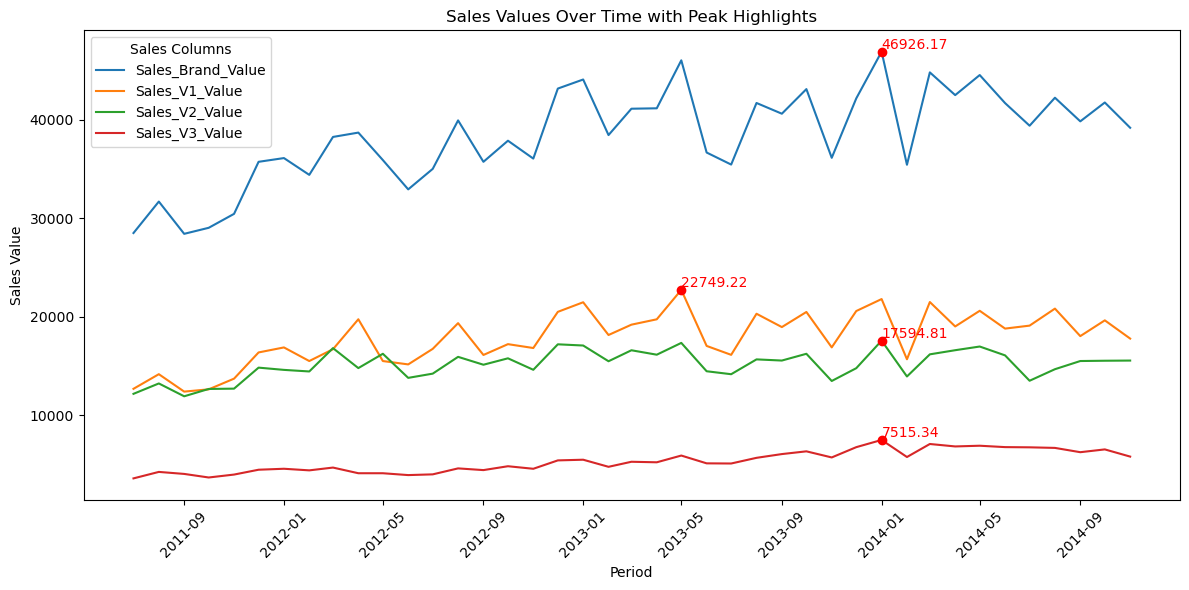

In [50]:

# Set the Period column as the index
sales_media_merged.set_index('Period', inplace=True)

# Select all columns that contain 'Sales' in their name 
sales_columns = [col for col in sales_media_merged.columns if 'Sales' in col]

# Plot each sales column over time
plt.figure(figsize=(12, 6))
for col in sales_columns:
    # Plot the entire sales data for the column
    plt.plot(sales_media_merged.index, sales_media_merged[col], label=col)
    
    # Find the index of the peak value in the column
    peak_index = sales_media_merged[col].idxmax()
    peak_value = sales_media_merged[col].max()
    
    # Highlight the peak value with a red marker
    plt.scatter(peak_index, peak_value, color='red', zorder=5)
    plt.text(peak_index, peak_value, f'{peak_value:.2f}', color='red', ha='left', va='bottom')

# Adding labels and title
plt.xlabel("Period")
plt.ylabel("Sales Value")
plt.title("Sales Values Over Time with Peak Highlights")
plt.legend(title="Sales Columns", loc="best")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Sales_Brand_Value has a peak value of 46926.17 in Jan 2014. <br>
Sales_V1_Value has a peak value of 22749.22 in May 2013. <br>
Sales_V2_Value has a peak value of 17594.81 in Jan 2014. <br>
Sales_V3_Value has a peak value of 7515.34 in Jan 2014.

## Trends in Media metrics over time

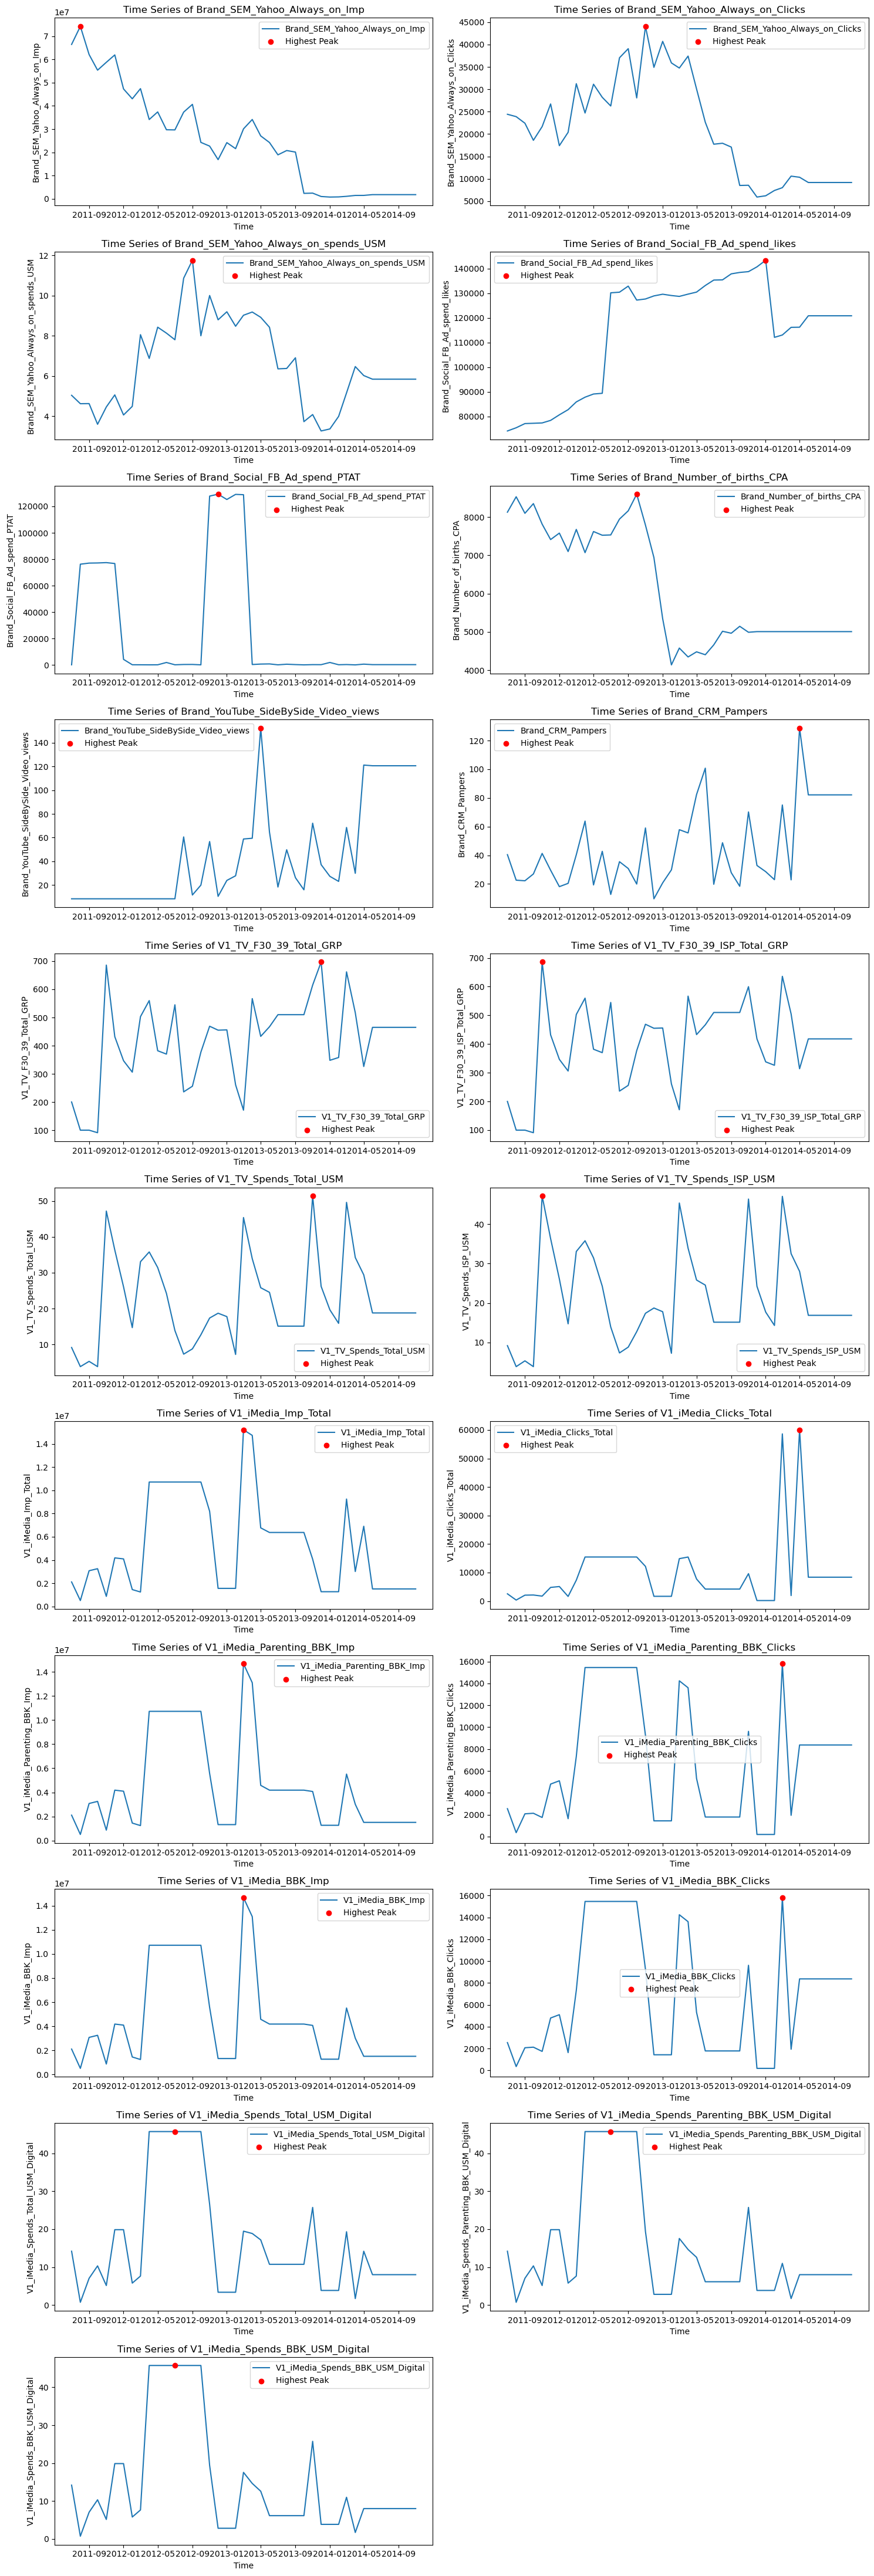

In [51]:


# List of variables
variables_list = ['Brand_SEM_Yahoo_Always_on_Imp', 'Brand_SEM_Yahoo_Always_on_Clicks',
                  'Brand_SEM_Yahoo_Always_on_spends_USM', 'Brand_Social_FB_Ad_spend_likes', 
                  'Brand_Social_FB_Ad_spend_PTAT', 'Brand_Number_of_births_CPA', 
                  'Brand_YouTube_SideBySide_Video_views', 'Brand_CRM_Pampers', 
                  'V1_TV_F30_39_Total_GRP', 'V1_TV_F30_39_ISP_Total_GRP', 
                  'V1_TV_Spends_Total_USM', 'V1_TV_Spends_ISP_USM', 
                  'V1_iMedia_Imp_Total', 'V1_iMedia_Clicks_Total', 
                  'V1_iMedia_Parenting_BBK_Imp', 'V1_iMedia_Parenting_BBK_Clicks', 
                  'V1_iMedia_BBK_Imp', 'V1_iMedia_BBK_Clicks', 
                  'V1_iMedia_Spends_Total_USM_Digital', 'V1_iMedia_Spends_Parenting_BBK_USM_Digital', 
                  'V1_iMedia_Spends_BBK_USM_Digital']

# Calculate number of rows and columns dynamically
n_vars = len(variables_list)
n_cols = 2
n_rows = math.ceil(n_vars / n_cols)

# Create subplots with dynamic grid size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

# Flatten axes array
axes = axes.flatten()

# Loop to plot
for i, var in enumerate(variables_list):
    ax = axes[i]
    
    # Plot the time series
    ax.plot(sales_media_merged.index, sales_media_merged[var], label=var)
    
    # Find peaks using scipy.signal.find_peaks
    peaks, _ = find_peaks(sales_media_merged[var])
    
    if len(peaks) > 0:
        # Find the index of the highest peak
        highest_peak_index = peaks[np.argmax(sales_media_merged[var].iloc[peaks])]
        
        # Mark the highest peak with a different color
        ax.scatter(sales_media_merged.index[highest_peak_index], sales_media_merged[var].iloc[highest_peak_index], 
                   color='red', label='Highest Peak', zorder=5)
    
    # Set title and labels
    ax.set_title(f'Time Series of {var}')
    ax.set_xlabel("Time")
    ax.set_ylabel(var)
    
    # Add a legend
    ax.legend()

# Hide any empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## Distribution Analysis

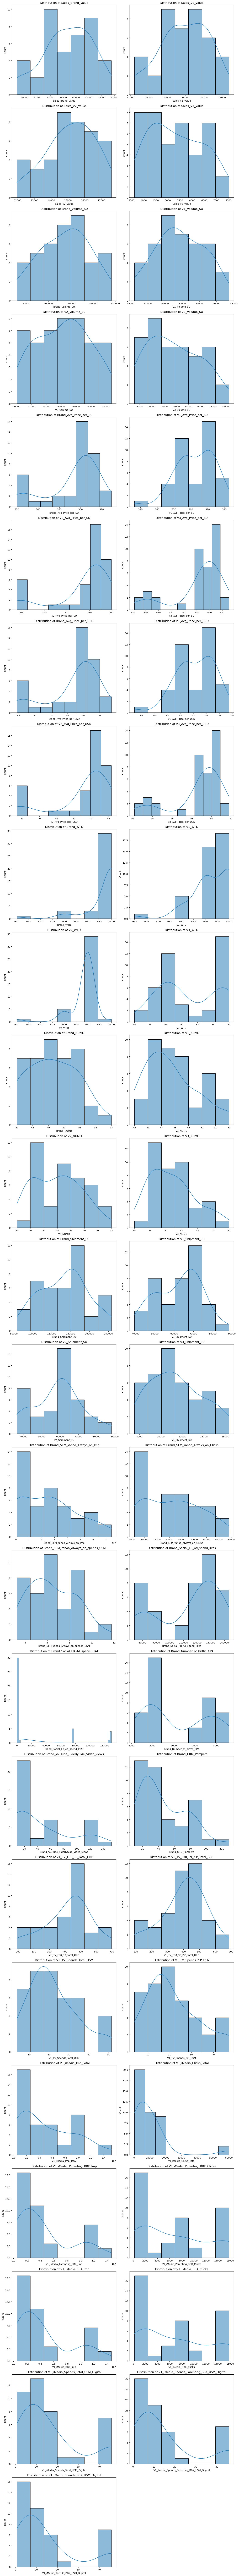

In [52]:

# Get all the columns in the DataFrame
all_columns = sales_media_merged.columns

# Set up the number of rows and columns for the subplots
num_vars = len(all_columns)
num_cols = 2  # 2 plots per row
num_rows = (num_vars // num_cols) + (num_vars % num_cols > 0)  

# Plot histograms for each column
plt.figure(figsize=(14, 6 * num_rows))  
for i, col in enumerate(all_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(sales_media_merged[col], kde=True)
    plt.title(f'Distribution of {col}')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


1) Sales_Brand_Value, Sales_V1_Value, Sales_V2_Value, Sales_V3_Value show a slightly right-skewed distribution indicating that while typical sales values fall within a specific range, there are occasional higher values that create the right skew.<br>
2) Brand_Volume_SU, V1_Volume_SU, V2_Volume_SU, and V3_Volume_SU are broadly spread with moderate skew. Some histograms appear slightly right-skewed, while others are more symmetrical. <br>
3) Shipment metrics also show a similar spread, suggesting that shipments correlate with demand cycles. <br>
4) Brand_Avg_Price_per_SU, V1_Avg_Price_per_SU, V2_Avg_Price_per_SU, V3_Avg_Price_per_SU are mostly symmetrical with minor skew, showing a central clustering around a mean.<br>
5) Brand_Social_FB_Ad_spend_likes, Brand_Social_FB_Ad_spend_PTAT, and Brand_SEM_Yahoo_Always_on_Clicks are right-skewed, with most values concentrated at the lower end and occasional higher peaks.<br>
6) V1_TV_F30_39_Total_GRP, V1_TV_F30_39_ISP_Total_GRP, and V1_TV_Spends_Total_USM are also right-skewed, with most ad spend values on the lower side and occasional peaks.<br>
7) Brand_WTD, V1_WTD, V2_WTD, and V3_WTD: some are slightly skewed, while others are more uniform.<br>
8) Brand_Number_of_births_CPA shows a right-skewed distribution, with a few high values.<br>
9) Brand_YouTube_SideBySide_Video_views and Brand_CRM_Pampers show right-skewed distributions, with occasional high-engagement instances.

## Heat Map

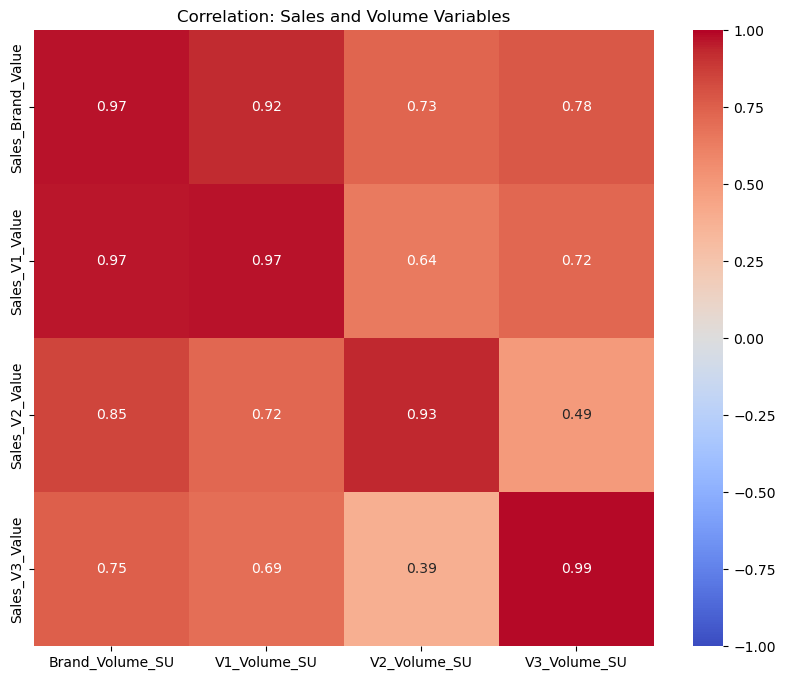

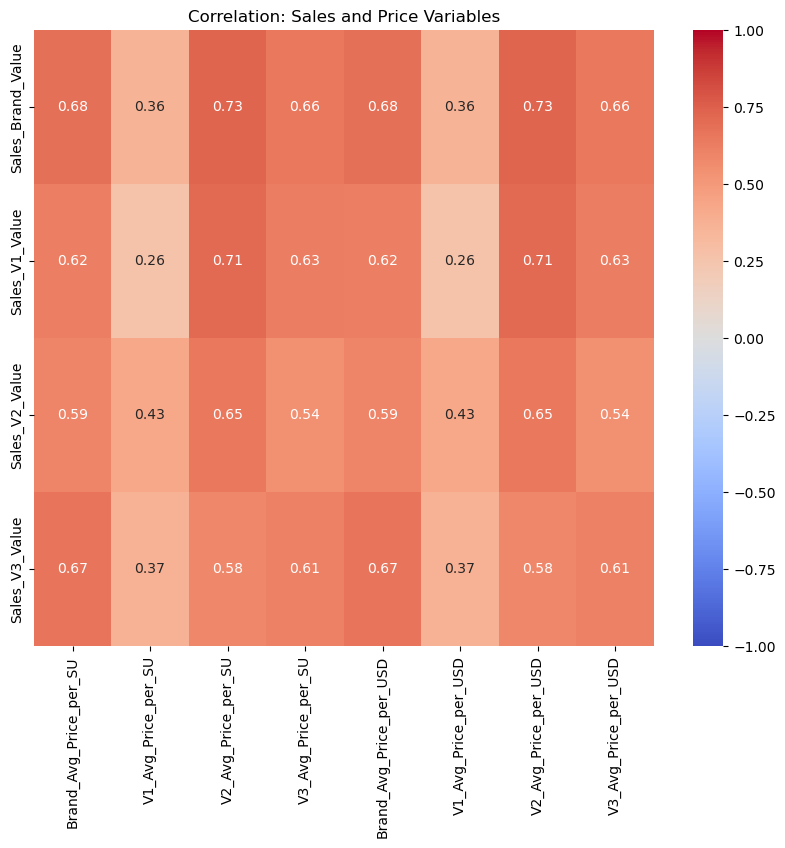

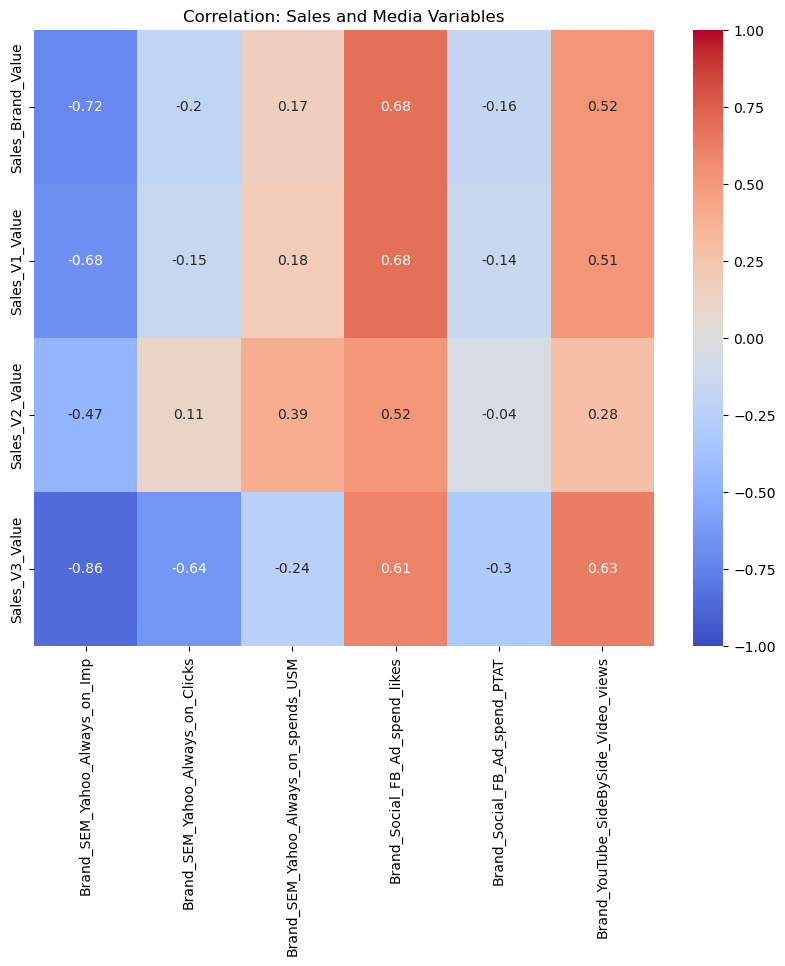

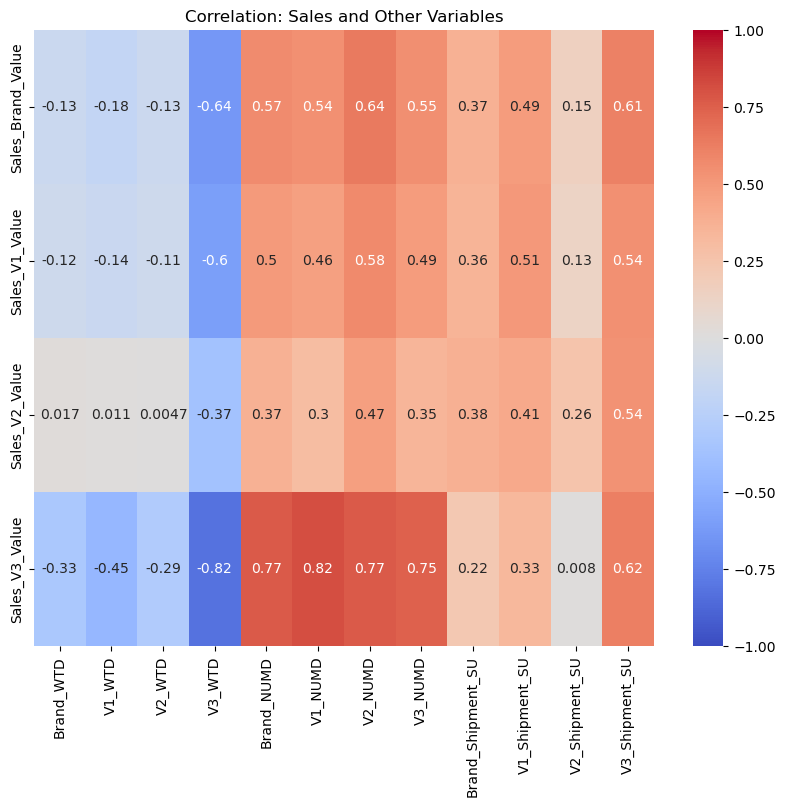

In [53]:

# Define groups of variables
dependent_vars = ['Sales_Brand_Value', 'Sales_V1_Value', 'Sales_V2_Value', 'Sales_V3_Value']

volume_vars = ['Brand_Volume_SU', 'V1_Volume_SU', 'V2_Volume_SU', 'V3_Volume_SU']
price_vars = ['Brand_Avg_Price_per_SU', 'V1_Avg_Price_per_SU', 'V2_Avg_Price_per_SU', 'V3_Avg_Price_per_SU',
              'Brand_Avg_Price_per_USD', 'V1_Avg_Price_per_USD', 'V2_Avg_Price_per_USD', 'V3_Avg_Price_per_USD']
media_vars = ['Brand_SEM_Yahoo_Always_on_Imp', 'Brand_SEM_Yahoo_Always_on_Clicks', 
              'Brand_SEM_Yahoo_Always_on_spends_USM', 'Brand_Social_FB_Ad_spend_likes', 
              'Brand_Social_FB_Ad_spend_PTAT', 'Brand_YouTube_SideBySide_Video_views']
other_vars = ['Brand_WTD', 'V1_WTD', 'V2_WTD', 'V3_WTD', 'Brand_NUMD', 'V1_NUMD', 
              'V2_NUMD', 'V3_NUMD', 'Brand_Shipment_SU', 'V1_Shipment_SU', 
              'V2_Shipment_SU', 'V3_Shipment_SU']

# Define a function to plot a heatmap for a given set of variables
def plot_heatmap(sales_media_merged, dependent_vars, independent_vars, title):
    plt.figure(figsize=(10, 8))
    selected_vars = dependent_vars + independent_vars
    corr_matrix = sales_media_merged[selected_vars].corr()
    sns.heatmap(corr_matrix.loc[dependent_vars, independent_vars], annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

# Plot heatmaps for each group of independent variables
plot_heatmap(sales_media_merged, dependent_vars, volume_vars, "Correlation: Sales and Volume Variables")
plot_heatmap(sales_media_merged, dependent_vars, price_vars, "Correlation: Sales and Price Variables")
plot_heatmap(sales_media_merged, dependent_vars, media_vars, "Correlation: Sales and Media Variables")
plot_heatmap(sales_media_merged, dependent_vars, other_vars, "Correlation: Sales and Other Variables")


- As Sales = Volume * Price, the sales variable and Volume variable have high positive correlation.<br>
- Sales and Price variables also have weak positive correlation. <br>
- Sales_V3_Value and Brand_SEM_Yahoo_Always_on_Imp have strong negative correlation.<br>
- Sales_V3_Value and V3_NUMD have positive correlation. <br>


## Boxplots of Sales Metrics

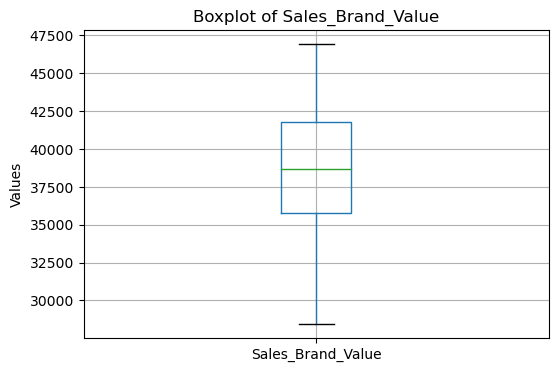

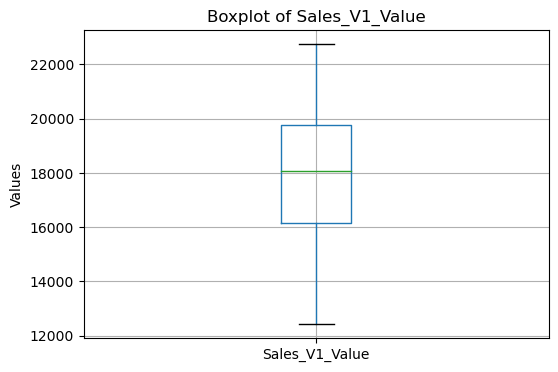

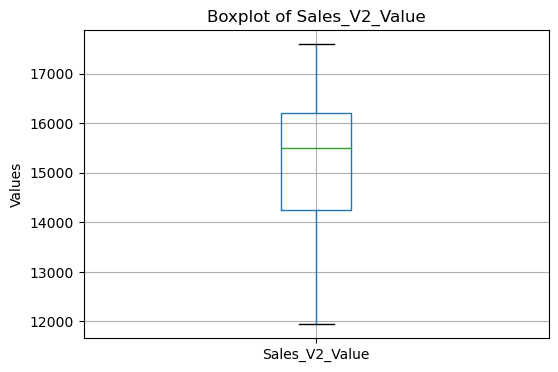

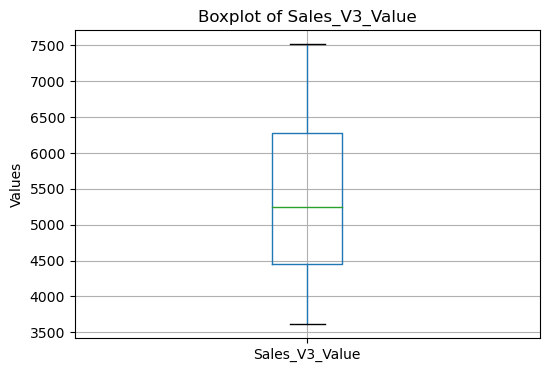

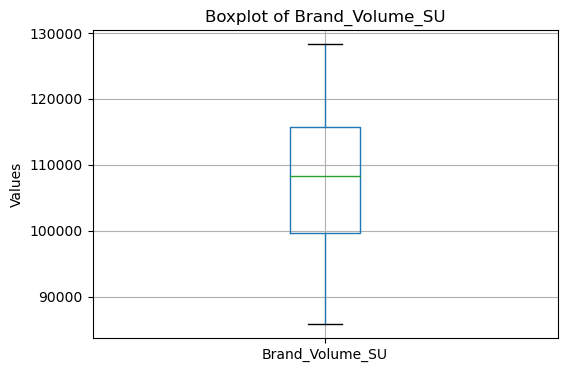

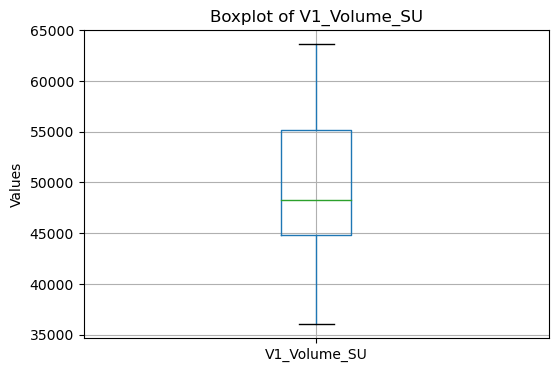

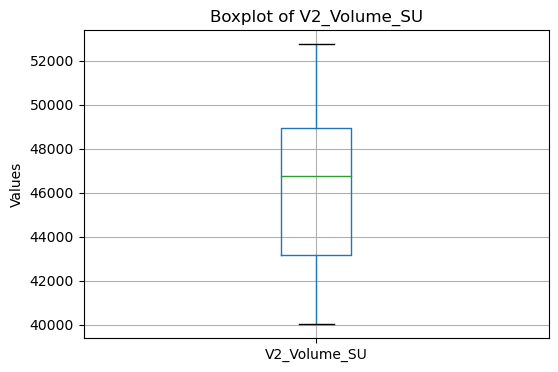

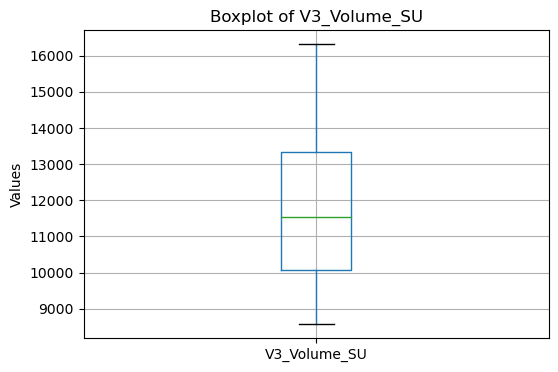

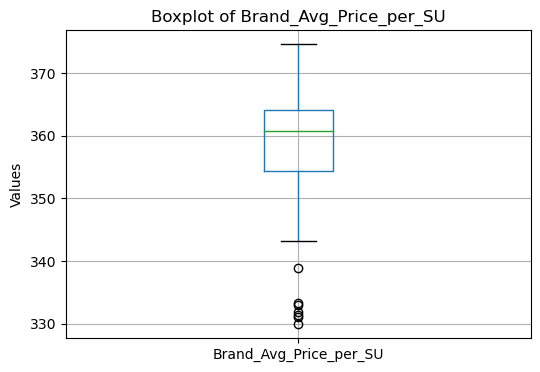

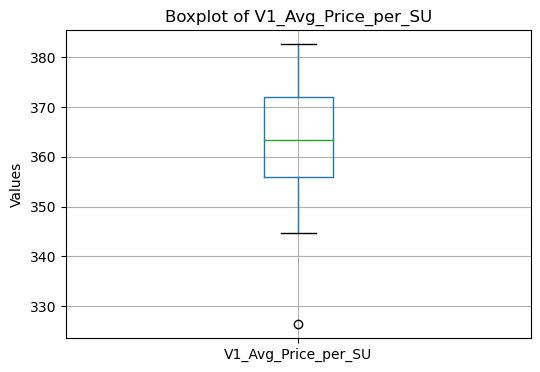

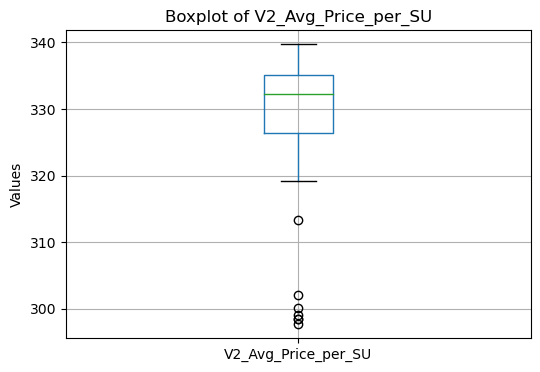

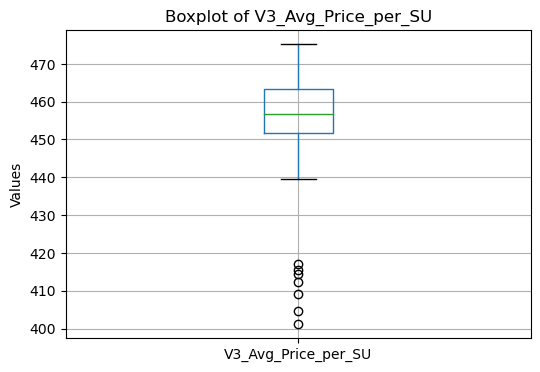

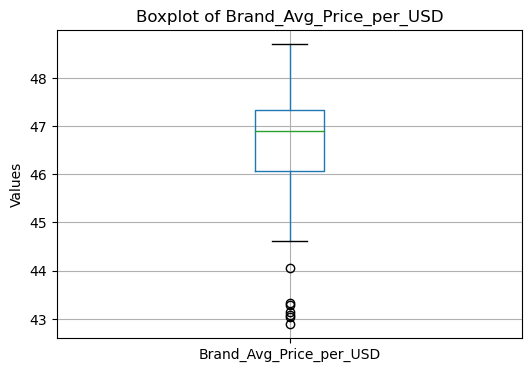

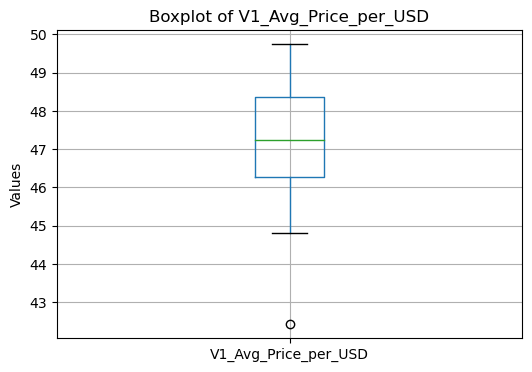

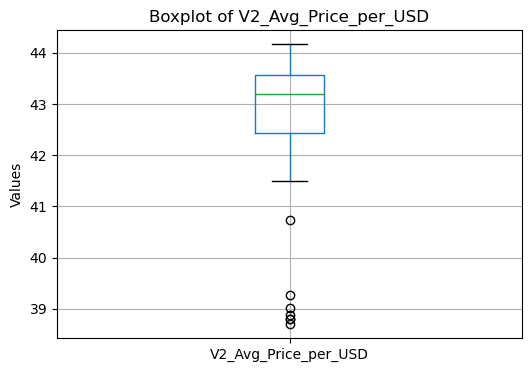

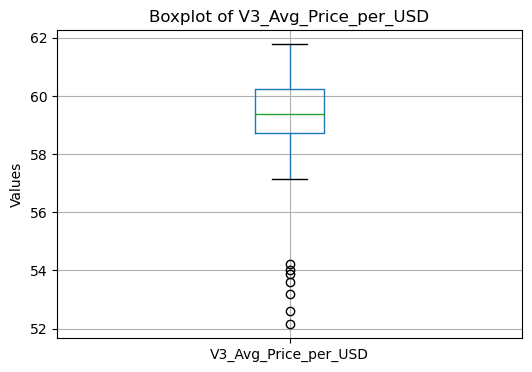

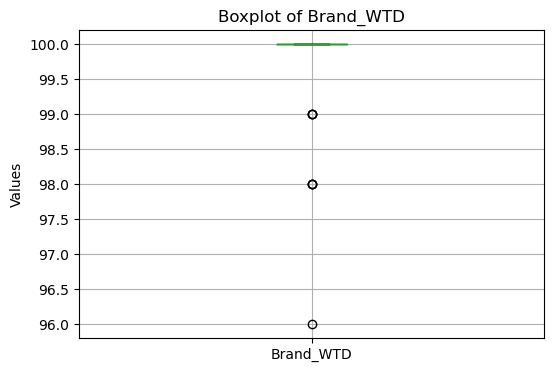

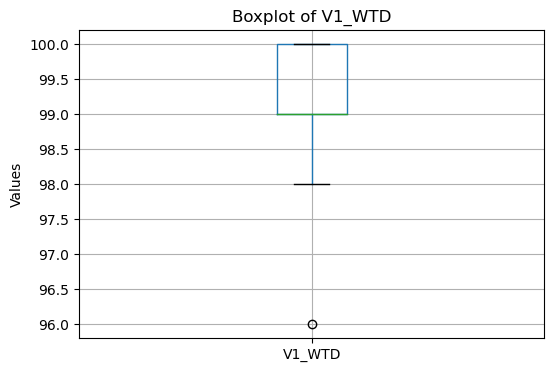

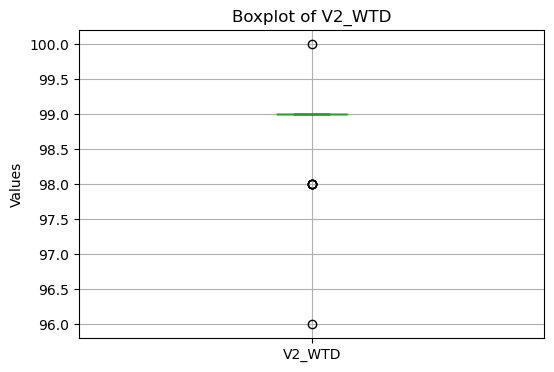

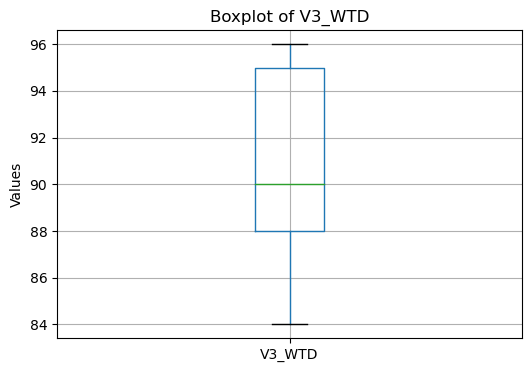

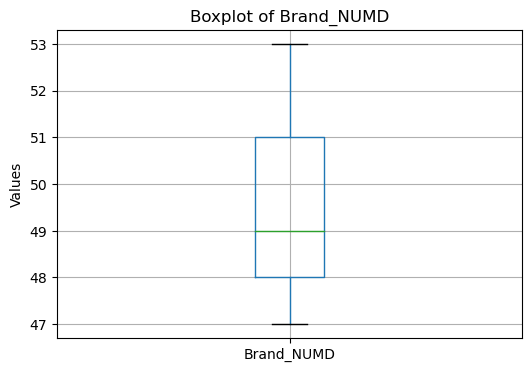

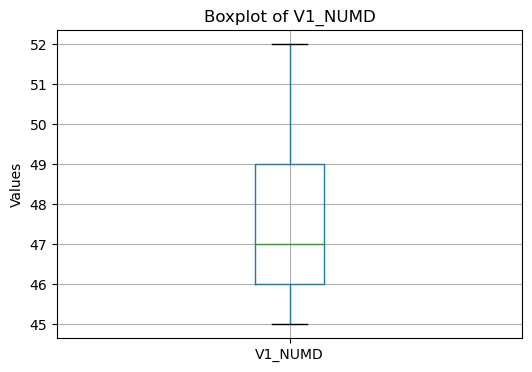

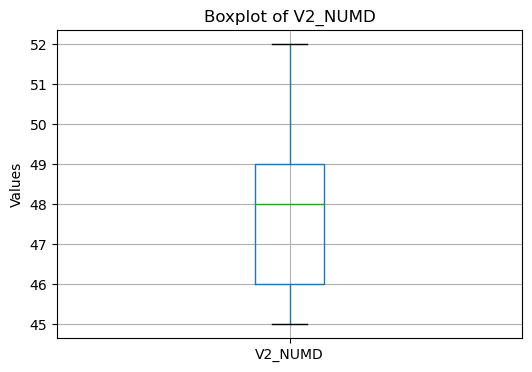

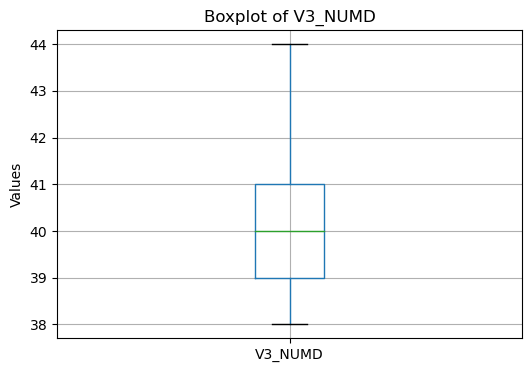

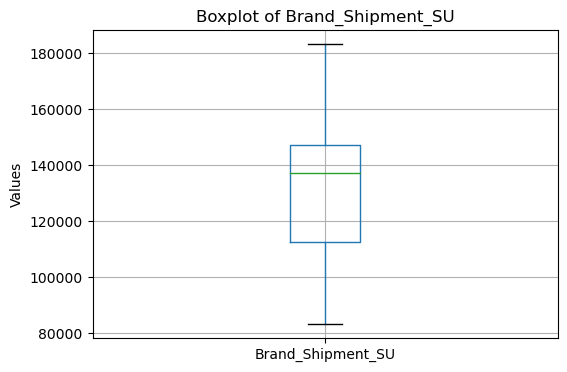

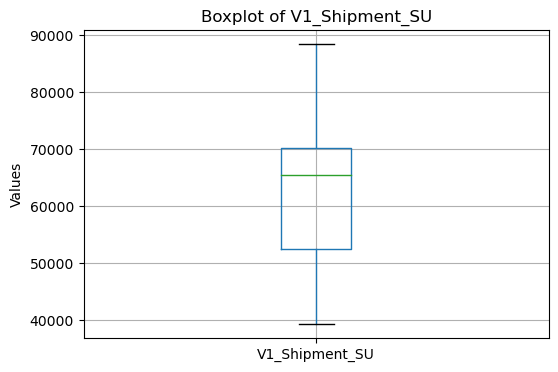

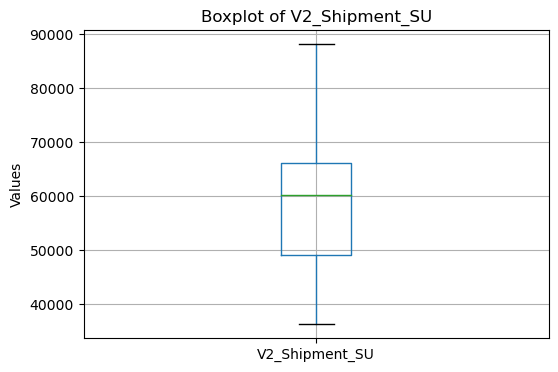

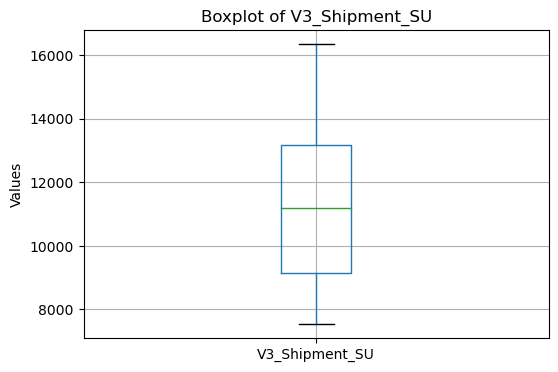

In [54]:
sales_columns = ['Sales_Brand_Value', 'Sales_V1_Value', 'Sales_V2_Value',
       'Sales_V3_Value', 'Brand_Volume_SU', 'V1_Volume_SU', 'V2_Volume_SU',
       'V3_Volume_SU', 'Brand_Avg_Price_per_SU', 'V1_Avg_Price_per_SU',
       'V2_Avg_Price_per_SU', 'V3_Avg_Price_per_SU', 'Brand_Avg_Price_per_USD',
       'V1_Avg_Price_per_USD', 'V2_Avg_Price_per_USD', 'V3_Avg_Price_per_USD',
       'Brand_WTD', 'V1_WTD', 'V2_WTD', 'V3_WTD', 'Brand_NUMD', 'V1_NUMD',
       'V2_NUMD', 'V3_NUMD', 'Brand_Shipment_SU', 'V1_Shipment_SU',
       'V2_Shipment_SU', 'V3_Shipment_SU']  

# Loop through each column and create a separate boxplot
for col in sales_columns:
    plt.figure(figsize=(6, 4))  # Set the size for each individual plot
    sales_media_merged.boxplot(column=col)
    plt.title(f"Boxplot of {col}")
    plt.ylabel("Values")
    plt.show()

Variables like Brand_Avg_Price_per_SU, V1_Avg_Price_per_SU, V2_Avg_Price_per_SU, V3_Avg_Price_per_SU, Brand_Avg_Price_per_USD, V1_Avg_Price_per_USD, V2_Avg_Price_per_USD, V3_Avg_Price_per_USD, Brand_WTD, V1_WTD, V2_WTD have outliers.

## Correlation Between Sales Brand Metrics and Media Brand Engagement Variables

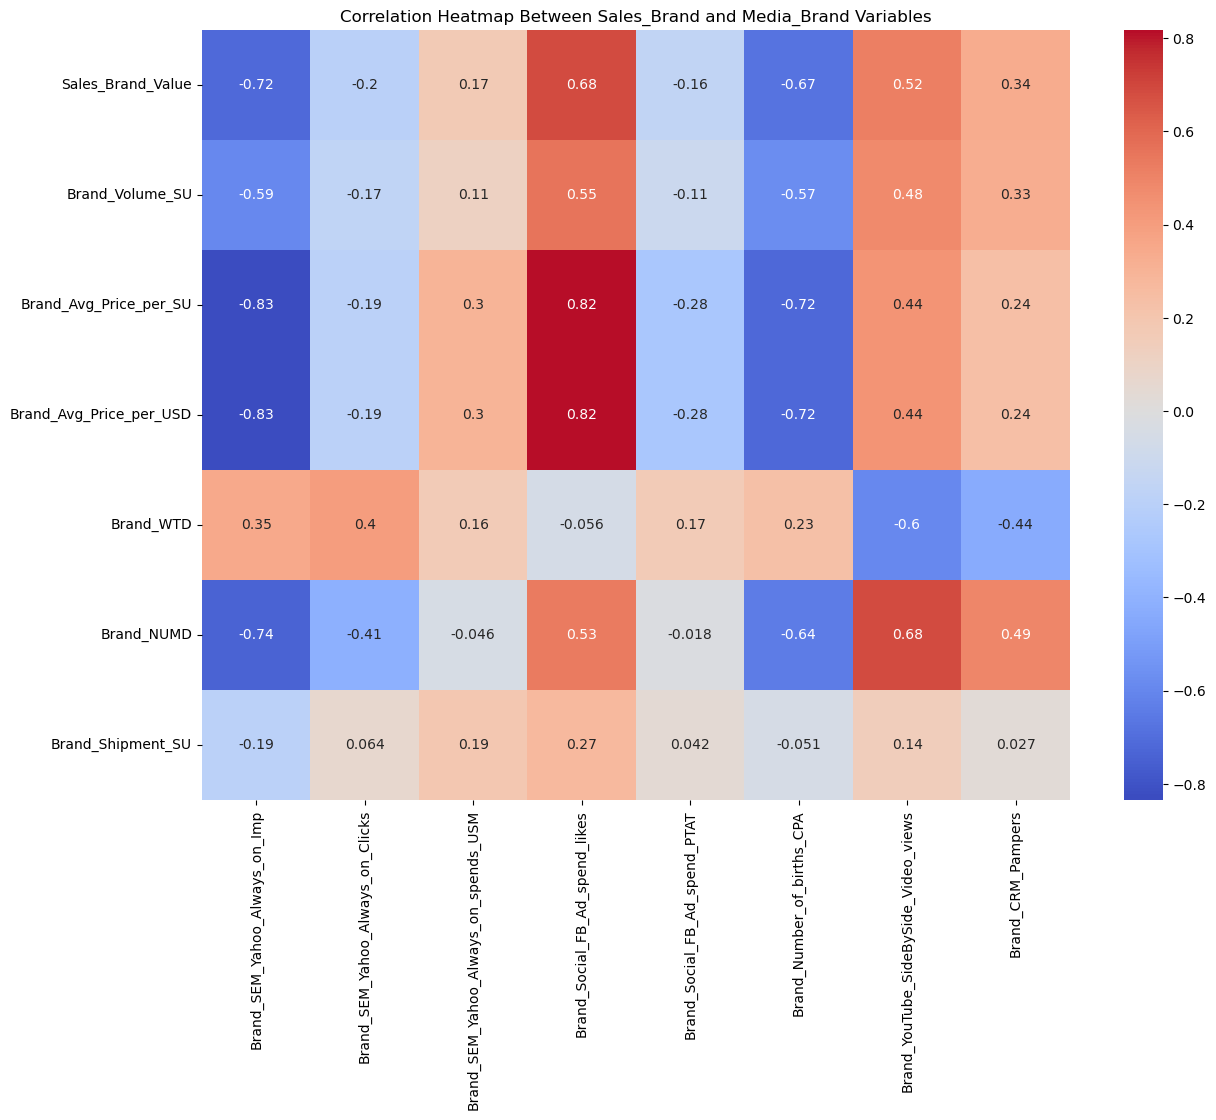

In [55]:
sales_brand_vars = ['Sales_Brand_Value', 'Brand_Volume_SU', 'Brand_Avg_Price_per_SU', 'Brand_Avg_Price_per_USD',
       'Brand_WTD', 'Brand_NUMD', 'Brand_Shipment_SU']
media_brand_vars = ['Brand_SEM_Yahoo_Always_on_Imp',
       'Brand_SEM_Yahoo_Always_on_Clicks',
       'Brand_SEM_Yahoo_Always_on_spends_USM',
       'Brand_Social_FB_Ad_spend_likes', 'Brand_Social_FB_Ad_spend_PTAT',
       'Brand_Number_of_births_CPA', 'Brand_YouTube_SideBySide_Video_views',
       'Brand_CRM_Pampers']
# Compute correlation between dependent and independent variables
correlation_matrix = sales_media_merged[sales_brand_vars + media_brand_vars].corr()

# Filter correlation matrix to show only correlations between dependent and independent variables
corr_subset = correlation_matrix.loc[sales_brand_vars, media_brand_vars]

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap Between Sales_Brand and Media_Brand Variables")
plt.show()

1) Social media metrics like FB_Ad_spend_likes moderately correlate with Sales_Brand_Value and Brand_WTD, suggesting that social media engagement can positively influence brand sales and distribution.<br>
2) Brand_Avg_Price_per_SU and Brand_Avg_Price_per_USD have a strong negative correlation with Brand_SEM_Yahoo_Always_on_Imp and Clicks, indicating lower prices may be associated with higher SEM activity.

## Correlation Between Sales V1 Metrics and Media V1 Engagement Variables

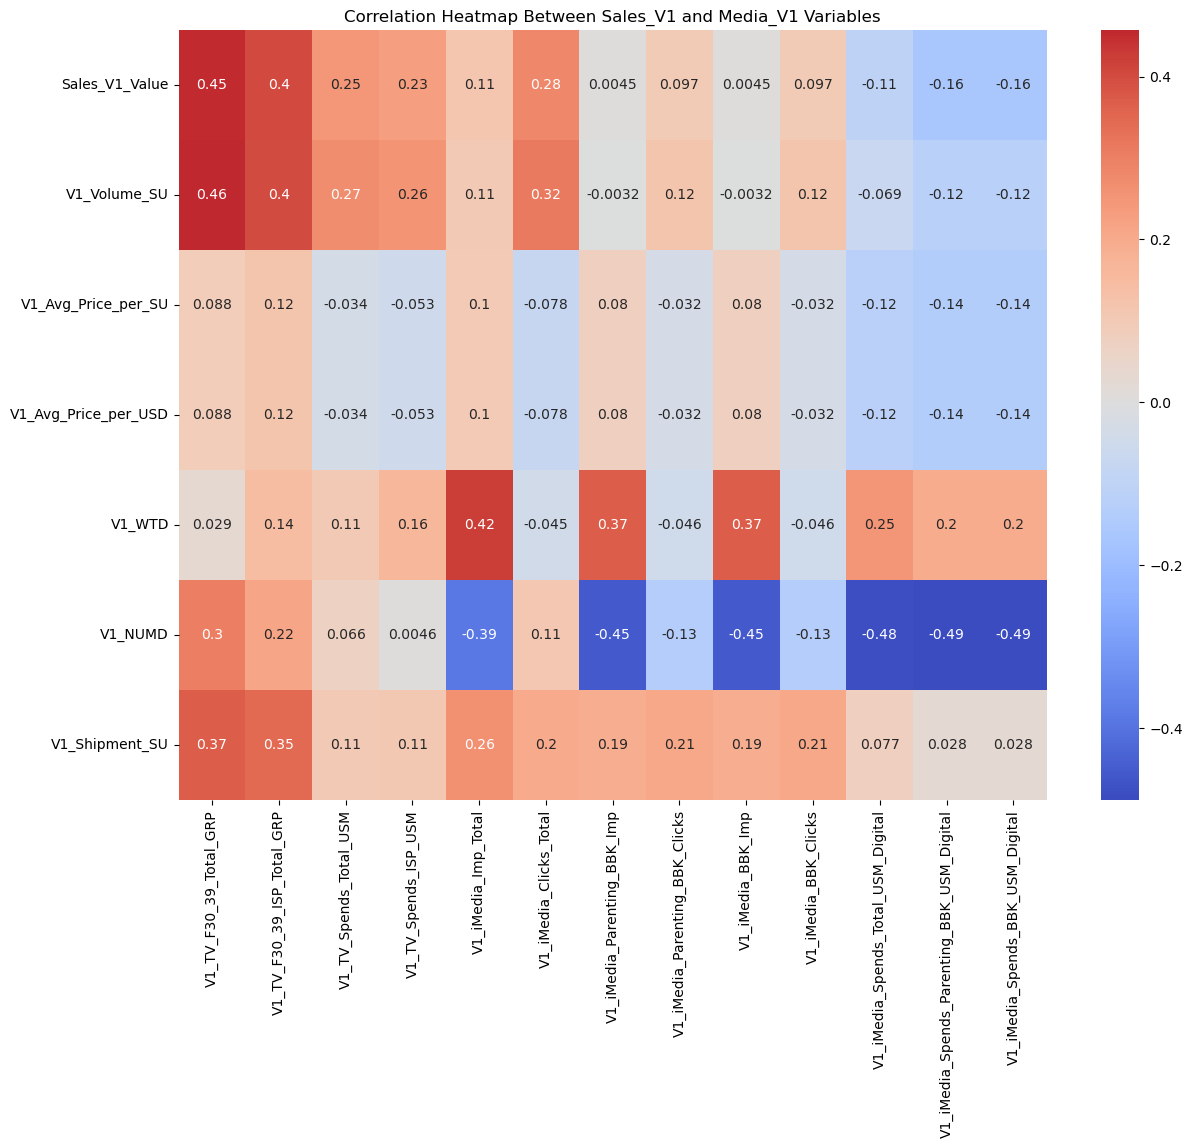

In [56]:
sales_v1_vars = ['Sales_V1_Value', 'V1_Volume_SU', 'V1_Avg_Price_per_SU', 'V1_Avg_Price_per_USD',
       'V1_WTD', 'V1_NUMD', 'V1_Shipment_SU']
media_v1_vars = ['V1_TV_F30_39_Total_GRP',
       'V1_TV_F30_39_ISP_Total_GRP', 'V1_TV_Spends_Total_USM',
       'V1_TV_Spends_ISP_USM', 'V1_iMedia_Imp_Total', 'V1_iMedia_Clicks_Total',
       'V1_iMedia_Parenting_BBK_Imp', 'V1_iMedia_Parenting_BBK_Clicks',
       'V1_iMedia_BBK_Imp', 'V1_iMedia_BBK_Clicks',
       'V1_iMedia_Spends_Total_USM_Digital',
       'V1_iMedia_Spends_Parenting_BBK_USM_Digital',
       'V1_iMedia_Spends_BBK_USM_Digital']
# Compute correlation between dependent and independent variables
correlation_matrix = sales_media_merged[sales_v1_vars + media_v1_vars].corr()

# Filter correlation matrix to show only correlations between dependent and independent variables
corr_subset = correlation_matrix.loc[sales_v1_vars, media_v1_vars]

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap Between Sales_V1 and Media_V1 Variables")
plt.show()

1) V1_Volume_SU has a weak-to-moderate positive correlation with various media metrics like V1_iMedia_Imp_Total and V1_iMedia_Clicks_Total, indicating a potential relationship where higher impressions and clicks may slightly boost product volume.<br>
2) V1_NUMD (distribution metric) also correlates positively with media metrics, implying that greater media exposure could be associated with broader product distribution.

## Sales VS Price with respect to Period

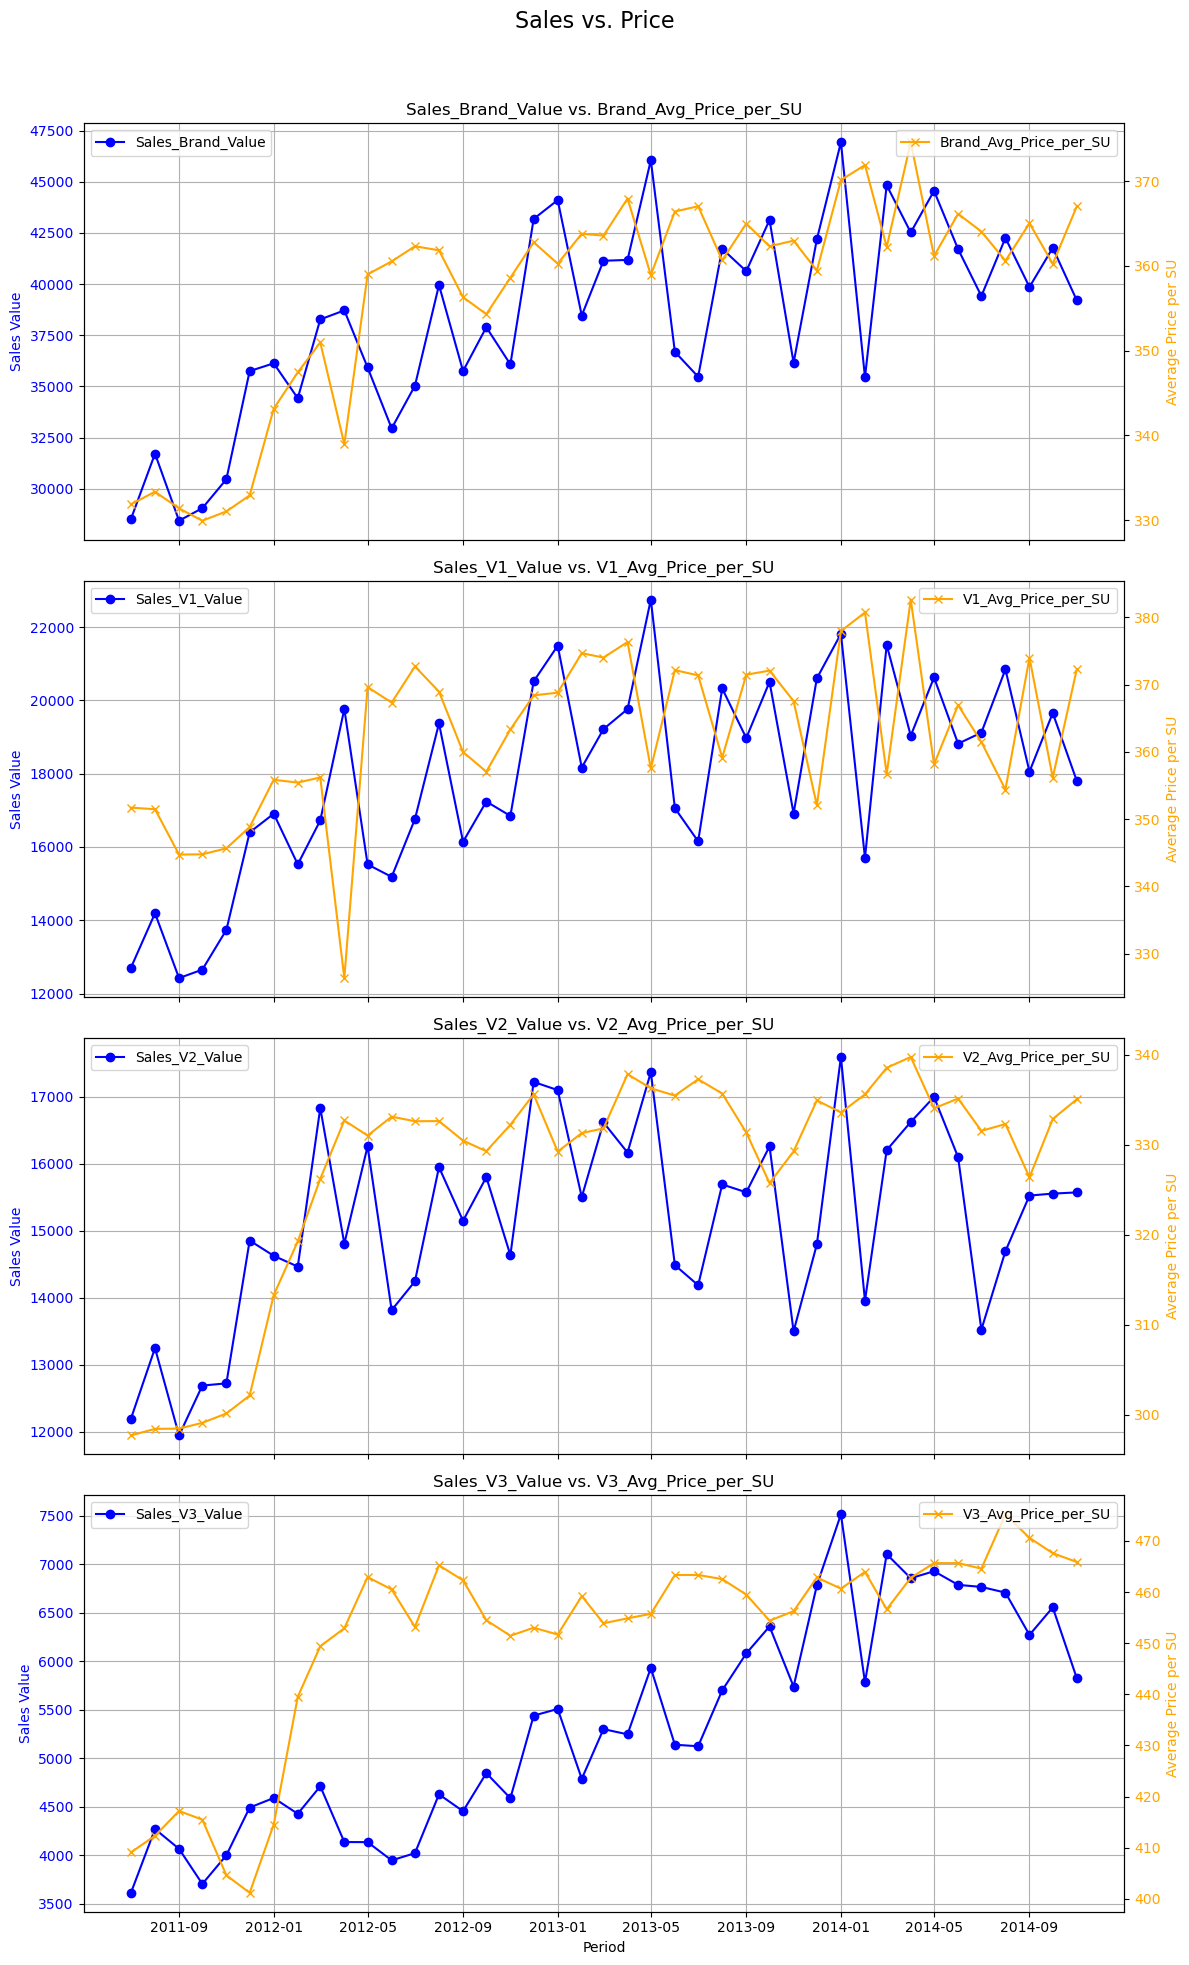

In [57]:

# Ensure the index is in datetime format
sales_media_merged.index = pd.to_datetime(sales_media_merged.index)

# Define pairs of sales and price columns
sales_columns = ['Sales_Brand_Value', 'Sales_V1_Value', 'Sales_V2_Value', 'Sales_V3_Value']
price_columns = ['Brand_Avg_Price_per_SU', 'V1_Avg_Price_per_SU', 'V2_Avg_Price_per_SU', 'V3_Avg_Price_per_SU']

# Set up a subplot grid with one row per sales-price pair
fig, axs = plt.subplots(len(sales_columns), 1, figsize=(12, 20), sharex=True)
fig.suptitle('Sales vs. Price', fontsize=16)

# Plot each sales vs. price pair with a secondary y-axis for the price data
for i, (sales, price) in enumerate(zip(sales_columns, price_columns)):
    # Plot sales data on the primary y-axis
    ax1 = axs[i]
    ax1.plot(sales_media_merged.index, sales_media_merged[sales], label=sales, color='blue', marker='o')
    ax1.set_ylabel('Sales Value', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    # Plot price data on the secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(sales_media_merged.index, sales_media_merged[price], label=price, color='orange', marker='x')
    ax2.set_ylabel('Average Price per SU', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Title and legend
    ax1.set_title(f'{sales} vs. {price}')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Period')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()


1) Brand:

- The strong growth in sales without significant price increases suggests that this brand’s sales volume (units sold) increased over time, indicating a possible increase in demand

2) V1:

- Sales_V1_Value shows significant variability with peaks and valleys but also an upward trend over the entire period.
- The Average Price per SU (V1_Avg_Price_per_SU) fluctuates within a similar range, indicating stable pricing.

3) V2:

- The Average Price per SU for V2 (V2_Avg_Price_per_SU) is in the lower range, which is lower than the prices for Brand and V1.
- The lower price point combined with similar sales trends suggests that V2 might be positioned as a more affordable or budget-friendly option, which could help it maintain steady sales.

4) V3:

- The Average Price per SU (V3_Avg_Price_per_SU) is consistently in the higher range (around 430–470), indicating this might be a premium product.
- Despite a higher price, sales for V3 increase over time, indicating strong demand for a premium offering.

## Regression Plot of Sales VS Price

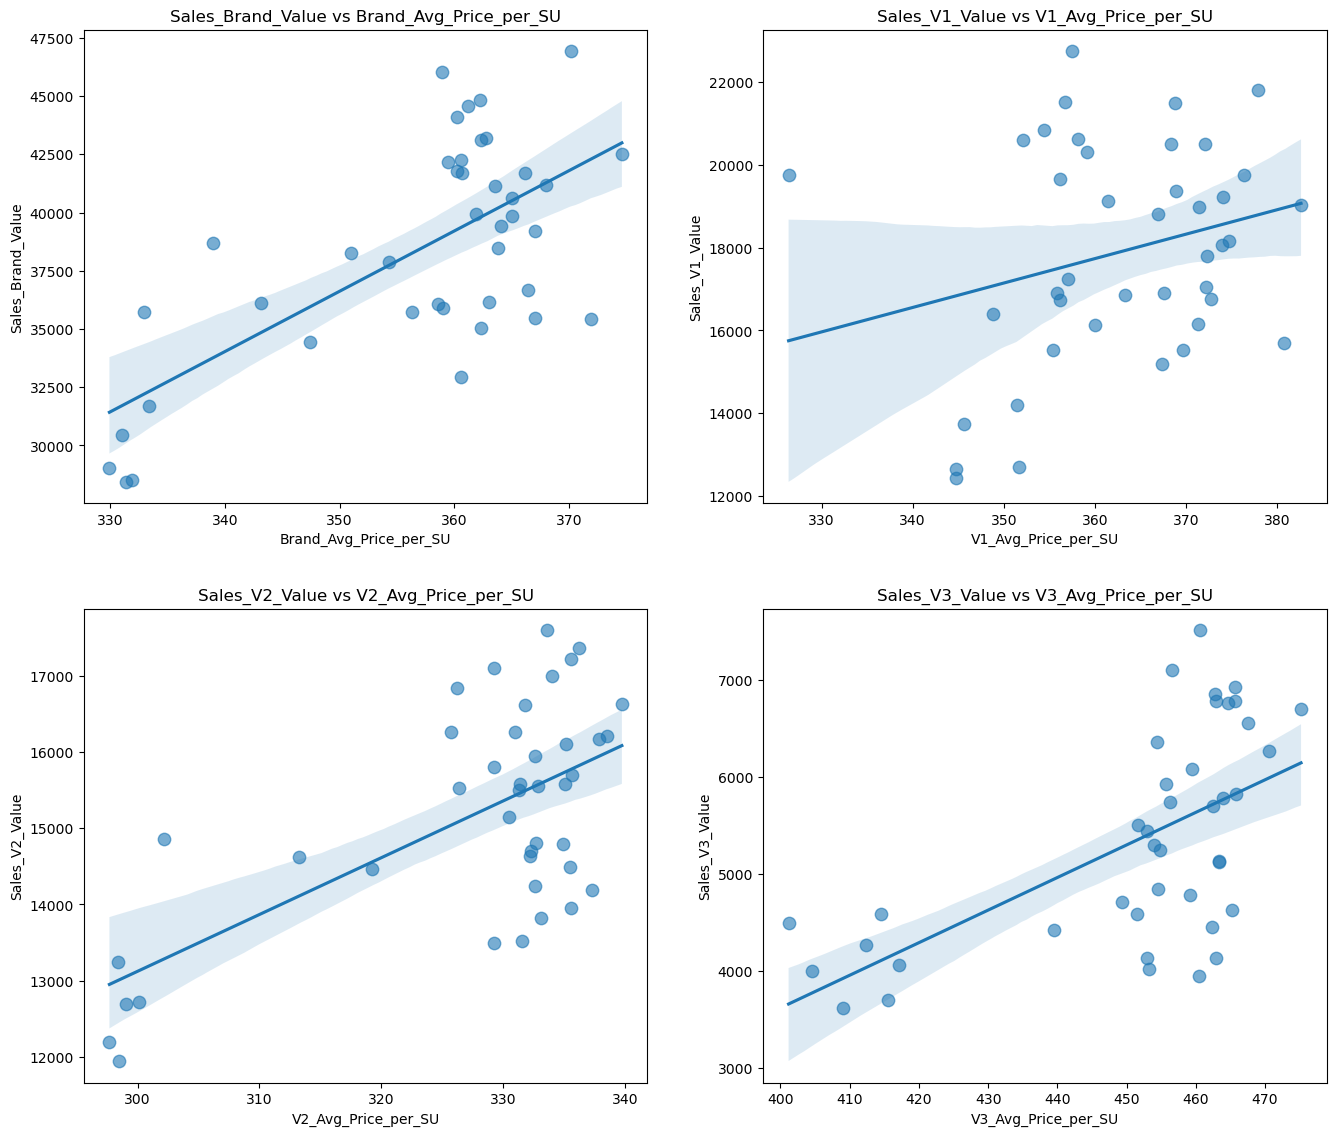

In [58]:

# Define corresponding pairs of price and sales variables
price_vars = ['Brand_Avg_Price_per_SU', 'V1_Avg_Price_per_SU', 'V2_Avg_Price_per_SU', 'V3_Avg_Price_per_SU']
sales_vars = ['Sales_Brand_Value', 'Sales_V1_Value', 'Sales_V2_Value', 'Sales_V3_Value']

# Set up the figure with 2 rows and 2 columns (for 4 pairs)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Loop over each pair and create a regression plot
for i, (price, sales) in enumerate(zip(price_vars, sales_vars)):
    ax = axes[i // 2, i % 2]  # Get the correct subplot axis
    sns.regplot(data=sales_media_merged, x=price, y=sales, ax=ax, scatter_kws={'s': 80, 'alpha': 0.6})
    ax.set_title(f'{sales} vs {price}', fontsize=12)
    ax.set_xlabel(price, fontsize=10)
    ax.set_ylabel(sales, fontsize=10)

# Adjust layout for readability
plt.tight_layout(pad=3.0)
plt.show()


- Positive Correlation: There is a noticeable positive correlation between Brand_Avg_Price_per_SU and Sales_Brand_Value. As the average price per unit for the brand increases, the total sales value also tends to increase.
- Slight Positive Correlation: There is a slight positive correlation between V1_Avg_Price_per_SU and Sales_V1_Value. However, the trend is not as strong as in the Brand plot, as data points are more scattered.
- Moderate Positive Correlation: There is a moderately positive correlation between V2_Avg_Price_per_SU and Sales_V2_Value. As the average price per unit for V2 increases, the sales value also tends to increase, though the trend is not very strong.
- Strong Positive Correlation: There is a strong positive correlation between V3_Avg_Price_per_SU and Sales_V3_Value. As the average price per unit increases, the sales value for V3 also significantly increases.

## Regression plot of Sales Brand Variables and Media Brand Variables

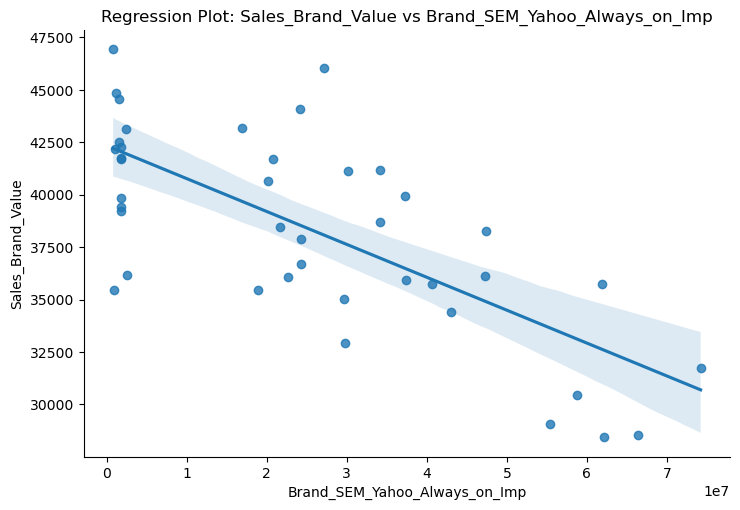

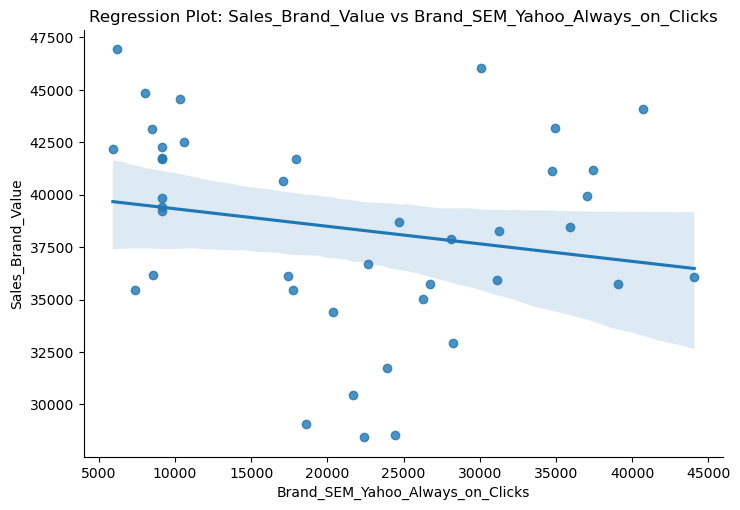

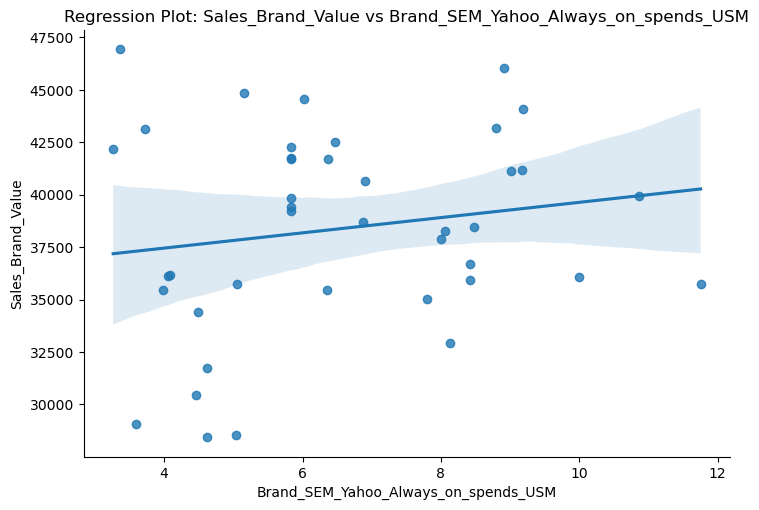

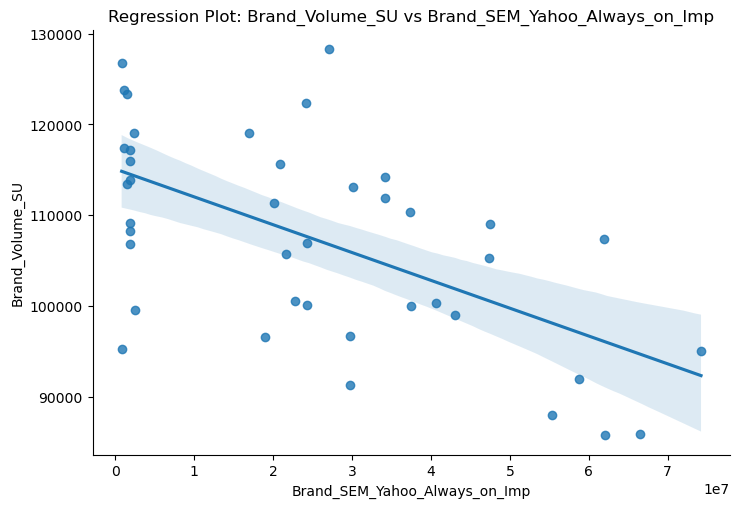

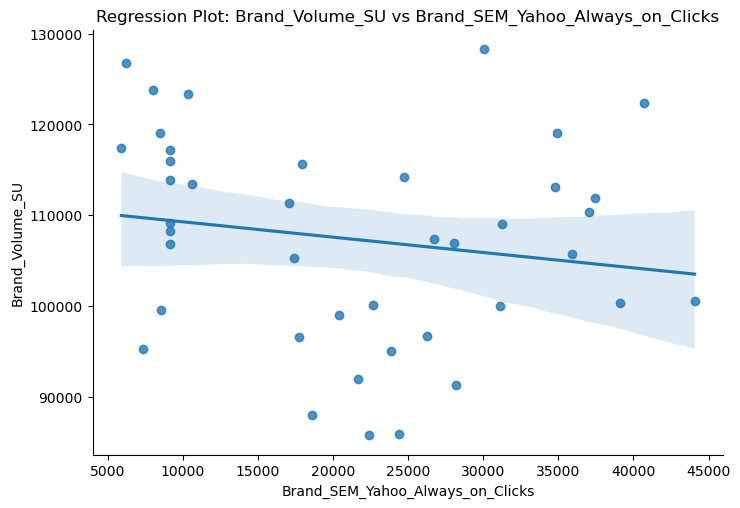

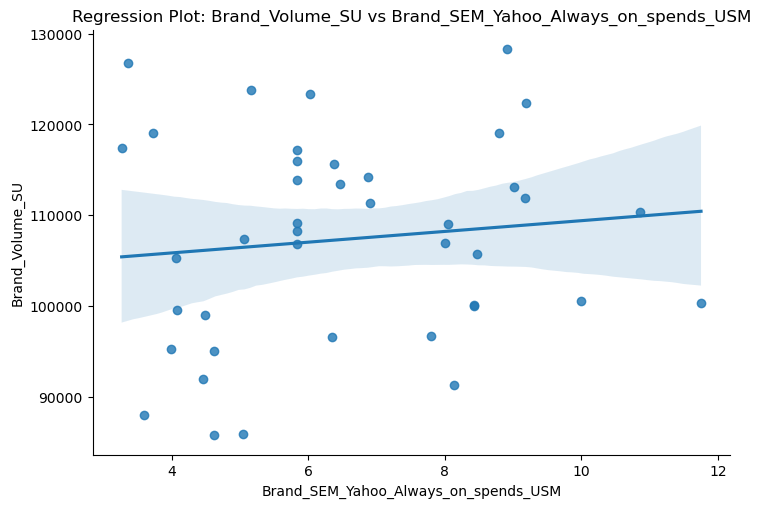

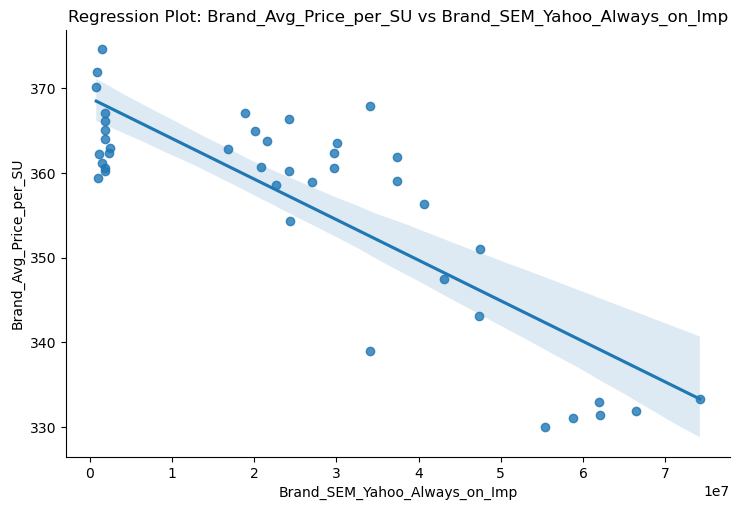

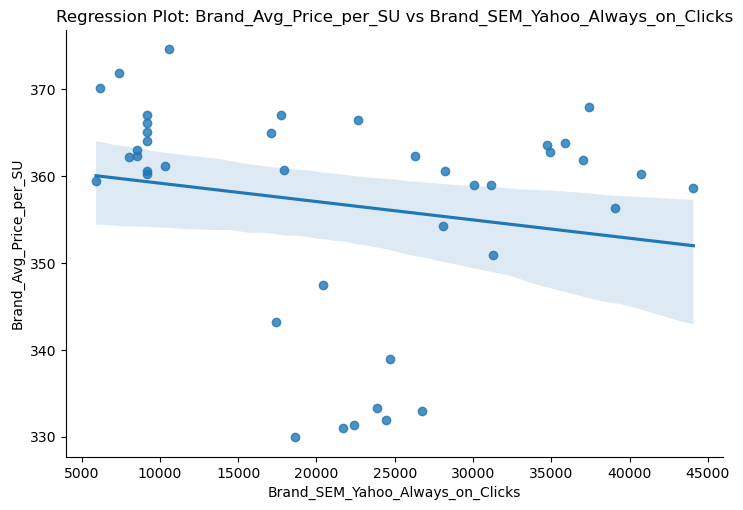

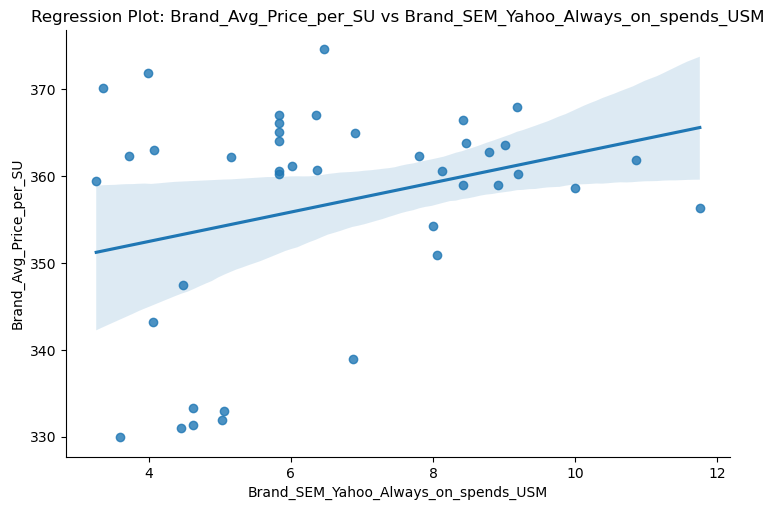

In [59]:
# Plot regression lines
for sales_var in sales_brand_vars[:3]:  
    for media_var in media_brand_vars[:3]: 
        sns.lmplot(x=media_var, y=sales_var, data=sales_media_merged, aspect=1.5)
        plt.title(f"Regression Plot: {sales_var} vs {media_var}")
        plt.show()

- There is a clear negative correlation between Brand_Avg_Price_per_SU (average price per unit sold) and Brand_SEM_Yahoo_Always_on_Imp (impressions from Yahoo search engine marketing). As Brand_SEM_Yahoo_Always_on_Imp increases, Brand_Avg_Price_per_SU tends to decrease.
- There is a positive correlation between Brand_Avg_Price_per_SU and Brand_SEM_Yahoo_Always_on_Spends_USM. As Brand_SEM_Yahoo_Always_on_Spends_USM increases, Brand_Avg_Price_per_SU increases.
- There is a clear negative correlation between Sales_Brand_Value and Brand_SEM_Yahoo_Always_on_Imp. As Brand_SEM_Yahoo_Always_on_Imp increases, Sales_Brand_Value tends to decrease.
- Nearly horizontal regression line between Brand_SEM_Yahoo_Always_on_spends_USM and Sales_Brand_Value suggests a weak or minimal positive relationship between them.


## Month-wise trend of Brand Average Price per SU

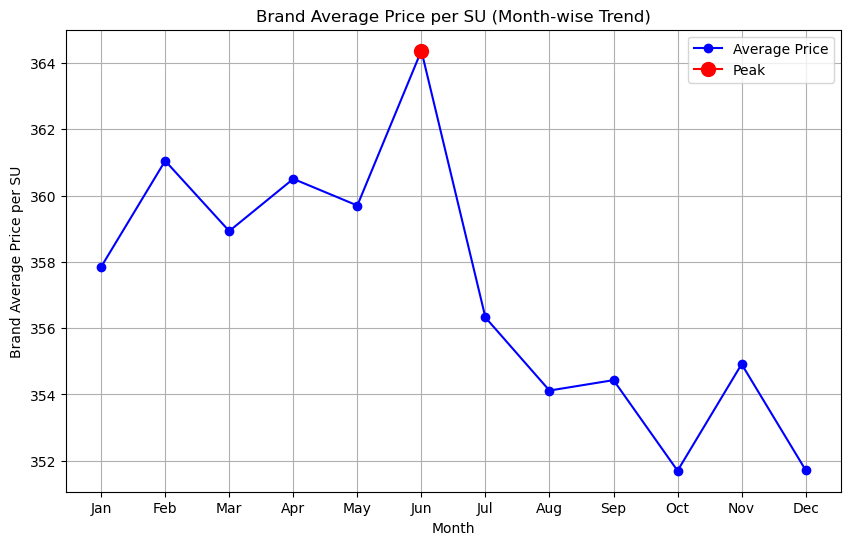

In [60]:

# Ensure the index is in datetime format
sales_media_merged.index = pd.to_datetime(sales_media_merged.index)

# Extract month from the datetime index
sales_media_merged['Month'] = sales_media_merged.index.month

# Calculate the average price per month across all years
monthly_avg_price = sales_media_merged.groupby('Month')['Brand_Avg_Price_per_SU'].mean()

# Find the peak element (maximum value)
peak_month = monthly_avg_price.idxmax()
peak_value = monthly_avg_price.max()

# Plot the month-wise average price trend
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_price.index, monthly_avg_price.values, marker='o', linestyle='-', color='b', label='Average Price')
plt.plot(peak_month, peak_value, marker='o', color='r', markersize=10, label='Peak')  # Mark the peak point

# Adding labels, title, and grid
plt.title('Brand Average Price per SU (Month-wise Trend)')
plt.xlabel('Month')
plt.ylabel('Brand Average Price per SU')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)

# Show legend
plt.legend()

plt.show()


The Brand Average Price per SU is the highest in June

## Month-wise trend of V1 Average Price per SU

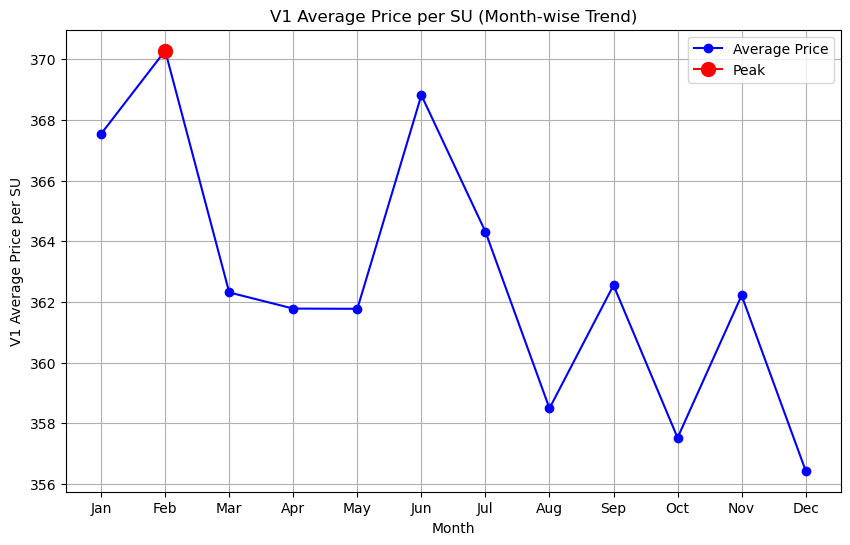

In [61]:

# Ensure the index is in datetime format
sales_media_merged.index = pd.to_datetime(sales_media_merged.index)

# Extract month from the datetime index
sales_media_merged['Month'] = sales_media_merged.index.month

# Calculate the average price per month across all years
monthly_avg_price = sales_media_merged.groupby('Month')['V1_Avg_Price_per_SU'].mean()

# Find the peak element (maximum value)
peak_month = monthly_avg_price.idxmax()
peak_value = monthly_avg_price.max()

# Plot the month-wise average price trend
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_price.index, monthly_avg_price.values, marker='o', linestyle='-', color='b', label='Average Price')
plt.plot(peak_month, peak_value, marker='o', color='r', markersize=10, label='Peak')  # Mark the peak point

# Adding labels, title, and grid
plt.title('V1 Average Price per SU (Month-wise Trend)')
plt.xlabel('Month')
plt.ylabel('V1 Average Price per SU')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)

# Show legend
plt.legend()

plt.show()


THe V1 Average price per SU is the highest in February

## Month-wise trend of V2 Average Price per SU

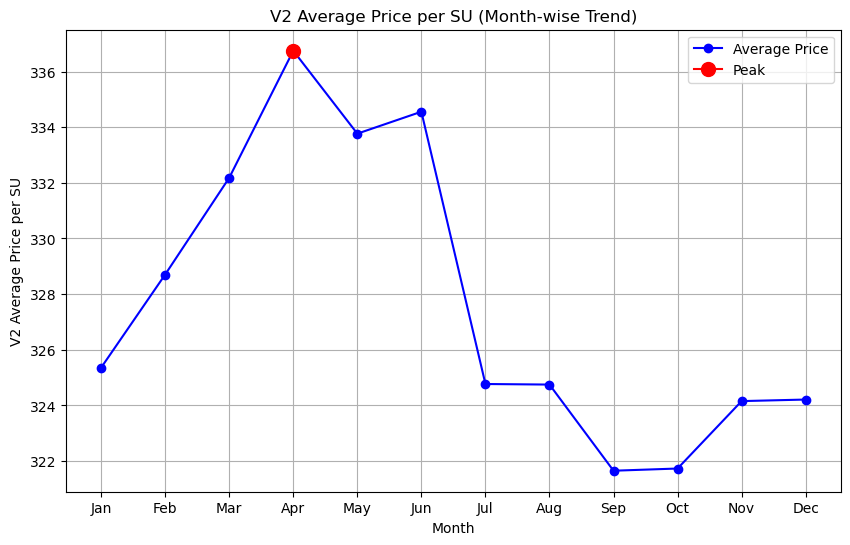

In [62]:

# Ensure the index is in datetime format
sales_media_merged.index = pd.to_datetime(sales_media_merged.index)

# Extract month from the datetime index
sales_media_merged['Month'] = sales_media_merged.index.month

# Calculate the average price per month across all years
monthly_avg_price = sales_media_merged.groupby('Month')['V2_Avg_Price_per_SU'].mean()

# Find the peak element (maximum value)
peak_month = monthly_avg_price.idxmax()
peak_value = monthly_avg_price.max()

# Plot the month-wise average price trend
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_price.index, monthly_avg_price.values, marker='o', linestyle='-', color='b', label='Average Price')
plt.plot(peak_month, peak_value, marker='o', color='r', markersize=10, label='Peak')  # Mark the peak point

# Adding labels, title, and grid
plt.title('V2 Average Price per SU (Month-wise Trend)')
plt.xlabel('Month')
plt.ylabel('V2 Average Price per SU')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)

# Show legend
plt.legend()

plt.show()


The V2 Average Price per SU is the highest in April

## Month-wise trend of V3 Average Price per SU

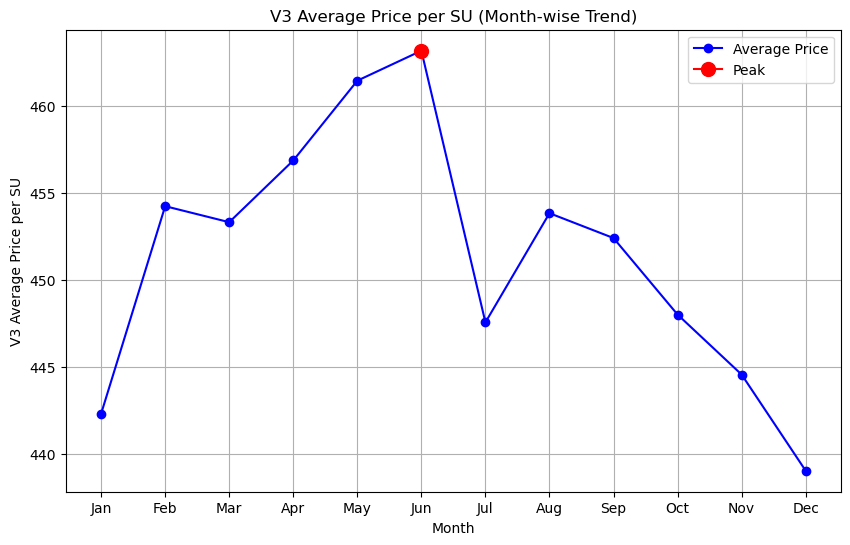

In [63]:

# Ensure the index is in datetime format
sales_media_merged.index = pd.to_datetime(sales_media_merged.index)

# Extract month from the datetime index
sales_media_merged['Month'] = sales_media_merged.index.month

# Calculate the average price per month across all years
monthly_avg_price = sales_media_merged.groupby('Month')['V3_Avg_Price_per_SU'].mean()

# Find the peak element (maximum value)
peak_month = monthly_avg_price.idxmax()
peak_value = monthly_avg_price.max()

# Plot the month-wise average price trend
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_price.index, monthly_avg_price.values, marker='o', linestyle='-', color='b', label='Average Price')
plt.plot(peak_month, peak_value, marker='o', color='r', markersize=10, label='Peak')  # Mark the peak point

# Adding labels, title, and grid
plt.title('V3 Average Price per SU (Month-wise Trend)')
plt.xlabel('Month')
plt.ylabel('V3 Average Price per SU')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)

# Show legend
plt.legend()

plt.show()


The V3 Average Price per SU is the highest in June

## Month-wise trend of Shipment SU

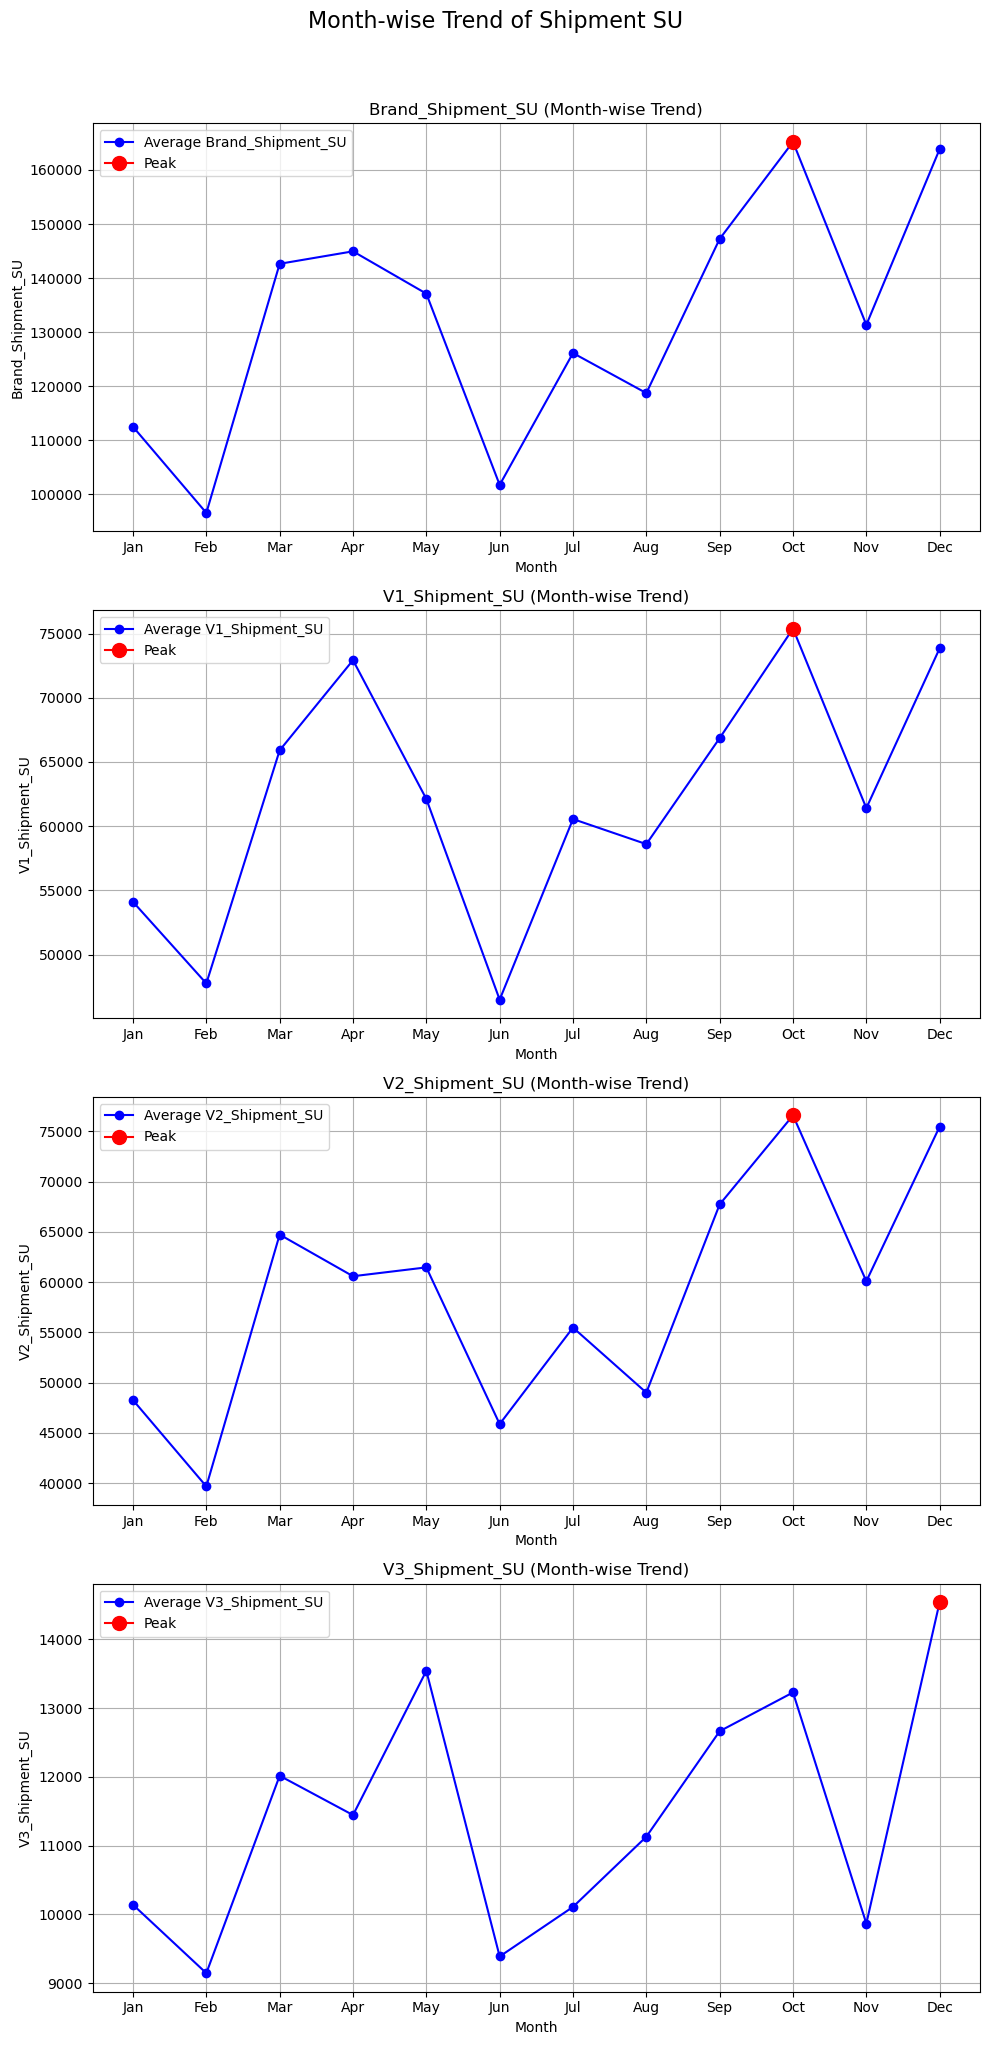

In [64]:


# Ensure the index is in datetime format
sales_media_merged.index = pd.to_datetime(sales_media_merged.index)

# Extract month from the datetime index
sales_media_merged['Month'] = sales_media_merged.index.month

# Define the shipment variables
shipment_vars = ['Brand_Shipment_SU', 'V1_Shipment_SU', 'V2_Shipment_SU', 'V3_Shipment_SU']

# Set up the subplot grid
fig, axs = plt.subplots(len(shipment_vars), 1, figsize=(10, 20))
fig.suptitle('Month-wise Trend of Shipment SU', fontsize=16, y=1.02)

# Plot each shipment variable's monthly trend in a separate subplot
for i, var in enumerate(shipment_vars):
    # Calculate the average shipment per month across all years for the current variable
    monthly_avg_shipment = sales_media_merged.groupby('Month')[var].mean()
    
    # Find the peak element (maximum value)
    peak_month = monthly_avg_shipment.idxmax()
    peak_value = monthly_avg_shipment.max()
    
    # Plot the month-wise shipment trendb
    axs[i].plot(monthly_avg_shipment.index, monthly_avg_shipment.values, marker='o', linestyle='-', color='b', label=f'Average {var}')
    axs[i].plot(peak_month, peak_value, marker='o', color='r', markersize=10, label='Peak')  # Mark the peak point
    
    # Adding labels, title, and grid
    axs[i].set_title(f'{var} (Month-wise Trend)')
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel(f'{var}')
    axs[i].set_xticks(range(1, 13))
    axs[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()


The Shipment is the highest in October for Brand, V1 and V2. <br>
The Shipment is the highest in December for V3.

## Month-wise Trend of Sales Value

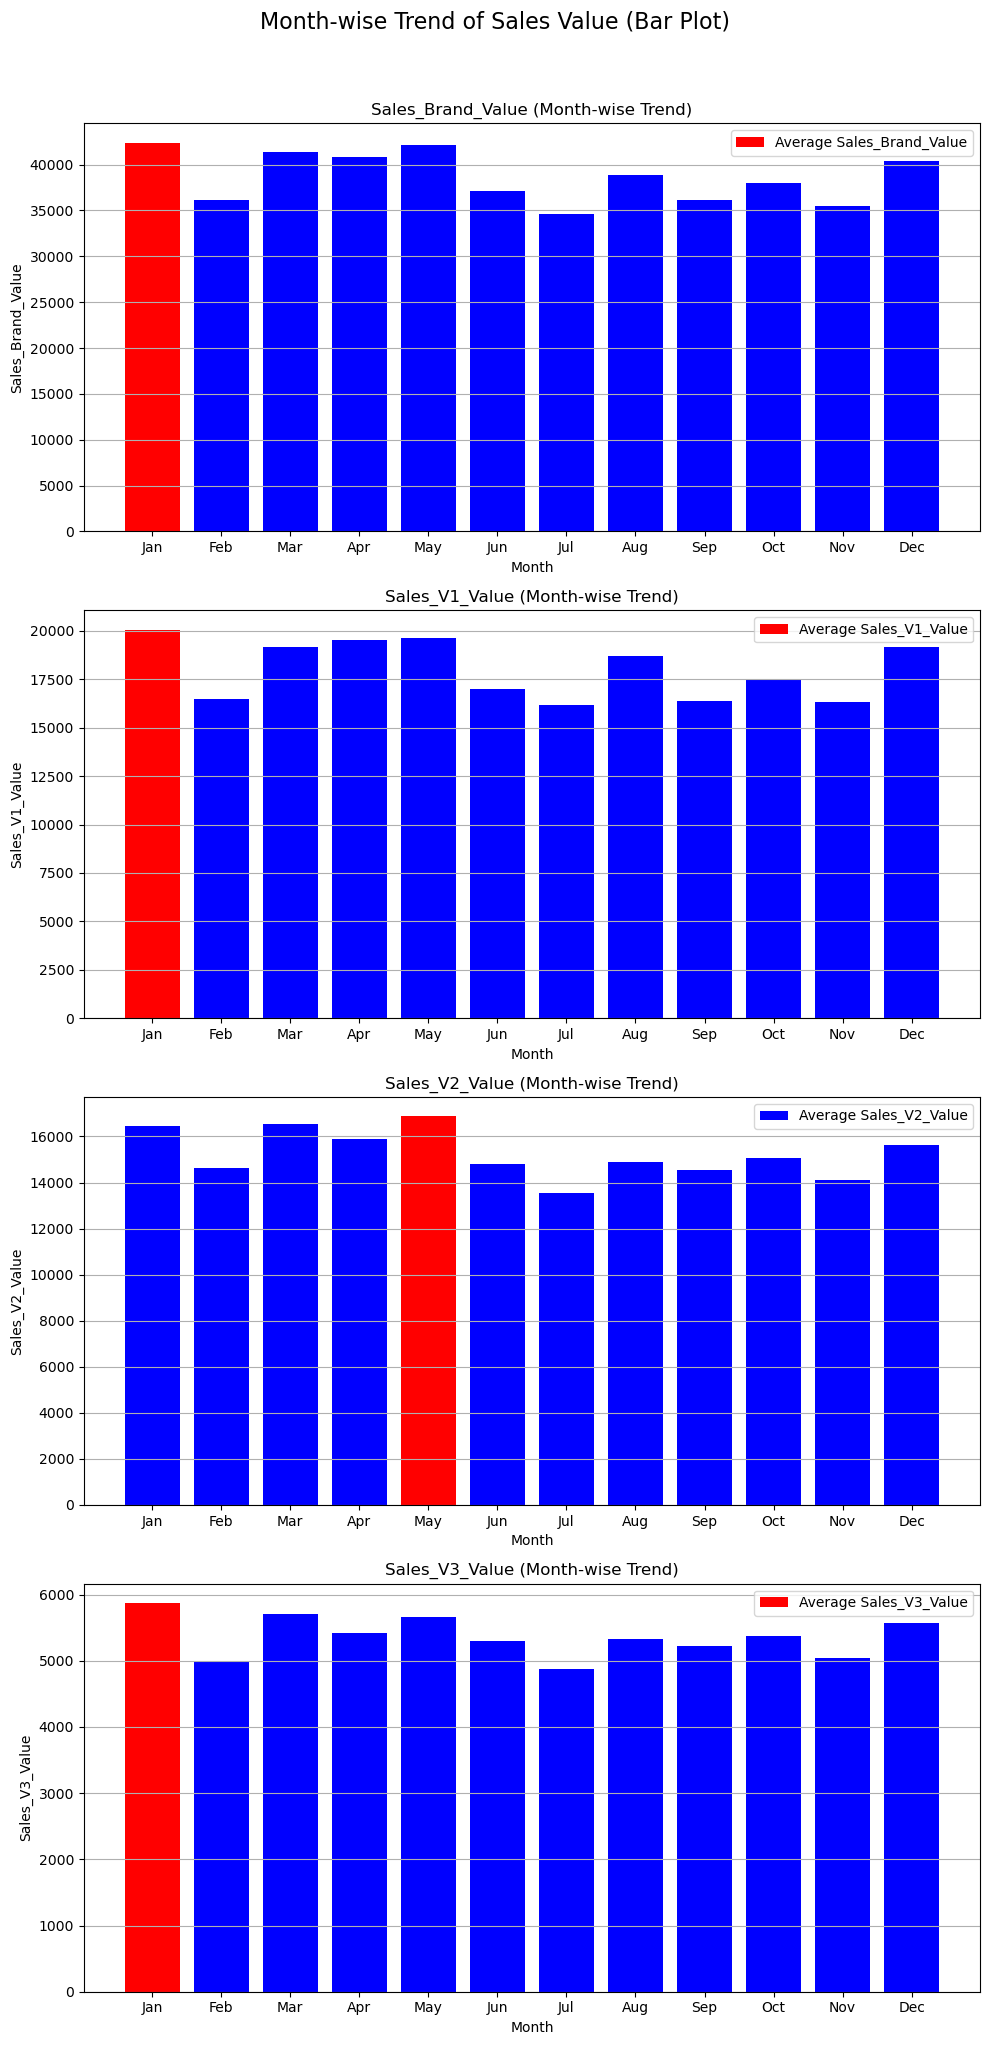

In [65]:

# Ensure the index is in datetime format
sales_media_merged.index = pd.to_datetime(sales_media_merged.index)

# Extract month from the datetime index
sales_media_merged['Month'] = sales_media_merged.index.month

# Define the sales value variables
sales_value_vars = ['Sales_Brand_Value', 'Sales_V1_Value', 'Sales_V2_Value', 'Sales_V3_Value']

# Set up the subplot grid
fig, axs = plt.subplots(len(sales_value_vars), 1, figsize=(10, 20))
fig.suptitle('Month-wise Trend of Sales Value (Bar Plot)', fontsize=16, y=1.02)

# Plot each sales value variable's monthly trend in a separate subplot as a bar plot
for i, var in enumerate(sales_value_vars):
    # Calculate the average sales value per month across all years for the current variable
    monthly_avg_sales_value = sales_media_merged.groupby('Month')[var].mean()
    
    # Find the peak element (maximum value)
    peak_month = monthly_avg_sales_value.idxmax()
    
    # Plot the month-wise sales value trend as a bar plot
    bar_colors = ['r' if month == peak_month else 'b' for month in monthly_avg_sales_value.index]
    axs[i].bar(monthly_avg_sales_value.index, monthly_avg_sales_value.values, color=bar_colors, label=f'Average {var}')
    
    # Adding labels, title, and grid
    axs[i].set_title(f'{var} (Month-wise Trend)')
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel(f'{var}')
    axs[i].set_xticks(range(1, 13))
    axs[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axs[i].grid(True, axis='y')
    axs[i].legend()

plt.tight_layout()
plt.show()


The Sales is the highest in January for Brand, V1 and V3. <br>
The Sales is the highest in May for V2.

## Month-wise Trend of NUMD

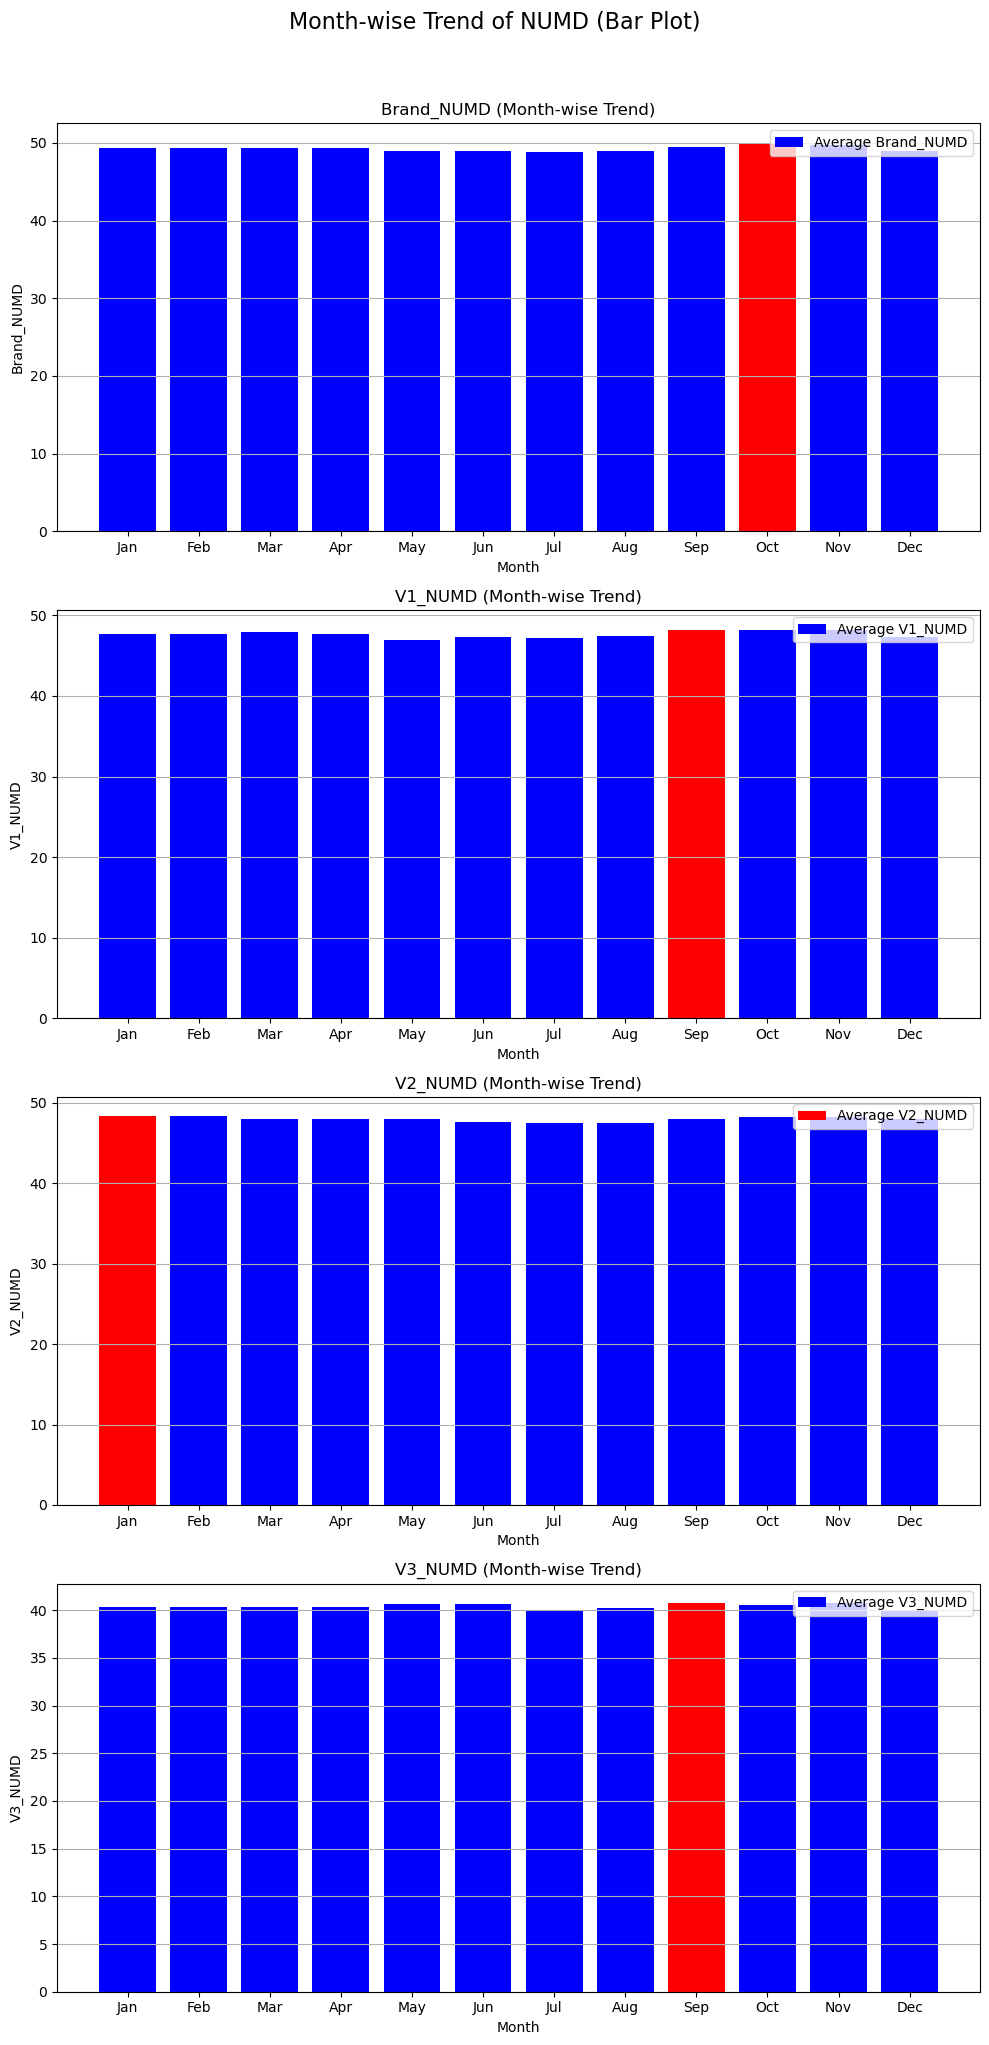

In [66]:

# Ensure the index is in datetime format
sales_media_merged.index = pd.to_datetime(sales_media_merged.index)

# Extract month from the datetime index
sales_media_merged['Month'] = sales_media_merged.index.month

# Define the numd variables
numd_vars = ['Brand_NUMD', 'V1_NUMD','V2_NUMD', 'V3_NUMD']

# Set up the subplot grid
fig, axs = plt.subplots(len(numd_vars), 1, figsize=(10, 20))
fig.suptitle('Month-wise Trend of NUMD (Bar Plot)', fontsize=16, y=1.02)

# Plot each numd variable's monthly trend in a separate subplot as a bar plot
for i, var in enumerate(numd_vars):
    # Calculate the average numd per month across all years for the current variable
    monthly_avg_numd = sales_media_merged.groupby('Month')[var].mean()
    
    # Find the peak element (maximum value)
    peak_month = monthly_avg_numd.idxmax()
    
    # Plot the month-wise numd trend as a bar plot
    bar_colors = ['r' if month == peak_month else 'b' for month in monthly_avg_numd.index]
    axs[i].bar(monthly_avg_numd.index, monthly_avg_numd.values, color=bar_colors, label=f'Average {var}')
    
    # Adding labels, title, and grid
    axs[i].set_title(f'{var} (Month-wise Trend)')
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel(f'{var}')
    axs[i].set_xticks(range(1, 13))
    axs[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axs[i].grid(True, axis='y')
    axs[i].legend()

plt.tight_layout()
plt.show()


The NUMD is the highest in September for V1 and V3. <br>
The NUMD is the highest in October for Brand.<br>
The NUMD is the highest in January for V2. <br>

## Month-wise Trend of WTD

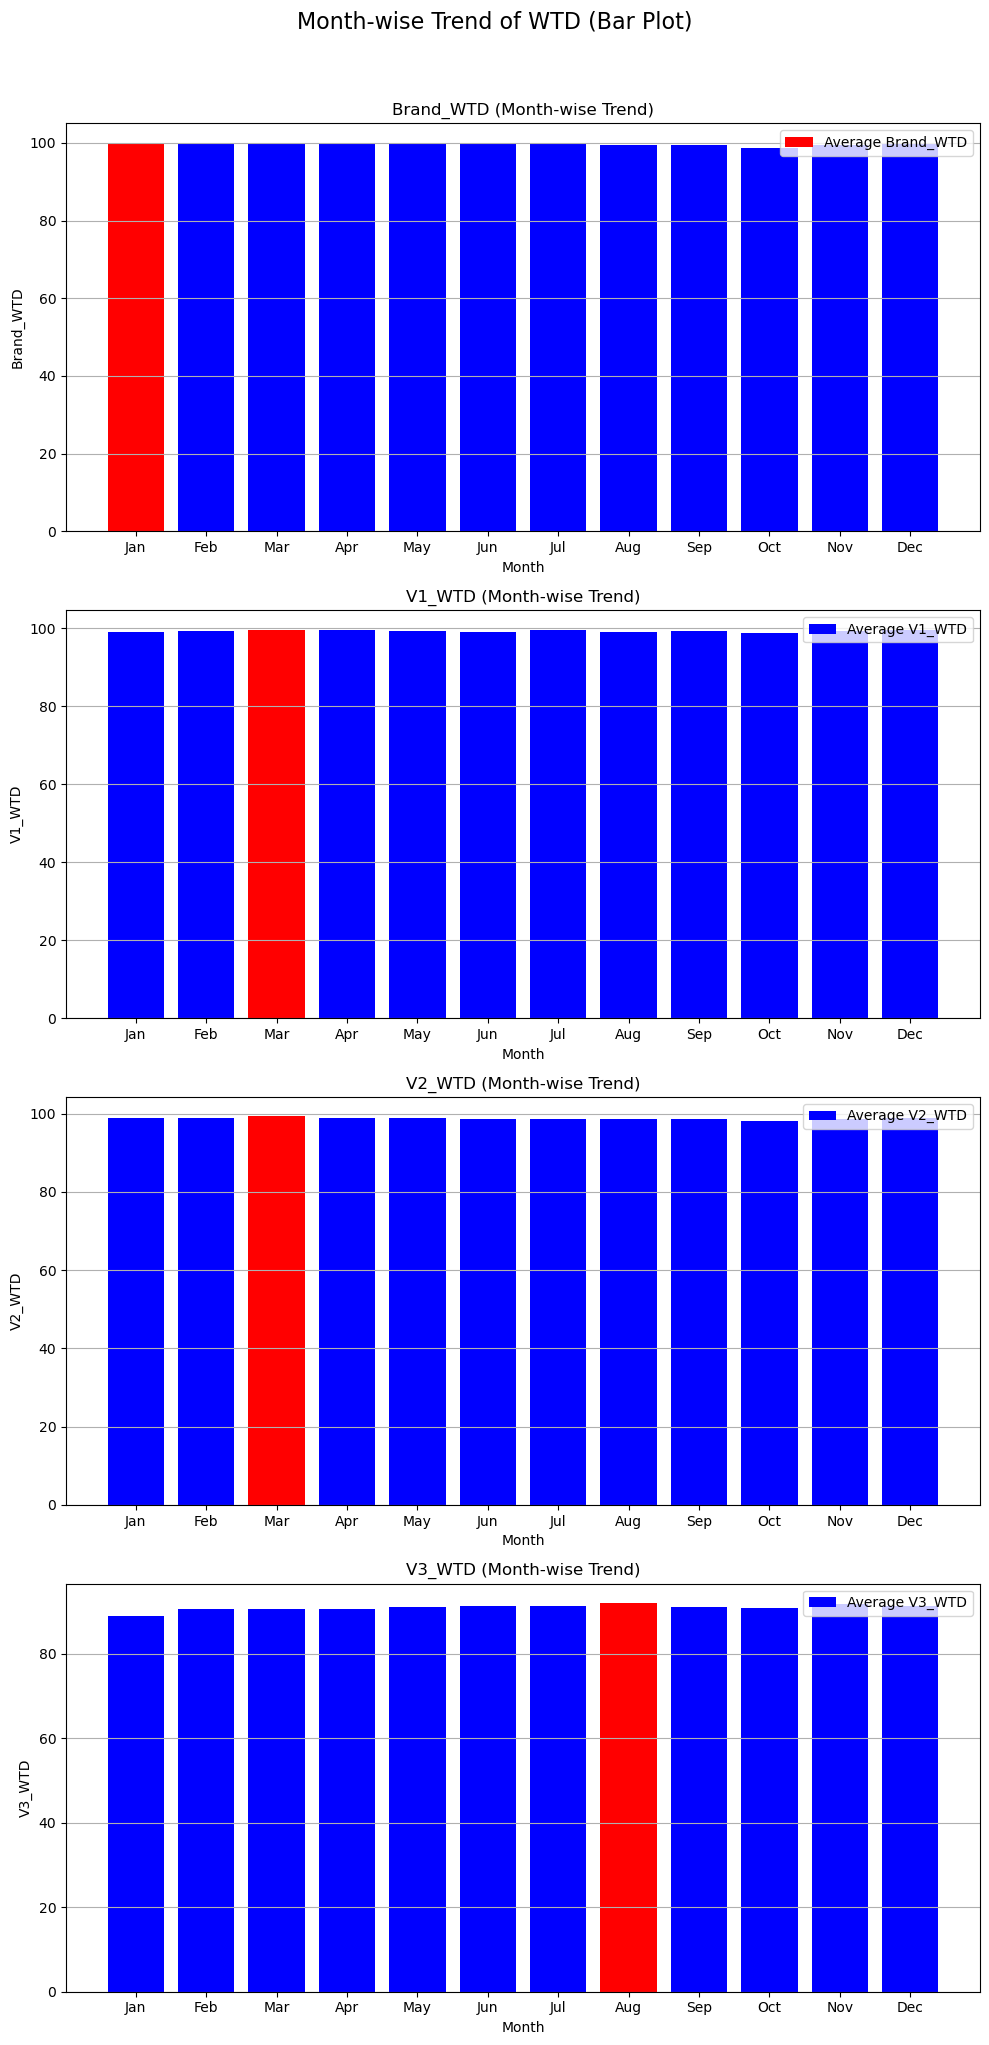

In [67]:

# Ensure the index is in datetime format
sales_media_merged.index = pd.to_datetime(sales_media_merged.index)

# Extract month from the datetime index
sales_media_merged['Month'] = sales_media_merged.index.month

# Define the wtd variables
wtd_vars = ['Brand_WTD', 'V1_WTD','V2_WTD', 'V3_WTD']

# Set up the subplot grid
fig, axs = plt.subplots(len(numd_vars), 1, figsize=(10, 20))
fig.suptitle('Month-wise Trend of WTD (Bar Plot)', fontsize=16, y=1.02)

# Plot each wtd variable's monthly trend in a separate subplot as a bar plot
for i, var in enumerate(wtd_vars):
    # Calculate the average wtd per month across all years for the current variable
    monthly_avg_wtd = sales_media_merged.groupby('Month')[var].mean()
    
    # Find the peak element (maximum value)
    peak_month = monthly_avg_wtd.idxmax()
    
    # Plot the month-wise wtd trend as a bar plot
    bar_colors = ['r' if month == peak_month else 'b' for month in monthly_avg_wtd.index]
    axs[i].bar(monthly_avg_wtd.index, monthly_avg_wtd.values, color=bar_colors, label=f'Average {var}')
    
    # Adding labels, title, and grid
    axs[i].set_title(f'{var} (Month-wise Trend)')
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel(f'{var}')
    axs[i].set_xticks(range(1, 13))
    axs[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axs[i].grid(True, axis='y')
    axs[i].legend()

plt.tight_layout()
plt.show()


The Shipment is the highest in March for V1 and V2. <br>
The Shipment is the highest in January for Brand.<br>
The Shipment is the highest in August for V3.

## Channel Effectiveness on Sales Value

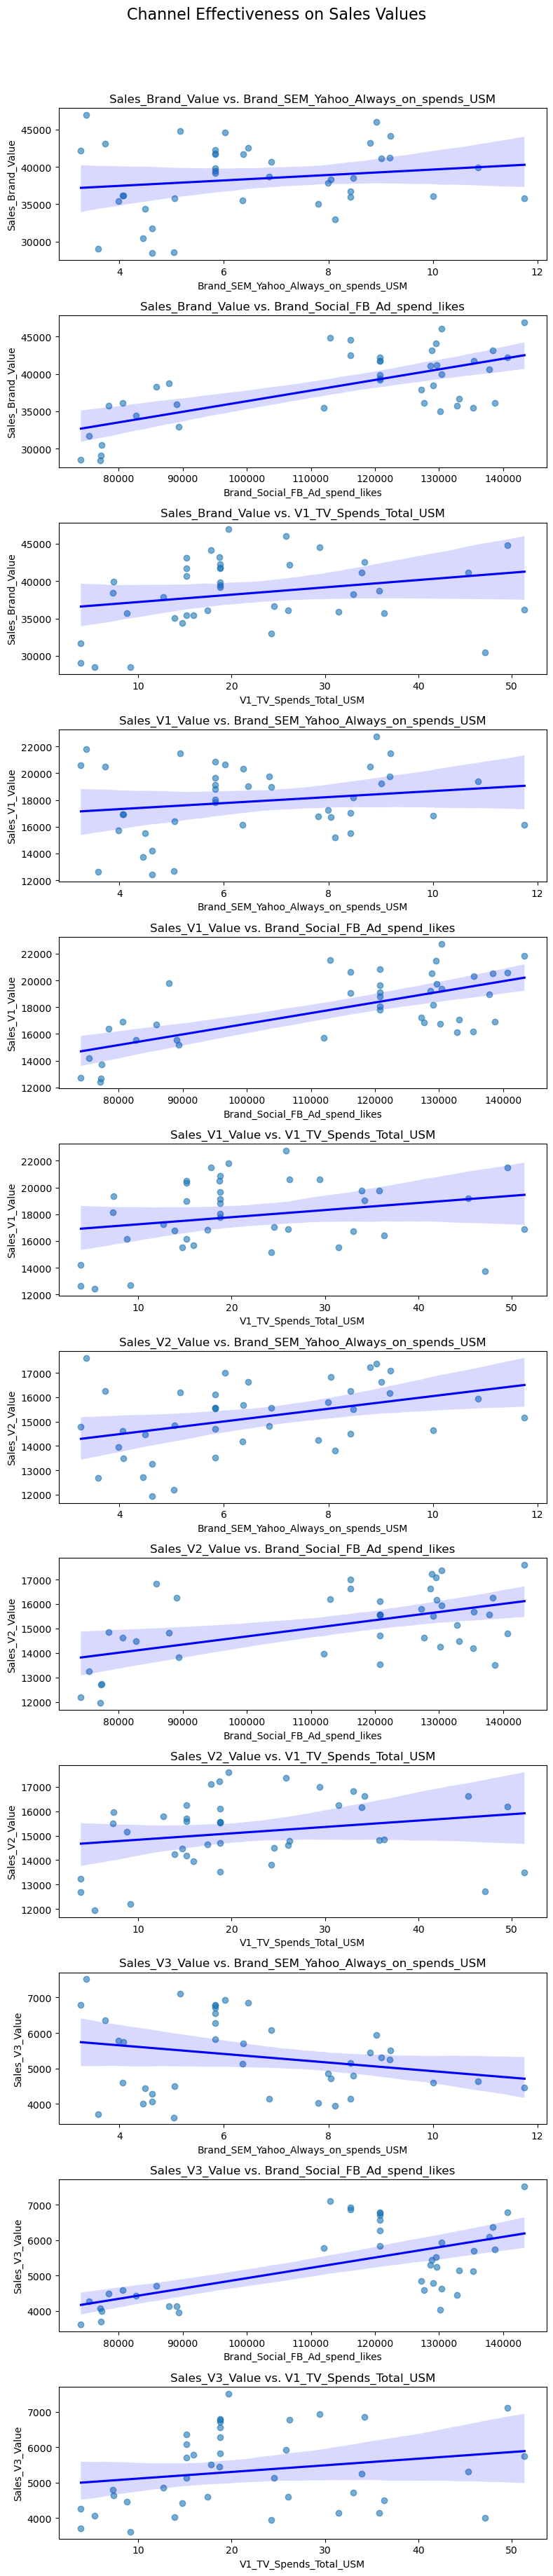

In [68]:

# Define the sales variables and spend channels
sales_vars = ['Sales_Brand_Value', 'Sales_V1_Value', 'Sales_V2_Value', 'Sales_V3_Value']
spend_channels = [
    'Brand_SEM_Yahoo_Always_on_spends_USM',
    'Brand_Social_FB_Ad_spend_likes',
    'V1_TV_Spends_Total_USM'
]

# Set up the plotting area
fig, axs = plt.subplots(len(sales_vars) * len(spend_channels), 1, figsize=(8, len(sales_vars) * len(spend_channels) * 3))
fig.suptitle("Channel Effectiveness on Sales Values", fontsize=16, y=1.02)
plt.subplots_adjust(hspace=0.5)

# Plot each combination of sales variable and spend channel in a single column layout
plot_idx = 0
for sales_var in sales_vars:
    for spend_channel in spend_channels:
        sns.regplot(
            x=spend_channel, 
            y=sales_var, 
            data=sales_media_merged, 
            ax=axs[plot_idx],
            scatter_kws={'alpha':0.6},
            line_kws={'color': 'blue'}
        )
        axs[plot_idx].set_title(f"{sales_var} vs. {spend_channel}")
        axs[plot_idx].set_xlabel(spend_channel)
        axs[plot_idx].set_ylabel(sales_var)
        plot_idx += 1

plt.tight_layout()
plt.show()


- The positive slope suggests that higher SEM spending on Yahoo is associated with higher Sales_Brand_Value. This indicates a potentially effective SEM campaign.<br>
- There’s also a positive correlation between Facebook ad spend (likes) and Sales_Brand_Value. This implies that increased engagement on Facebook through ad spend may contribute positively to brand sales.<br>
- The relationship between TV spend and Sales_Brand_Value appears weak, with a nearly flat line. This could imply that TV spend isn’t a strong driver of overall brand sales.<br>
- The positive slope suggests that SEM spending on Yahoo has a stronger positive impact on Sales_V2_Value than on Sales_V1_Value, potentially making it more effective for V2 sales.<br>
- A positive trend suggests Facebook ad spend also has a positive effect on Sales_V2_Value, similar to its effect on Sales_Brand_Value.<br>
- A negative trend suggests that higher SEM spending on Yahoo might actually correlate with lower Sales_V3_Value. This may indicate that SEM isn’t effective for V3.<br>
- The impact of TV spending on sales values appears weak across the board, implying that TV may not be a highly effective channel for driving sales for this brand and its variants.

## Yearly Average Distribution

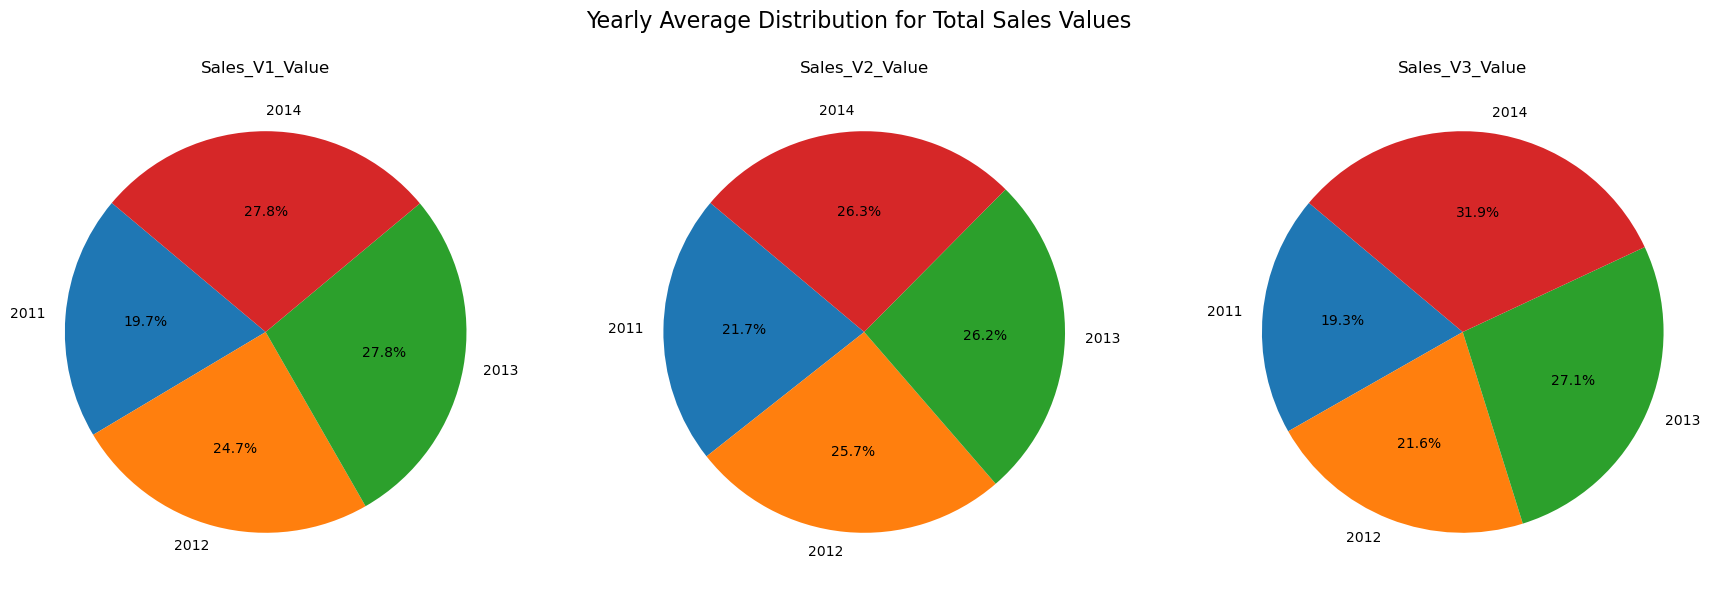

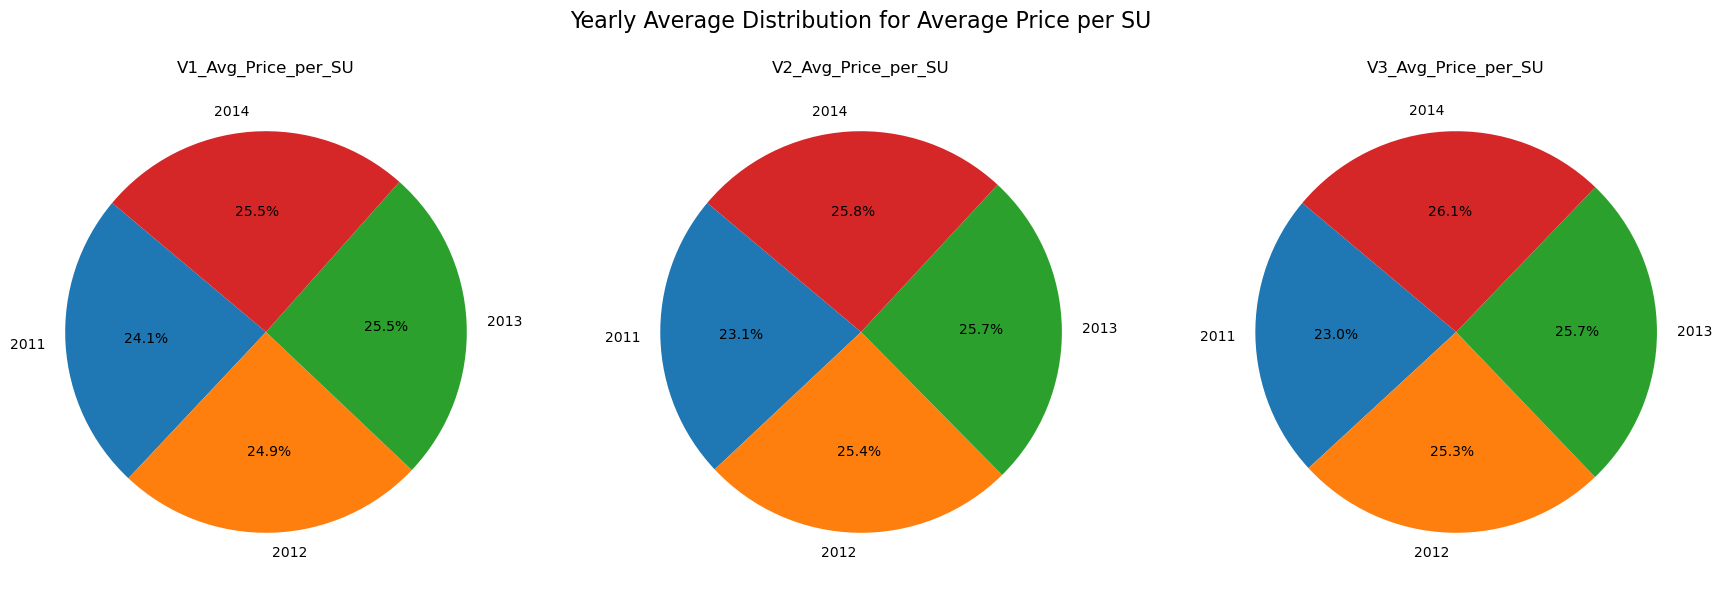

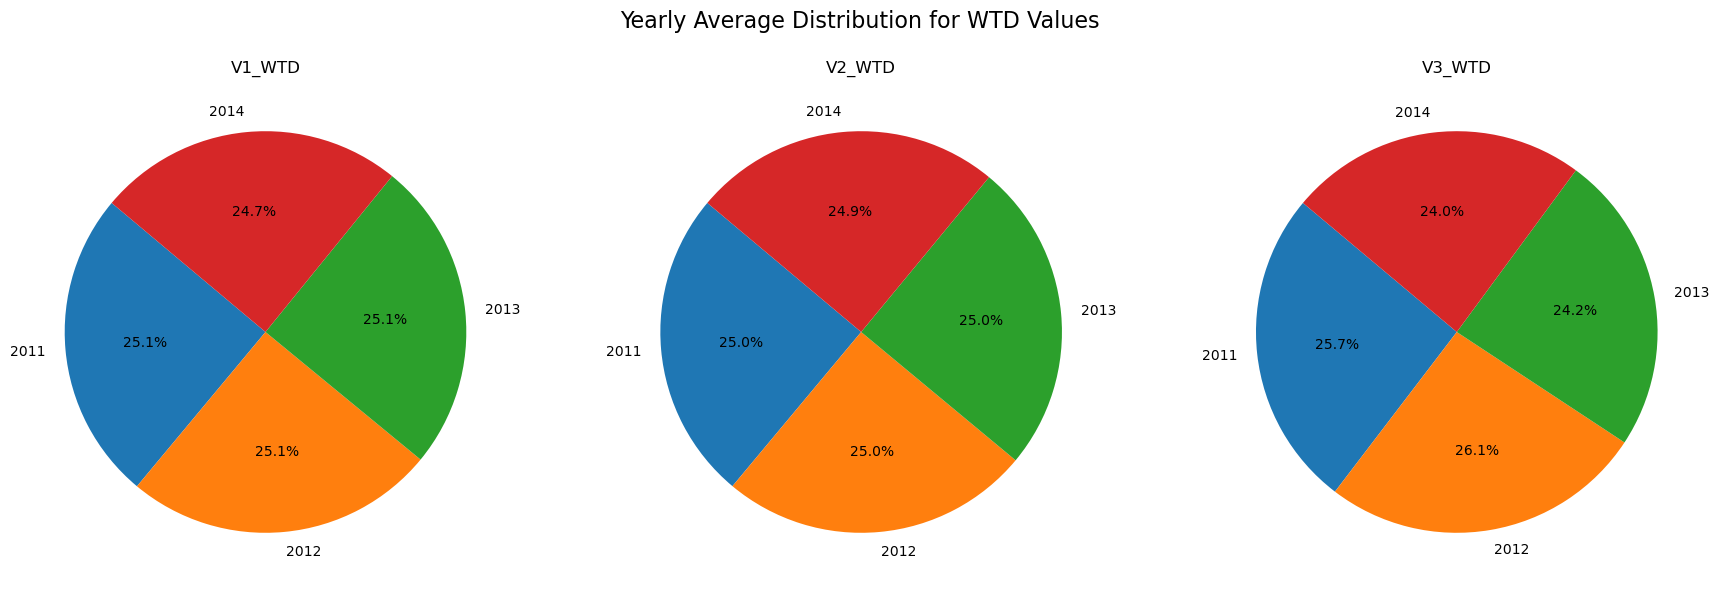

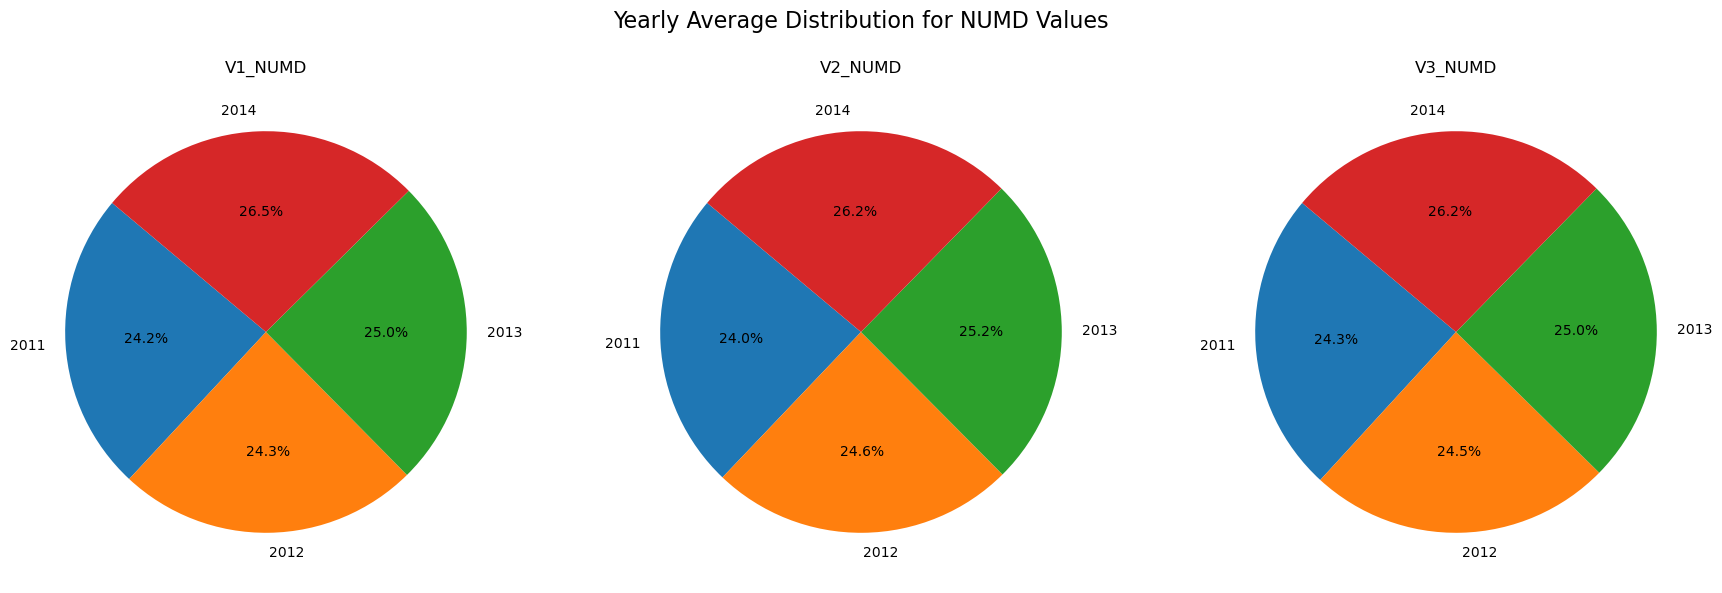

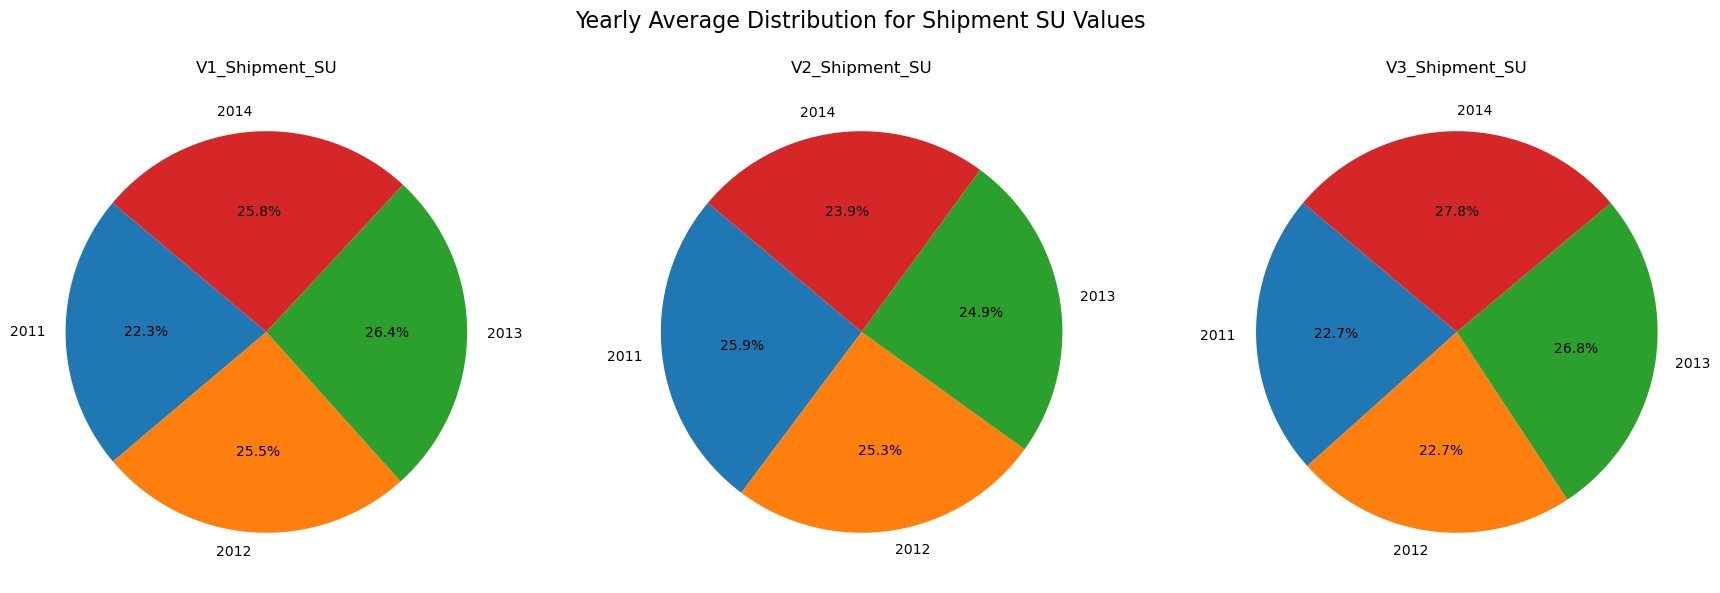

In [69]:
# Ensure the index is in datetime format
sales_media_merged.index = pd.to_datetime(sales_media_merged.index)

# Extract the year from the datetime index
sales_media_merged['Year'] = sales_media_merged.index.year

column_sets = [
    (['Sales_V1_Value', 'Sales_V2_Value', 'Sales_V3_Value'], 'Total Sales Values'),
    (['V1_Avg_Price_per_SU', 'V2_Avg_Price_per_SU', 'V3_Avg_Price_per_SU'], 'Average Price per SU'),
    (['V1_WTD', 'V2_WTD', 'V3_WTD'], 'WTD Values'),
    (['V1_NUMD', 'V2_NUMD', 'V3_NUMD'], 'NUMD Values'),
    (['V1_Shipment_SU', 'V2_Shipment_SU', 'V3_Shipment_SU'], 'Shipment SU Values')
]

for columns, title in column_sets:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Use a 1x3 grid for each set
    fig.suptitle(f'Yearly Average Distribution for {title}', fontsize=16)
    
    for i, col in enumerate(columns):
        # Calculate yearly average for each column
        yearly_avg = sales_media_merged.groupby('Year')[col].mean()
        
        # Plot pie chart for each column
        ax = axes[i]  # Position in 1x3 grid
        ax.pie(yearly_avg, labels=yearly_avg.index, autopct='%1.1f%%', startangle=140)
        ax.set_title(f'{col}')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.show()


- 2014 has the highest average sales in Brand, V1, V2 and V3.<br>
- 2011 has the lowest average sales in Brand, V1, V2 and V3.<br>
- 2014 has the highest average price in Brand, V1, V2 and V3.<br>
- 2011 has the lowest average price in Brand, V1, V2 and V3.<br>
- 2014 has the lowest average WTD in Brand, V1, V2 and V3.<br>
- 2014 has the highest average NUMD in Brand, V1, V2 and V3.<br>
- 2011 has the lowest average NUMD in Brand, V1, V2 and V3.<br>
- 2013 has the highest average shipment in Brand and V1, 2011 has the highest in V2 and 2014 has the highest in V3.

## Yearly Distribution of Sales Value

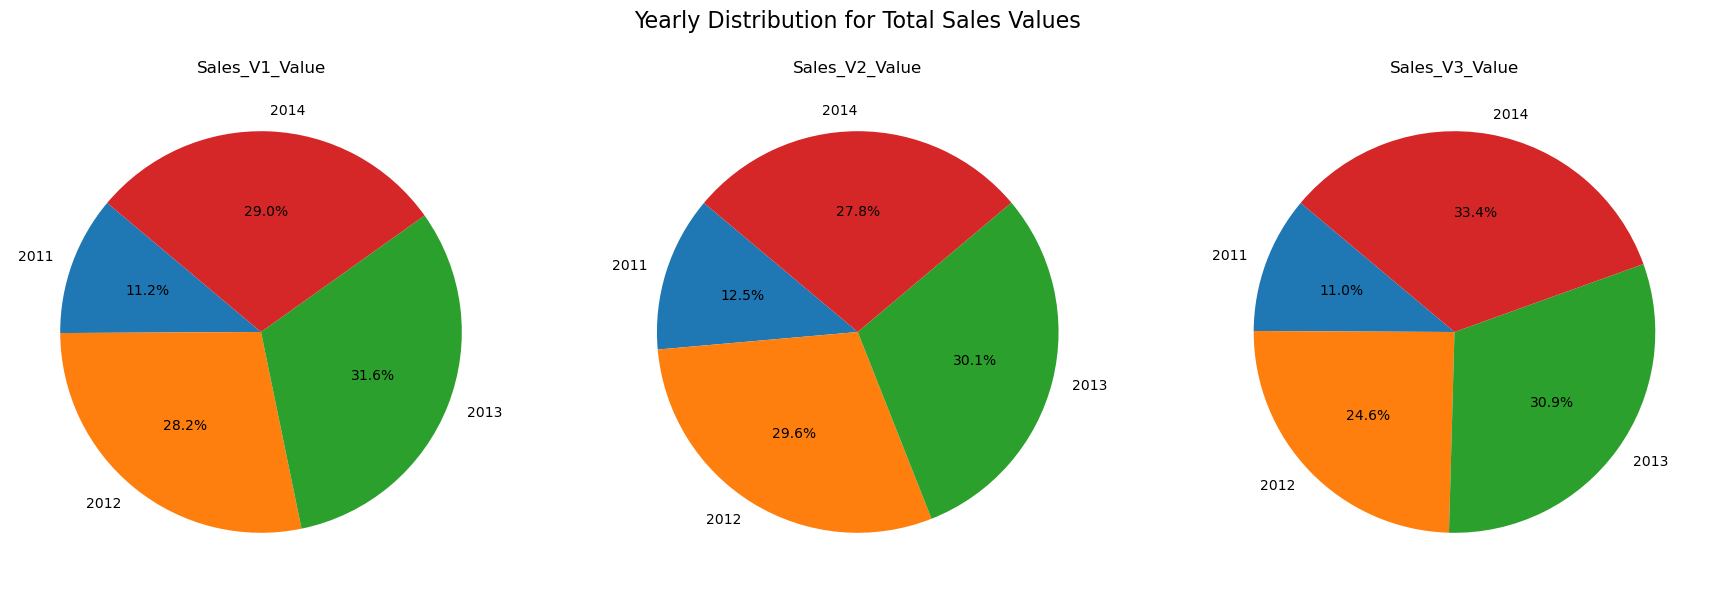

In [70]:

# Ensure the index is in datetime format
sales_media_merged.index = pd.to_datetime(sales_media_merged.index)

# Extract the year from the datetime index
sales_media_merged['Year'] = sales_media_merged.index.year

# Define the single set of columns and title for total sales values
column_set = ['Sales_V1_Value', 'Sales_V2_Value', 'Sales_V3_Value']
title = 'Total Sales Values'

# Set up the 1x3 grid for the pie charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns for the subplots
fig.suptitle(f'Yearly Distribution for {title}', fontsize=16)

# Loop through each column in the set and plot the pie charts
for i, col in enumerate(column_set):
    # Calculate yearly total for the current sales column
    yearly_data = sales_media_merged.groupby('Year')[col].sum()
    
    # Plot the pie chart
    axes[i].pie(yearly_data, labels=yearly_data.index, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f'{col}')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


- Since we don't have the complete data for 2011, the total sales value for 2011 is the lowest.
- 2013 has the highest V1 and V2 sales.
- 2014 has the highest V3 sales.

# Linear Regression Models

## VIF Calculation

In [71]:


# Select all columns from the DataFrame
X_all = sales_media_merged.copy()

# Add constant for intercept in VIF calculation
X_all_with_constant = add_constant(X_all)

# Calculate the VIF for each column
vif_data = pd.DataFrame()
vif_data["Feature"] = X_all_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(X_all_with_constant.values, i) for i in range(X_all_with_constant.shape[1])]

# Display the VIF values for all columns
print("VIF values for all columns:")
print(vif_data.sort_values(by="VIF", ascending=False))


VIF values for all columns:
                                       Feature           VIF
26                              V1_Shipment_SU           inf
38                  V1_TV_F30_39_ISP_Total_GRP           inf
27                              V2_Shipment_SU           inf
28                              V3_Shipment_SU           inf
29               Brand_SEM_Yahoo_Always_on_Imp           inf
30            Brand_SEM_Yahoo_Always_on_Clicks           inf
31        Brand_SEM_Yahoo_Always_on_spends_USM           inf
32              Brand_Social_FB_Ad_spend_likes           inf
34                  Brand_Number_of_births_CPA           inf
35        Brand_YouTube_SideBySide_Video_views           inf
37                      V1_TV_F30_39_Total_GRP           inf
39                      V1_TV_Spends_Total_USM           inf
24                                     V3_NUMD           inf
40                        V1_TV_Spends_ISP_USM           inf
41                         V1_iMedia_Imp_Total           

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [72]:
# Create month dummies
sales_media_merged = pd.get_dummies(sales_media_merged, columns=['Month']) 

## Brand - Linear Regression Model

In [73]:


# Define the features and target
features = ['Brand_Avg_Price_per_SU', 'Brand_Shipment_SU','Brand_Social_FB_Ad_spend_likes','Month_3','Month_7','Month_12' ]  
target = 'Sales_Brand_Value'

# Split the data into training and testing sets
X = sales_media_merged[features]
y = sales_media_merged[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Calculate Adjusted R²
n = len(y_test)  # Number of test samples
p = X_test.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print the evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print("Mean Absolute Percentage Error (MAPE):", mape, "%")
print("Adjusted R-squared (Adjusted R2):", adjusted_r2) 

Root Mean Squared Error (RMSE): 1454.478553293662
R-squared (R2): 0.8283646337261984
Mean Absolute Percentage Error (MAPE): 3.0512118165049555 %
Adjusted R-squared (Adjusted R2): 0.3134585349047936


### Actual VS Predicted Sales_Brand_Value

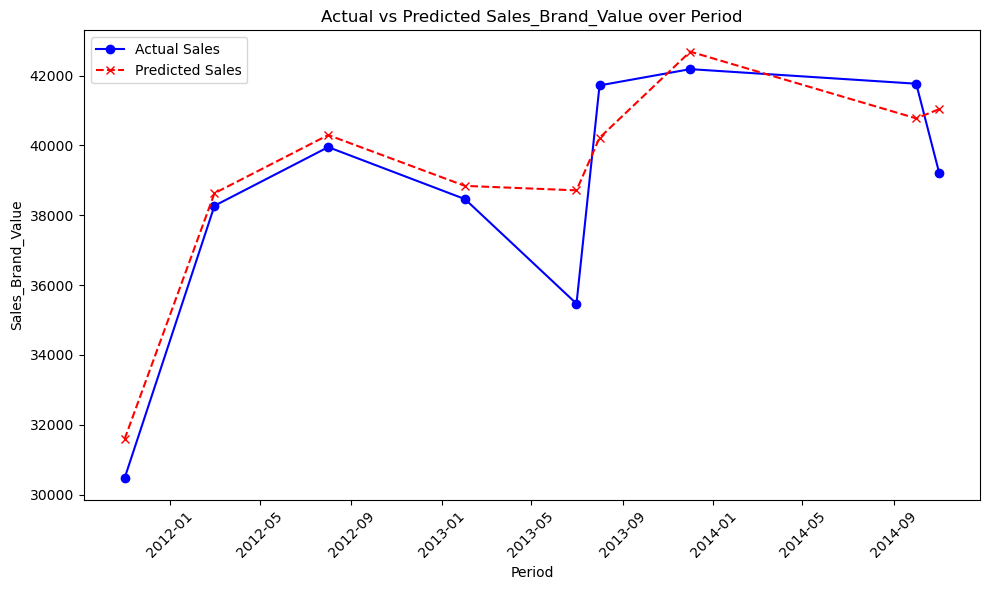

In [74]:

result_df = pd.DataFrame({
    'Period': y_test.index,  # Using the index of y_test for the period
    'Actual_Sales': y_test,  # Actual sales values from the test set
    'Predicted_Sales': y_pred  # Predicted sales values
})

# Sort the DataFrame by 'Period' to ensure the x-axis is in chronological order
result_df = result_df.sort_index()

# Plotting the actual vs predicted sales values
plt.figure(figsize=(10, 6))
plt.plot(result_df['Period'], result_df['Actual_Sales'], label='Actual Sales', color='blue', linestyle='-', marker='o')
plt.plot(result_df['Period'], result_df['Predicted_Sales'], label='Predicted Sales', color='red', linestyle='--', marker='x')

# Adding titles and labels
plt.title('Actual vs Predicted Sales_Brand_Value over Period')
plt.xlabel('Period')
plt.ylabel('Sales_Brand_Value')
plt.legend()

# Display the plot
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


## V1 - Linear Regression Model

In [75]:


# Define dependent and independent variables
independent_vars = [
    'V1_Avg_Price_per_SU',
    'V1_iMedia_Imp_Total',
    'V1_TV_F30_39_Total_GRP',
    'Month_7', 'Month_8','Month_11'
]
dependent_var = 'Sales_V1_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Print the evaluation metrics
print("\nLinear Regression Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display model coefficients
coefficients = pd.DataFrame(linear_model.coef_, X.columns, columns=['Coefficient'])
print("\nLinear Regression Model Coefficients:")
print(coefficients)



Linear Regression Model Performance Metrics:
Root Mean Squared Error (RMSE): 1006.0968366623958
R-squared (R2): 0.7723928884150484
Adjusted R-squared (Adjusted R2): 0.08957155366019354
Mean Absolute Percentage Error (MAPE): 4.625802280367711

Linear Regression Model Coefficients:
                                Coefficient
V1_Avg_Price_per_SU             -369.558258
V1_iMedia_Imp_Total               92.631190
Month_7                         -219.171156
Month_8                          401.521453
Month_11                        -702.602378
Adstock_V1_TV_F30_39_Total_GRP  2189.467763


### Actual VS Predicted Sales_V1_Value

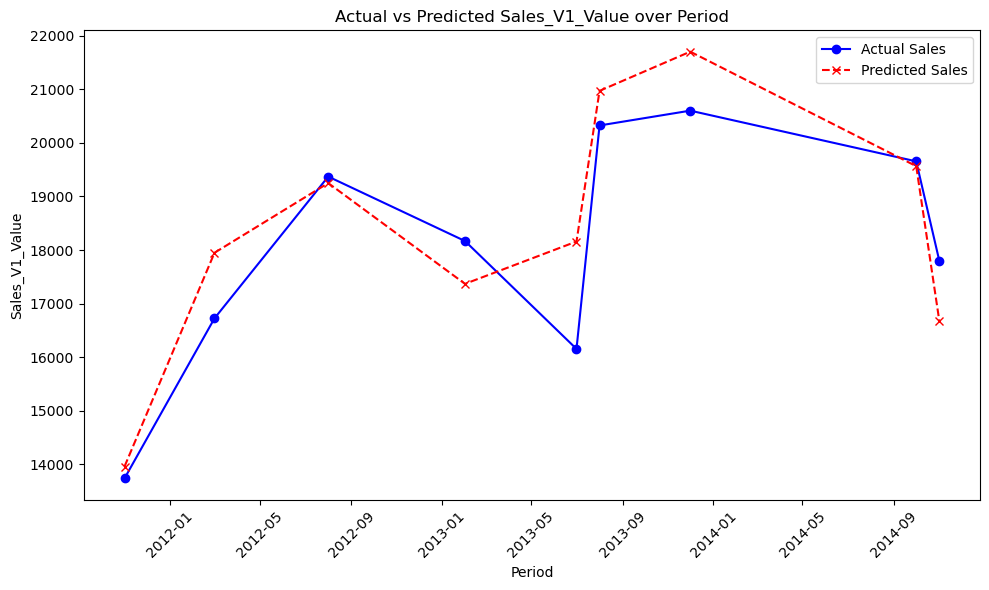

In [76]:

v1_plot_df = pd.DataFrame({
    'Period': y_test.index,  # Using the index of y_test for the period
    'Actual_Sales': y_test,  # Actual sales values from the test set
    'Predicted_Sales': y_pred  # Predicted sales values
})

# Sort the DataFrame by 'Period' to ensure the x-axis is in chronological order
v1_plot_df = v1_plot_df.sort_index()

# Plotting the actual vs predicted sales values
plt.figure(figsize=(10, 6))
plt.plot(v1_plot_df['Period'], v1_plot_df['Actual_Sales'], label='Actual Sales', color='blue', linestyle='-', marker='o')
plt.plot(v1_plot_df['Period'], v1_plot_df['Predicted_Sales'], label='Predicted Sales', color='red', linestyle='--', marker='x')

# Adding titles and labels
plt.title('Actual vs Predicted Sales_V1_Value over Period')
plt.xlabel('Period')
plt.ylabel('Sales_V1_Value')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## V2 - Linear Regression Model

In [77]:
# Define dependent and independent variables
independent_vars = [
    'V2_Avg_Price_per_SU',
    'V1_TV_F30_39_Total_GRP',
    'Month_3', 'Month_7', 'Month_1',
    'V1_TV_Spends_Total_USM',
    'V1_iMedia_Imp_Total',
]

dependent_var = 'Sales_V2_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7  # Adjust this based on domain knowledge
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (v2_X) and target variable (v2_y)
v2_X = sales_media_merged[independent_vars]
v2_y = sales_media_merged[dependent_var]



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(v2_X)

# Split data into training and testing sets
X_train, X_test, y_train, v2_y_test = train_test_split(X_scaled, v2_y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
v2_y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(v2_y_test, v2_y_pred))
r2 = r2_score(v2_y_test, v2_y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(v2_y_test) - 1) / (len(v2_y_test) - X_test.shape[1] - 1)
mape = mean_absolute_percentage_error(v2_y_test, v2_y_pred) * 100

print("\nModel Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display model coefficients
v2_coefficients = pd.DataFrame(model.coef_, v2_X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(v2_coefficients)



Model Performance Metrics:
Root Mean Squared Error (RMSE): 527.0637714547702
R-squared (R2): 0.7757765490067254
Adjusted R-squared (Adjusted R2): -0.7937876079461965
Mean Absolute Percentage Error (MAPE): 2.4894206117275473

Model Coefficients:
                                Coefficient
V2_Avg_Price_per_SU              740.812104
Month_3                          217.032715
Month_7                         -403.306602
Month_1                          372.660505
V1_TV_Spends_Total_USM           -81.586444
V1_iMedia_Imp_Total               68.180989
Adstock_V1_TV_F30_39_Total_GRP   173.898457


### Actual VS Predicted Sales_V2_Value

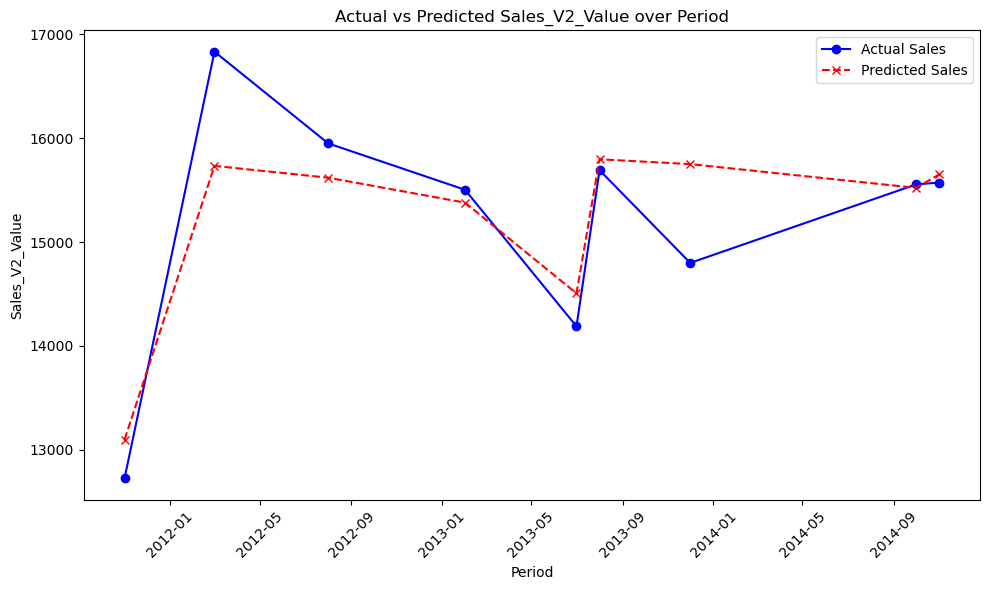

In [78]:

v2_plot_df = pd.DataFrame({
    'Period': v2_y_test.index,  # Using the index of y_test for the period
    'Actual_Sales': v2_y_test,  # Actual sales values from the test set
    'Predicted_Sales': v2_y_pred  # Predicted sales values
})

# Sort the DataFrame by 'Period' to ensure the x-axis is in chronological order
v2_plot_df = v2_plot_df.sort_index()

# Plotting the actual vs predicted sales values
plt.figure(figsize=(10, 6))
plt.plot(v2_plot_df['Period'], v2_plot_df['Actual_Sales'], label='Actual Sales', color='blue', linestyle='-', marker='o')
plt.plot(v2_plot_df['Period'], v2_plot_df['Predicted_Sales'], label='Predicted Sales', color='red', linestyle='--', marker='x')

# Adding titles and labels
plt.title('Actual vs Predicted Sales_V2_Value over Period')
plt.xlabel('Period')
plt.ylabel('Sales_V2_Value')
plt.legend()

# Display the plot
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


## V3 - Linear Regression Model

In [79]:


# Define dependent and independent variables
independent_vars = [
    'V3_Avg_Price_per_SU',
    'V1_Avg_Price_per_SU',
    'V3_Shipment_SU',
    'V1_iMedia_Spends_Total_USM_Digital',
    'V1_TV_F30_39_Total_GRP',
        'V1_TV_Spends_Total_USM',
       'V1_TV_Spends_ISP_USM',
      #'Month_2','Month_7','Month_11'
    'Month_12','Month_1','Month_6','Month_8',
    'V1_iMedia_Imp_Total'
    
]

dependent_var = 'Sales_V3_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7 
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("\nModel Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")



# Display model coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)



Model Performance Metrics:
Root Mean Squared Error (RMSE): 309.2153686919898
R-squared (R2): 0.876498428080884
Adjusted R-squared (Adjusted R2): 1.247003143838232
Mean Absolute Percentage Error (MAPE): 5.057534586150272

Model Coefficients:
                                    Coefficient
V3_Avg_Price_per_SU                  196.526896
V1_Avg_Price_per_SU                 -174.074891
V3_Shipment_SU                       446.313694
V1_iMedia_Spends_Total_USM_Digital  -577.295828
V1_TV_Spends_Total_USM              5398.084574
V1_TV_Spends_ISP_USM               -5374.204453
Month_12                             -62.803445
Month_1                              239.105529
Month_6                              109.559632
Month_8                               71.177628
V1_iMedia_Imp_Total                  377.177888
Adstock_V1_TV_F30_39_Total_GRP       315.146984


### Actual VS Predicted Sales_V3_Value

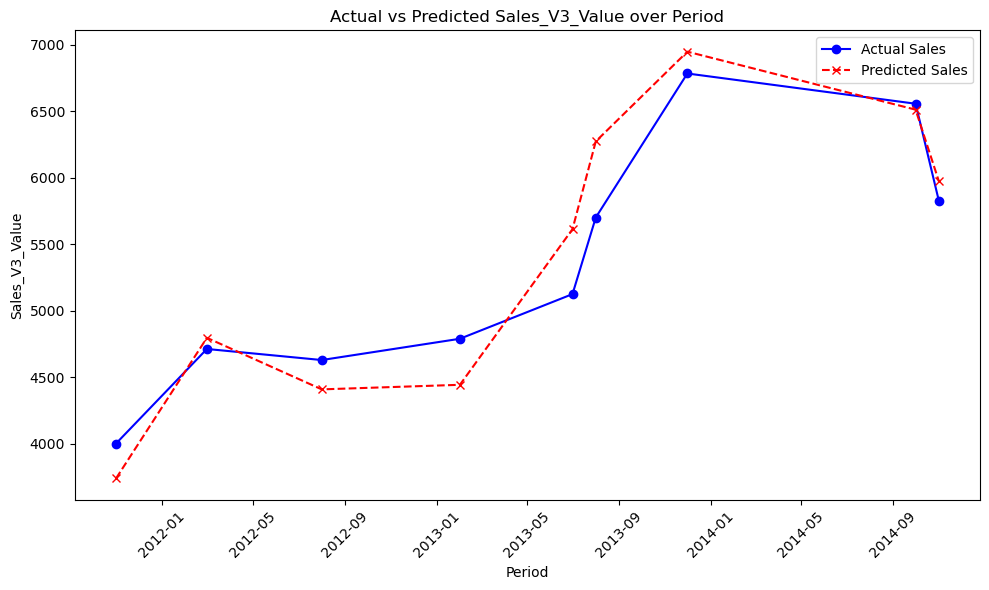

In [80]:

v3_plot_df = pd.DataFrame({
    'Period': y_test.index,  # Using the index of y_test for the period
    'Actual_Sales': y_test,  # Actual sales values from the test set
    'Predicted_Sales': y_pred  # Predicted sales values
})

# Sort the DataFrame by 'Period' to ensure the x-axis is in chronological order
v3_plot_df = v3_plot_df.sort_index()

# Plotting the actual vs predicted sales values
plt.figure(figsize=(10, 6))
plt.plot(v3_plot_df['Period'], v3_plot_df['Actual_Sales'], label='Actual Sales', color='blue', linestyle='-', marker='o')
plt.plot(v3_plot_df['Period'], v3_plot_df['Predicted_Sales'], label='Predicted Sales', color='red', linestyle='--', marker='x')

# Adding titles and labels
plt.title('Actual vs Predicted Sales_V3_Value over Period')
plt.xlabel('Period')
plt.ylabel('Sales_V3_Value')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Lasso Regression Models

## Brand - Lasso Regression Model

In [81]:
# Define the features and target
features = ['Brand_Avg_Price_per_SU', 'Brand_Shipment_SU', 'Brand_Social_FB_Ad_spend_likes', 'Month_3', 'Month_7', 'Month_12']  
target = 'Sales_Brand_Value'

# Split the data into training and testing sets
X = sales_media_merged[features]
y = sales_media_merged[target]
X_train, brand_X_test, y_train, brand_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Lasso Regression model
brand_lasso_model = Lasso(alpha=1.0)
brand_lasso_model.fit(X_train, y_train)

# Evaluate the model
brand_y_pred = brand_lasso_model.predict(brand_X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(brand_y_test, brand_y_pred))
r2 = r2_score(brand_y_test, brand_y_pred)
mape = mean_absolute_percentage_error(brand_y_test, brand_y_pred) * 100

# Calculate Adjusted R²
n = len(brand_y_test)  # Number of test samples
p = brand_X_test.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print the evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print("Mean Absolute Percentage Error (MAPE):", mape, "%")
print("Adjusted R-squared (Adjusted R2):", adjusted_r2)

# Display model coefficients
coefficients = pd.DataFrame(brand_lasso_model.coef_, X.columns, columns=['Coefficient'])
print("\nLasso Regression Model Coefficients:")
print(coefficients)


Root Mean Squared Error (RMSE): 1456.0469147263034
R-squared (R2): 0.8279942859890514
Mean Absolute Percentage Error (MAPE): 3.042152980169298 %
Adjusted R-squared (Adjusted R2): 0.3119771439562058

Lasso Regression Model Coefficients:
                                Coefficient
Brand_Avg_Price_per_SU           165.373945
Brand_Shipment_SU                  0.033605
Brand_Social_FB_Ad_spend_likes     0.060668
Month_3                         2691.503511
Month_7                        -2765.546580
Month_12                        1764.756079


## V1 - Lasso Regression Model

In [82]:

# Define dependent and independent variables
independent_vars = [
    'V1_Avg_Price_per_SU',
    'V1_iMedia_Imp_Total',
    'V1_TV_F30_39_Total_GRP',
    'Month_7', 'Month_8','Month_11'
]
dependent_var = 'Sales_V1_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Lasso Regression model
lasso_model = Lasso(alpha=0.1)  # Adjust alpha (regularization strength) as needed
lasso_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lasso_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Print the evaluation metrics
print("\nLasso Regression Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display model coefficients
coefficients = pd.DataFrame(lasso_model.coef_, X.columns, columns=['Coefficient'])
print("\nLasso Regression Model Coefficients:")
print(coefficients)



Lasso Regression Model Performance Metrics:
Root Mean Squared Error (RMSE): 1005.9484277157975
R-squared (R2): 0.7724600319326094
Adjusted R-squared (Adjusted R2): 0.08984012773043748
Mean Absolute Percentage Error (MAPE): 4.6256619948621545

Lasso Regression Model Coefficients:
                                Coefficient
V1_Avg_Price_per_SU             -369.382193
V1_iMedia_Imp_Total               92.513073
Month_7                         -219.105755
Month_8                          401.333087
Month_11                        -702.425414
Adstock_V1_TV_F30_39_Total_GRP  2189.257009


## V2 - Lasso Regression Model

In [83]:

# Define dependent and independent variables
independent_vars = [
    'V2_Avg_Price_per_SU',
    'V1_TV_F30_39_Total_GRP',
    'Month_3', 'Month_7', 'Month_1',
    'V1_TV_Spends_Total_USM',
    'V1_iMedia_Imp_Total'
]

dependent_var = 'Sales_V2_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7  # Adjust this based on domain knowledge
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Lasso Regression model
lasso_model = Lasso(alpha=0.1)  # Adjust alpha (regularization strength) as needed
lasso_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lasso_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Print the evaluation metrics
print("\nLasso Regression Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display model coefficients
coefficients = pd.DataFrame(lasso_model.coef_, X.columns, columns=['Coefficient'])
print("\nLasso Regression Model Coefficients:")
print(coefficients)



Lasso Regression Model Performance Metrics:
Root Mean Squared Error (RMSE): 527.2957184734935
R-squared (R2): 0.775579155797491
Adjusted R-squared (Adjusted R2): -0.7953667536200717
Mean Absolute Percentage Error (MAPE): 2.491254702998935

Lasso Regression Model Coefficients:
                                Coefficient
V2_Avg_Price_per_SU              741.166737
Month_3                          216.692157
Month_7                         -403.166961
Month_1                          372.584840
V1_TV_Spends_Total_USM           -81.025807
V1_iMedia_Imp_Total               67.923967
Adstock_V1_TV_F30_39_Total_GRP   173.316110


## V3 - Lasso Regression Model

In [84]:
# Define dependent and independent variables
independent_vars = [
    'V3_Avg_Price_per_SU',
    'V1_Avg_Price_per_SU',
    'V3_Shipment_SU',
    'V1_iMedia_Spends_Total_USM_Digital',
    'V1_TV_F30_39_Total_GRP',
    'V1_TV_Spends_Total_USM',
    'V1_TV_Spends_ISP_USM',
    # 'Month_2','Month_7','Month_11'
    'Month_12', 'Month_1', 'Month_6', 'Month_8',
    'V1_iMedia_Imp_Total'
]

dependent_var = 'Sales_V3_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7  # Adjust this based on domain knowledge
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (v3_X) and target variable (v3_y)
v3_X = sales_media_merged[independent_vars]
v3_y = sales_media_merged[dependent_var]



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(v3_X)

# Split data into training and testing sets
X_train, X_test, y_train, v3_y_test = train_test_split(X_scaled, v3_y, test_size=0.2, random_state=42)

# Initialize and train the Lasso Regression model with a fixed alpha
alpha_value = 0.1  # Manually set alpha (regularization strength)
v3_lasso_model = Lasso(alpha=alpha_value, random_state=42)
v3_lasso_model.fit(X_train, y_train)

# Predict on the test set
v3_y_pred = v3_lasso_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(v3_y_test, v3_y_pred))
r2 = r2_score(v3_y_test, v3_y_pred)

# Calculate Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (len(v3_y_test) - 1) / (len(v3_y_test) - X_test.shape[1] - 1)

mape = mean_absolute_percentage_error(v3_y_test, v3_y_pred) * 100

# Print the evaluation metrics
print("\nLasso Regression Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display model coefficients
v3_coefficients = pd.DataFrame(v3_lasso_model.coef_, v3_X.columns, columns=['Coefficient'])
print("\nLasso Regression Model Coefficients:")
print(v3_coefficients)



Lasso Regression Model Performance Metrics:
Root Mean Squared Error (RMSE): 303.707725112429
R-squared (R2): 0.8808587861601203
Adjusted R-squared (Adjusted R2): 1.2382824276797595
Mean Absolute Percentage Error (MAPE): 4.837860395953583

Lasso Regression Model Coefficients:
                                    Coefficient
V3_Avg_Price_per_SU                  209.496758
V1_Avg_Price_per_SU                 -164.033894
V3_Shipment_SU                       446.754081
V1_iMedia_Spends_Total_USM_Digital  -554.514135
V1_TV_Spends_Total_USM              4804.733492
V1_TV_Spends_ISP_USM               -4754.715576
Month_12                             -83.913327
Month_1                              227.511081
Month_6                              102.960358
Month_8                               72.923529
V1_iMedia_Imp_Total                  314.284286
Adstock_V1_TV_F30_39_Total_GRP       314.008679


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.568e+05, tolerance: 4.061e+03
  model = cd_fast.enet_coordinate_descent(


# Ridge Regression Models

## Brand - Ridge Regression Model

In [85]:

# Define the features and target
features = ['Brand_Avg_Price_per_SU', 'Brand_Shipment_SU','Brand_Social_FB_Ad_spend_likes','Month_3','Month_7','Month_12' ]  
target = 'Sales_Brand_Value'

# Split the data into training and testing sets
X = sales_media_merged[features]
y = sales_media_merged[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # Alpha is the regularization strength
ridge_model.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge_model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Calculate Adjusted R²
n = len(y_test)  # Number of test samples
p = X_test.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print the evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print("Mean Absolute Percentage Error (MAPE):", mape, "%")
print("Adjusted R-squared (Adjusted R2):", adjusted_r2)

# Display model coefficients
coefficients = pd.DataFrame(ridge_model.coef_, X.columns, columns=['Coefficient'])
print("\nRidge Regression Model Coefficients:")
print(coefficients)


Root Mean Squared Error (RMSE): 1648.6740877262723
R-squared (R2): 0.7794730038791475
Mean Absolute Percentage Error (MAPE): 3.1435891726107084 %
Adjusted R-squared (Adjusted R2): 0.11789201551659012

Ridge Regression Model Coefficients:
                                Coefficient
Brand_Avg_Price_per_SU           173.059906
Brand_Shipment_SU                  0.040024
Brand_Social_FB_Ad_spend_likes     0.055470
Month_3                         1717.877438
Month_7                        -2064.751518
Month_12                         997.119061


## V1 - Ridge Regression Model

In [86]:
# Define dependent and independent variables
independent_vars = [
    'V1_Avg_Price_per_SU',
    'V1_iMedia_Imp_Total',
    'V1_TV_F30_39_Total_GRP',
    'Month_7', 'Month_8','Month_11'
]
dependent_var = 'Sales_V1_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, v1_y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # Adjust alpha (regularization strength) as needed
ridge_model.fit(X_train, y_train)

# Predict on the test set
v1_y_pred = ridge_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(v1_y_test, v1_y_pred))
r2 = r2_score(v1_y_test, v1_y_pred)

# Calculate Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (len(v1_y_test) - 1) / (len(v1_y_test) - X_test.shape[1] - 1)

mape = mean_absolute_percentage_error(v1_y_test, v1_y_pred) * 100

# Print the evaluation metrics
print("\nRidge Regression Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display model coefficients
coefficients = pd.DataFrame(ridge_model.coef_, X.columns, columns=['Coefficient'])
print("\nRidge Regression Model Coefficients:")
print(coefficients)


Ridge Regression Model Performance Metrics:
Root Mean Squared Error (RMSE): 947.3763489887372
R-squared (R2): 0.7981859781134527
Adjusted R-squared (Adjusted R2): 0.19274391245381084
Mean Absolute Percentage Error (MAPE): 4.477564327740061

Ridge Regression Model Coefficients:
                                Coefficient
V1_Avg_Price_per_SU             -313.450988
V1_iMedia_Imp_Total               92.572397
Month_7                         -224.881469
Month_8                          372.832001
Month_11                        -659.063811
Adstock_V1_TV_F30_39_Total_GRP  2091.330566


## V2 - Ridge Regression Model

In [87]:


# Define dependent and independent variables
independent_vars = [
    'V2_Avg_Price_per_SU',
    'V1_TV_F30_39_Total_GRP',
    'Month_3', 'Month_7', 'Month_1',
    'V1_TV_Spends_Total_USM',
    'V1_iMedia_Imp_Total',
]

dependent_var = 'Sales_V2_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7  # Adjust this based on domain knowledge
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # Adjust alpha (regularization strength) as needed
ridge_model.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Print the evaluation metrics
print("\nRidge Regression Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display model coefficients
coefficients = pd.DataFrame(ridge_model.coef_, X.columns, columns=['Coefficient'])
print("\nRidge Regression Model Coefficients:")
print(coefficients)



Ridge Regression Model Performance Metrics:
Root Mean Squared Error (RMSE): 553.6384453593499
R-squared (R2): 0.7525957346922583
Adjusted R-squared (Adjusted R2): -0.9792341224619339
Mean Absolute Percentage Error (MAPE): 2.6613498043968065

Ridge Regression Model Coefficients:
                                Coefficient
V2_Avg_Price_per_SU              663.364415
Month_3                          209.318287
Month_7                         -393.211268
Month_1                          360.901316
V1_TV_Spends_Total_USM           -76.229303
V1_iMedia_Imp_Total               84.090695
Adstock_V1_TV_F30_39_Total_GRP   231.472960


## V3 - Ridge Regression Model

In [88]:

# Define dependent and independent variables
independent_vars = [
    'V3_Avg_Price_per_SU',
    'V1_Avg_Price_per_SU',
    'V3_Shipment_SU',
    'V1_iMedia_Spends_Total_USM_Digital',
    'V1_TV_F30_39_Total_GRP',
        'V1_TV_Spends_Total_USM',
       'V1_TV_Spends_ISP_USM',
      #'Month_2','Month_7','Month_11'
    'Month_12','Month_1','Month_6','Month_8',
    'V1_iMedia_Imp_Total'
]

dependent_var = 'Sales_V3_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7  # Adjust this based on domain knowledge
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Ridge Regression model with a fixed alpha
alpha_value = 0.1  # Manually set alpha (regularization strength)
ridge_model = Ridge(alpha=alpha_value, random_state=42)
ridge_model.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Print the evaluation metrics
print("\nRidge Regression Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display model coefficients
coefficients = pd.DataFrame(ridge_model.coef_, X.columns, columns=['Coefficient'])
print("\nRidge Regression Model Coefficients:")
print(coefficients)



Ridge Regression Model Performance Metrics:
Root Mean Squared Error (RMSE): 520.1788734105477
R-squared (R2): 0.6504930932658559
Adjusted R-squared (Adjusted R2): 1.6990138134682882
Mean Absolute Percentage Error (MAPE): 8.74920591339266

Ridge Regression Model Coefficients:
                                    Coefficient
V3_Avg_Price_per_SU                  284.805714
V1_Avg_Price_per_SU                 -107.978704
V3_Shipment_SU                       450.828767
V1_iMedia_Spends_Total_USM_Digital  -426.323156
V1_TV_Spends_Total_USM              1550.567625
V1_TV_Spends_ISP_USM               -1349.491905
Month_12                            -200.247858
Month_1                              165.405332
Month_6                               67.482790
Month_8                               83.862767
V1_iMedia_Imp_Total                  -34.939151
Adstock_V1_TV_F30_39_Total_GRP       299.920140


# Random Forest Regression Models

## Brand - Random Forest Regression Model

In [89]:



# Define the features and target
features = [
    'Brand_Avg_Price_per_SU', 'Brand_Shipment_SU','Brand_Social_FB_Ad_spend_likes','Month_3','Month_7','Month_12' 
]
target = 'Sales_Brand_Value'

# Split the data into training and testing sets
X = sales_media_merged[features]
y = sales_media_merged[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,  # Number of trees
    max_depth=10,  # Maximum depth of each tree (adjust based on data complexity)
    random_state=42,  # Seed for reproducibility
    n_jobs=-1  # Use all processors
)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
brand_random_r2_value = r2
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
brand_random_mape_value = mape
# Calculate Adjusted R²
n = len(y_test)  # Number of test samples
p = X_test.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


Root Mean Squared Error (RMSE): 1603.2177998980335
R-squared (R2): 0.7914658483736774
Mean Absolute Percentage Error (MAPE): 3.9063675812945653%
Adjusted R-squared (Adjusted R2): 0.16586339349470958

Feature Importances:
                          Feature  Importance
2  Brand_Social_FB_Ad_spend_likes    0.496084
0          Brand_Avg_Price_per_SU    0.354852
1               Brand_Shipment_SU    0.121748
4                         Month_7    0.023706
3                         Month_3    0.002929
5                        Month_12    0.000681


## V1 - Random Forest Regression Model

In [90]:


# Define dependent and independent variables
independent_vars = [
    'V1_Avg_Price_per_SU',
    'V1_iMedia_Imp_Total',
    'V1_TV_F30_39_Total_GRP',
    'Month_7', 'Month_8', 'Month_11'
]
dependent_var = 'Sales_V1_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust n_estimators as needed
random_forest_model.fit(X_train, y_train)

# Predict on the test set
y_pred = random_forest_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
v1_random_r2_value = r2
# Calculate Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
v1_random_mape_value = mape
# Print the evaluation metrics
print("\nRandom Forest Regression Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display feature importances
feature_importances = pd.DataFrame(
    random_forest_model.feature_importances_, 
    index=X.columns, 
    columns=['Importance']
).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)



Random Forest Regression Model Performance Metrics:
Root Mean Squared Error (RMSE): 1406.964218739504
R-squared (R2): 0.5548848604419923
Adjusted R-squared (Adjusted R2): -0.780460558232031
Mean Absolute Percentage Error (MAPE): 6.178023332768104

Feature Importances:
                                Importance
Adstock_V1_TV_F30_39_Total_GRP    0.647817
V1_Avg_Price_per_SU               0.211321
V1_iMedia_Imp_Total               0.116863
Month_11                          0.010063
Month_7                           0.008038
Month_8                           0.005898


## V2 - Random Forest Regression Model

In [91]:


# Define dependent and independent variables
independent_vars = [
    'V2_Avg_Price_per_SU',
    'V1_TV_F30_39_Total_GRP',
    'Month_3', 'Month_7', 'Month_1',
    'V1_TV_Spends_Total_USM',
    'V1_iMedia_Imp_Total',
]
dependent_var = 'Sales_V2_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7  # Adjust this based on domain knowledge
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
random_forest_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=10,          # Maximum depth of each tree
    random_state=42,       # Seed for reproducibility
    n_jobs=-1              # Use all available processors
)
random_forest_model.fit(X_train, y_train)

# Predict on the test set
y_pred = random_forest_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
v2_random_r2_value = r2

# Calculate Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
v2_random_mape_value = mape

# Print the evaluation metrics
print("\nRandom Forest Regression Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display feature importances
feature_importances = pd.DataFrame(
    random_forest_model.feature_importances_, 
    index=X.columns, 
    columns=['Importance']
).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importances:")
print(feature_importances)



Random Forest Regression Model Performance Metrics:
Root Mean Squared Error (RMSE): 963.8352560532488
R-squared (R2): 0.2501743056731648
Adjusted R-squared (Adjusted R2): -4.998605554614682
Mean Absolute Percentage Error (MAPE): 5.604829423465011

Random Forest Feature Importances:
                                Importance
V2_Avg_Price_per_SU               0.411492
Adstock_V1_TV_F30_39_Total_GRP    0.236938
V1_TV_Spends_Total_USM            0.217178
V1_iMedia_Imp_Total               0.059043
Month_1                           0.035776
Month_7                           0.034061
Month_3                           0.005513


## V3 - Random Forest Regression Model

In [92]:


# Define dependent and independent variables
independent_vars = [
    'V3_Avg_Price_per_SU',
    'V1_Avg_Price_per_SU',
    'V3_Shipment_SU',
    'V1_iMedia_Spends_Total_USM_Digital',
    'V1_TV_F30_39_Total_GRP',
        'V1_TV_Spends_Total_USM',
       'V1_TV_Spends_ISP_USM',
      #'Month_2','Month_7','Month_11'
    'Month_12','Month_1','Month_6','Month_8',
    'V1_iMedia_Imp_Total'
]

dependent_var = 'Sales_V3_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7  # Adjust this based on domain knowledge
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust n_estimators as needed
random_forest_model.fit(X_train, y_train)

# Predict on the test set
y_pred = random_forest_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
v3_random_r2_value = r2

# Calculate Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
v3_random_mape_value = mape

# Print the evaluation metrics
print("\nRandom Forest Regression Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display feature importances
feature_importances = pd.DataFrame(
    random_forest_model.feature_importances_, 
    index=X.columns, 
    columns=['Importance']
).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)



Random Forest Regression Model Performance Metrics:
Root Mean Squared Error (RMSE): 387.1673920619296
R-squared (R2): 0.8063810372743005
Adjusted R-squared (Adjusted R2): 1.387237925451399
Mean Absolute Percentage Error (MAPE): 6.163000350654945

Feature Importances:
                                    Importance
Adstock_V1_TV_F30_39_Total_GRP        0.710356
V3_Shipment_SU                        0.130116
V1_Avg_Price_per_SU                   0.042503
V1_iMedia_Spends_Total_USM_Digital    0.035511
V3_Avg_Price_per_SU                   0.031222
V1_TV_Spends_Total_USM                0.018122
V1_TV_Spends_ISP_USM                  0.017767
Month_1                               0.006020
V1_iMedia_Imp_Total                   0.006008
Month_6                               0.002113
Month_8                               0.000261
Month_12                              0.000001


# XGBoost Models

## Brand - XGBoost Model

In [93]:



# Define the features and target
features = [
    'Brand_Avg_Price_per_SU', 'Brand_Shipment_SU', 'Brand_Social_FB_Ad_spend_likes',
    'Month_3', 'Month_7', 'Month_12'
]
target = 'Sales_Brand_Value'

# Split the data into training and testing sets
X = sales_media_merged[features]
y = sales_media_merged[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,  # Number of boosting rounds (trees)
    max_depth=10,  # Maximum depth of each tree
    learning_rate=0.1,  # Step size shrinkage
    random_state=42,  # Seed for reproducibility
    n_jobs=-1  # Use all processors
)

xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
brand_xgb_r2_value = r2
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
brand_xgb_mape_value = mape
# Calculate Adjusted R²
n = len(y_test)  # Number of test samples
p = X_test.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


Root Mean Squared Error (RMSE): 2417.884972595466
R-squared (R2): 0.5256887674578627
Mean Absolute Percentage Error (MAPE): 5.811237154099615%
Adjusted R-squared (Adjusted R2): -0.897244930168549

Feature Importances:
                          Feature  Importance
4                         Month_7    0.487461
2  Brand_Social_FB_Ad_spend_likes    0.422510
0          Brand_Avg_Price_per_SU    0.051315
1               Brand_Shipment_SU    0.038687
3                         Month_3    0.000015
5                        Month_12    0.000011


## V1 - XGBoost Model

In [94]:

from xgboost import XGBRegressor
# Define dependent and independent variables
independent_vars = [
    'V1_Avg_Price_per_SU',
    'V1_iMedia_Imp_Total',
    'Adstock_V1_TV_F30_39_Total_GRP',
    'Month_7', 'Month_8', 'Month_11'
]
dependent_var = 'Sales_V1_Value'

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=100,      # Number of boosting rounds
    learning_rate=0.1,     # Step size shrinkage
    max_depth=6,           # Maximum depth of a tree
    subsample=0.8,         # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns
    random_state=42        # Seed for reproducibility
)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
v1_xgb_r2_value = r2  # Save R² for future use
# Calculate Adjusted R²
n = len(y_test)  # Number of observations
p = X_test.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
v1_xgb_mape_value = mape  # Save MAPE for future use

# Print the evaluation metrics
print("\nXGBoost Regression Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display feature importances
feature_importances = pd.DataFrame({
    'Feature': independent_vars,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)



XGBoost Regression Model Performance Metrics:
Root Mean Squared Error (RMSE): 1527.8224014234002
R-squared (R2): 0.47512968945253065
Adjusted R-squared (Adjusted R2): -1.0994812421898774
Mean Absolute Percentage Error (MAPE): 5.565613836716746

Feature Importances:
                          Feature  Importance
2  Adstock_V1_TV_F30_39_Total_GRP    0.440132
0             V1_Avg_Price_per_SU    0.217416
1             V1_iMedia_Imp_Total    0.107666
3                         Month_7    0.086200
5                        Month_11    0.081038
4                         Month_8    0.067547


## V2 - XGBoost Model

In [95]:

from xgboost import XGBRegressor
# Define dependent and independent variables
independent_vars = [
    'V2_Avg_Price_per_SU',
    'V1_TV_F30_39_Total_GRP',
    'Month_3', 'Month_7', 'Month_1',
    'V1_TV_Spends_Total_USM',
    'V1_iMedia_Imp_Total',
]
dependent_var = 'Sales_V2_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7  # Adjust this based on domain knowledge
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=100,          # Number of trees
    learning_rate=0.1,         # Step size shrinkage
    max_depth=6,               # Maximum depth of a tree
    subsample=0.8,             # Subsample ratio of the training instance
    colsample_bytree=0.8,      # Subsample ratio of columns when constructing each tree
    random_state=42,           # Seed for reproducibility
    n_jobs=-1                  # Use all available processors
)

xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
v2_xgb_r2_value = r2
# Calculate Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
v2_xgb_mape_value = mape
# Print the evaluation metrics
print("\nXGBoost Regression Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display feature importances
feature_importances = pd.DataFrame(
    xgb_model.feature_importances_, 
    index=X.columns, 
    columns=['Importance']
).sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importances:")
print(feature_importances)



XGBoost Regression Model Performance Metrics:
Root Mean Squared Error (RMSE): 1056.4153744018847
R-squared (R2): 0.09920881448991203
Adjusted R-squared (Adjusted R2): -6.206329484080704
Mean Absolute Percentage Error (MAPE): 6.441309029324955

XGBoost Feature Importances:
                                Importance
Adstock_V1_TV_F30_39_Total_GRP    0.281380
V2_Avg_Price_per_SU               0.176456
Month_7                           0.159294
Month_1                           0.137703
V1_iMedia_Imp_Total               0.094045
V1_TV_Spends_Total_USM            0.084113
Month_3                           0.067009


## V3 - XGBoost Model

In [96]:


# Define dependent and independent variables
independent_vars = [
    'V3_Avg_Price_per_SU',
    'V1_Avg_Price_per_SU',
    'V3_Shipment_SU',
    'V1_iMedia_Spends_Total_USM_Digital',
    'V1_TV_F30_39_Total_GRP',
        'V1_TV_Spends_Total_USM',
       'V1_TV_Spends_ISP_USM',
      #'Month_2','Month_7','Month_11'
    'Month_12','Month_1','Month_6','Month_8',
    'V1_iMedia_Imp_Total'
]

dependent_var = 'Sales_V3_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7  # Adjust this based on domain knowledge
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=100,          # Number of trees
    learning_rate=0.1,         # Step size shrinkage
    max_depth=6,               # Maximum depth of a tree
    subsample=0.8,             # Subsample ratio of the training instance
    colsample_bytree=0.8,      # Subsample ratio of columns when constructing each tree
    random_state=42,           # Seed for reproducibility
    n_jobs=-1                  # Use all available processors
)

xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
v3_xgb_r2_value = r2

# Calculate Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
v3_xgb_mape_value = mape

# Print the evaluation metrics
print("\nXGBoost Regression Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Display feature importances
feature_importances = pd.DataFrame(
    xgb_model.feature_importances_, 
    index=X.columns, 
    columns=['Importance']
).sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importances:")
print(feature_importances)



XGBoost Regression Model Performance Metrics:
Root Mean Squared Error (RMSE): 551.0884003641112
R-squared (R2): 0.607722966316485
Adjusted R-squared (Adjusted R2): 1.78455406736703
Mean Absolute Percentage Error (MAPE): 9.372302699858013

XGBoost Feature Importances:
                                    Importance
Adstock_V1_TV_F30_39_Total_GRP        0.462437
V3_Shipment_SU                        0.124878
V1_iMedia_Spends_Total_USM_Digital    0.111998
V1_TV_Spends_Total_USM                0.072268
Month_6                               0.064686
Month_1                               0.051370
V1_TV_Spends_ISP_USM                  0.038596
V3_Avg_Price_per_SU                   0.033191
V1_iMedia_Imp_Total                   0.020518
V1_Avg_Price_per_SU                   0.013433
Month_8                               0.003625
Month_12                              0.003000


# Comparison between the Models

In [97]:

# Data
data = {
    #("Linear Regression", "RMSE"): [1454.478553293662, 1006.0968366623958, 527.0637714547702, 408.41946439492943],
    ("Linear Regression", "R2 Value"): [0.8283646337261984, 0.7723928884150484, 0.775777,0.876498428080884],
    #("Linear Regression", "Adjusted R2 Value"): [0.3134585349047936, 0.08957155366019354, -0.793788, 2.723666308557382],
    ("Linear Regression", "MAPE"): [3.0512118165049555, 4.625802280367711, 2.489421, 5.057534586150272],
    #("Lasso Regression", "RMSE"): [1456.0469147263034, 1005.9484277157975, 527.295718, 411.1065150986057],
    ("Lasso Regression", "R2 Value"): [0.8279942859890514, 0.7724600319326094, 0.775579, 0.8808587861601203],
    #("Lasso Regression", "Adjusted R2 Value"): [0.3119771439562058, 0.08984012773043748, -0.795367, 2.7464214173882393],
    ("Lasso Regression", "MAPE"): [3.042152980169298, 4.6256619948621545, 2.491255, 4.837860395953583],
    #("Ridge Regression", "RMSE"): [1648.6740877262723, 947.3763489887372, 553.638445, 528.9445878740332],
    ("Ridge Regression", "R2 Value"): [0.7794730038791475, 0.7981859781134527, 0.752596, 0.6504930932658559],
    #("Ridge Regression", "Adjusted R2 Value"): [0.11789201551659012, 0.19274391245381084, -0.979234, 3.8910838358656576],
    ("Ridge Regression", "MAPE"): [3.1435891726107084, 4.477564327740061, 2.661350, 8.74920591339266],
    ("Random Forest", "R2 Value"): [brand_random_r2_value, v1_random_r2_value, v2_random_r2_value, v3_random_r2_value],
    ("Random Forest", "MAPE"): [brand_random_mape_value, v1_random_mape_value, v2_random_mape_value, v3_random_mape_value],
    
    # XGBoost (Add these)
    ("XGBoost", "R2 Value"): [brand_xgb_r2_value, v1_xgb_r2_value, v2_xgb_r2_value, v3_xgb_r2_value],
    ("XGBoost", "MAPE"): [brand_xgb_mape_value, v1_xgb_mape_value, v2_xgb_mape_value, v3_xgb_mape_value],
}

# Index for rows
index = ["Brand", "V1", "V2", "V3"]

# Create DataFrame with MultiIndex columns
df = pd.DataFrame(data, index=index)
df.columns = pd.MultiIndex.from_tuples(df.columns, names=["Model", "Metric"])

# Style the DataFrame
styled_df = (
    df.style
    .set_table_styles(
        [
            # Add a line between the top-level and sub-columns
            {
                "selector": "thead tr:nth-child(1) th",
                "props": [("border-bottom", "2px solid black"), ("padding", "5px")],  # Line under the top-level headers
            },
            {
                "selector": "thead tr:nth-child(2) th",
                "props": [("border-bottom", "1px solid black"), ("padding", "5px")],  # Line under the sub-column headers
            },
            # Border between columns
            {
                "selector": "th, td",
                "props": [("border-left", "1px solid black"), ("border-right", "1px solid black")]
            },
            # Center align all table cells
            {"selector": "td", "props": [("text-align", "center"), ("padding", "5px")]},
            # General header styling
            {"selector": "thead th", "props": [("text-align", "center"), ("font-weight", "bold"), ("background-color", "#e6e6e6")]},
            # Add table borders
            {"selector": "table", "props": [("border-collapse", "collapse"), ("border", "1px solid black")]},
        ]
    )
    .set_properties(
        **{
            "font-size": "10pt", 
            "padding": "5px", 
        }
    )
)


styled_df


# Final Models

## Brand - Lasso Regression Model (MAPE = 3.04%, R² = 0.828)

Since the Lasso Regression Model has the least MAPE and highest R² for Brand, this model has been selected as the best model

### Actual VS Predicted Sales_Brand_Value

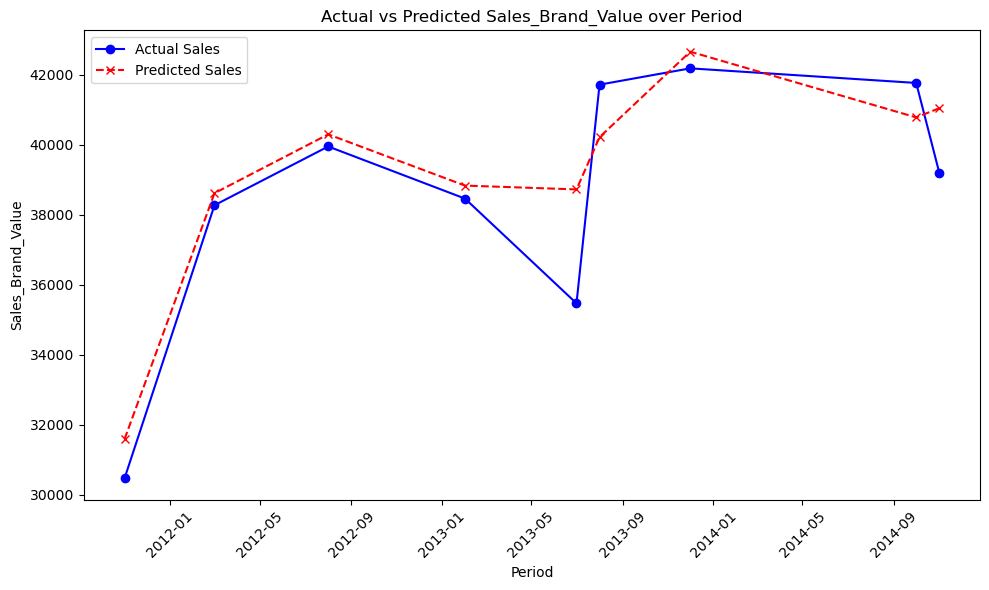

In [98]:

brand_lasso_plot_df = pd.DataFrame({
    'Period': brand_y_test.index,  # Using the index of y_test for the period
    'Actual_Sales': brand_y_test,  # Actual sales values from the test set
    'Predicted_Sales': brand_y_pred  # Predicted sales values
})

# Sort the DataFrame by 'Period' to ensure the x-axis is in chronological order
brand_lasso_plot_df = brand_lasso_plot_df.sort_index()

# Plotting the actual vs predicted sales values
plt.figure(figsize=(10, 6))
plt.plot(brand_lasso_plot_df['Period'], brand_lasso_plot_df['Actual_Sales'], label='Actual Sales', color='blue', linestyle='-', marker='o')
plt.plot(brand_lasso_plot_df['Period'], brand_lasso_plot_df['Predicted_Sales'], label='Predicted Sales', color='red', linestyle='--', marker='x')

# Adding titles and labels
plt.title('Actual vs Predicted Sales_Brand_Value over Period')
plt.xlabel('Period')
plt.ylabel('Sales_Brand_Value')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Contribution Chart for Brand Model


Contribution Chart:
           Feature  Average Feature Value  Coefficient  Total Contribution  \
0  Brand_Avg_Price             358.010907   165.373945        59205.675834   
2   Brand_FB_Likes          119525.444444     0.060668         7251.387496   
1   Brand_Shipment          134027.827333     0.033605         4504.058417   
4             July               0.111111 -2765.546580          307.282953   
3            March               0.111111  2691.503511          299.055946   
5         December               0.111111  1764.756079          196.084009   

   Percentage Contribution  
0                82.501047  
2                10.104556  
1                 6.276249  
4                 0.428188  
3                 0.416724  
5                 0.273236  


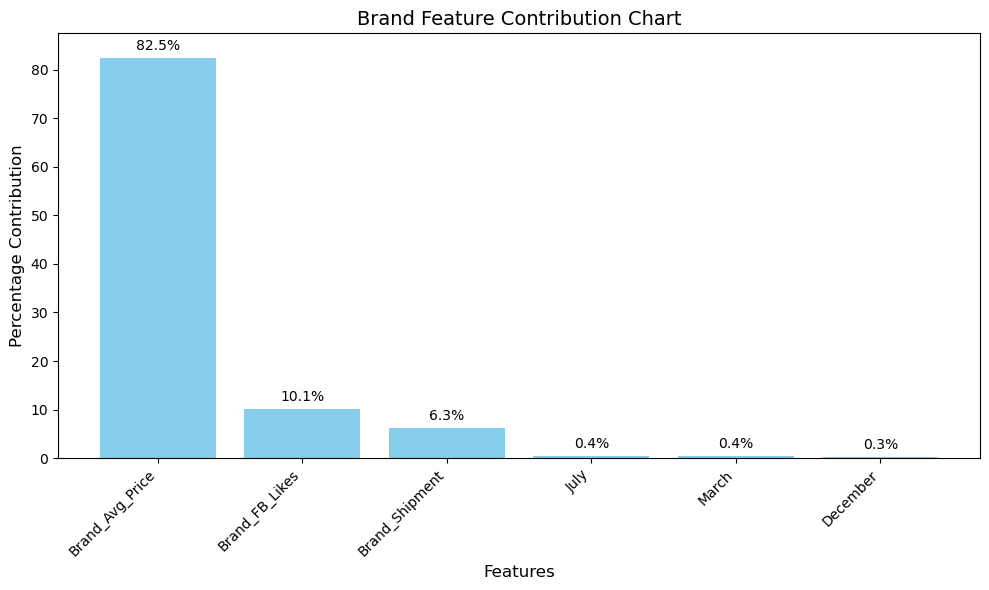

In [99]:
# Define a dictionary for renaming columns
column_mapping = {
    'Brand_Avg_Price_per_SU': 'Brand_Avg_Price',
    'Brand_Social_FB_Ad_spend_likes': 'Brand_FB_Likes',
    'Brand_Shipment_SU':'Brand_Shipment',
    'Month_7':'July',
    'Month_3':'March',
    'Month_12':'December',
    'Feature': 'Renamed_Feature',
}

# Rename the columns in the DataFrame
brand_X_test_renamed = brand_X_test.rename(columns=column_mapping)

# Update the feature names for contribution chart
renamed_features = [column_mapping.get(feature, feature) for feature in features]
# Calculate the mean of each feature in the test set
feature_means = brand_X_test.mean()

# Calculate contributions as mean(feature) * coefficient
contributions = feature_means * brand_lasso_model.coef_
contributions = np.abs(contributions)
# Normalize contributions to percentage
total_contributions = contributions.sum()
percentage_contributions = (contributions / total_contributions) * 100


# Create a DataFrame for the contribution chart with renamed features
contribution_chart = pd.DataFrame({
    'Feature': renamed_features,  
    'Average Feature Value': feature_means.values,
    'Coefficient': brand_lasso_model.coef_,
    'Total Contribution': contributions.values,
    'Percentage Contribution': percentage_contributions.values
}).sort_values(by='Percentage Contribution', ascending=False)

# Display the contribution chart
print("\nContribution Chart:")
print(contribution_chart)

import matplotlib.pyplot as plt

# Plot the contribution chart
plt.figure(figsize=(10, 6))
bars = plt.bar(
    contribution_chart['Feature'], 
    contribution_chart['Percentage Contribution'], 
    color='skyblue'
)

# Add percentage values on top of the bars
for bar, percentage in zip(bars, contribution_chart['Percentage Contribution']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        bar.get_height() + 1,              # Y-coordinate (slightly above the bar)
        f"{percentage:.1f}%",             # Format as percentage with 1 decimal place
        ha='center', va='bottom', fontsize=10  # Center-align text
    )

# Customize chart aesthetics
plt.xlabel('Features', fontsize=12)
plt.ylabel('Percentage Contribution', fontsize=12)
plt.title('Brand Feature Contribution Chart', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability
plt.ylim(0, contribution_chart['Percentage Contribution'].max() + 5)  # Add extra space for text

# Show the plot
plt.tight_layout()
plt.show()



## V1 - Ridge Regression Model (MAPE = 4.48%, R² = 0.798)
Since the Ridge Regression Model has the least MAPE and highest R² for V1, this model has been selected as the best model

### Actual VS Predicted Sales_V1_Value

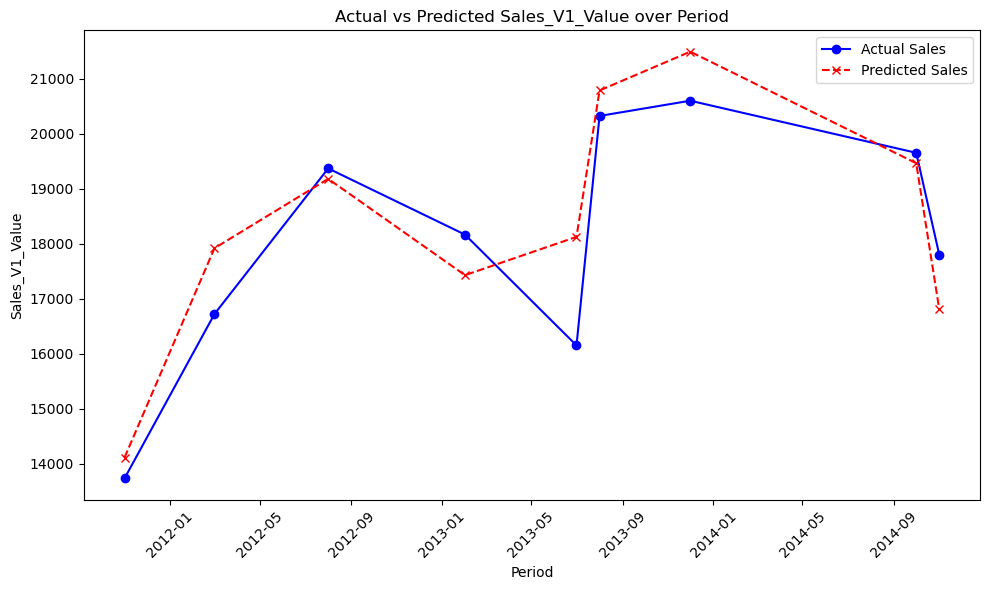

In [100]:

v1_ridge_plot_df = pd.DataFrame({
    'Period': v1_y_test.index,  # Using the index of y_test for the period
    'Actual_Sales': v1_y_test,  # Actual sales values from the test set
    'Predicted_Sales': v1_y_pred  # Predicted sales values
})

# Sort the DataFrame by 'Period' to ensure the x-axis is in chronological order
v1_ridge_plot_df = v1_ridge_plot_df.sort_index()

# Plotting the actual vs predicted sales values
plt.figure(figsize=(10, 6))
plt.plot(v1_ridge_plot_df['Period'], v1_ridge_plot_df['Actual_Sales'], label='Actual Sales', color='blue', linestyle='-', marker='o')
plt.plot(v1_ridge_plot_df['Period'], v1_ridge_plot_df['Predicted_Sales'], label='Predicted Sales', color='red', linestyle='--', marker='x')

# Adding titles and labels
plt.title('Actual vs Predicted Sales_V1_Value over Period')
plt.xlabel('Period')
plt.ylabel('Sales_V1_Value')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Contribution Chart for V1 Model

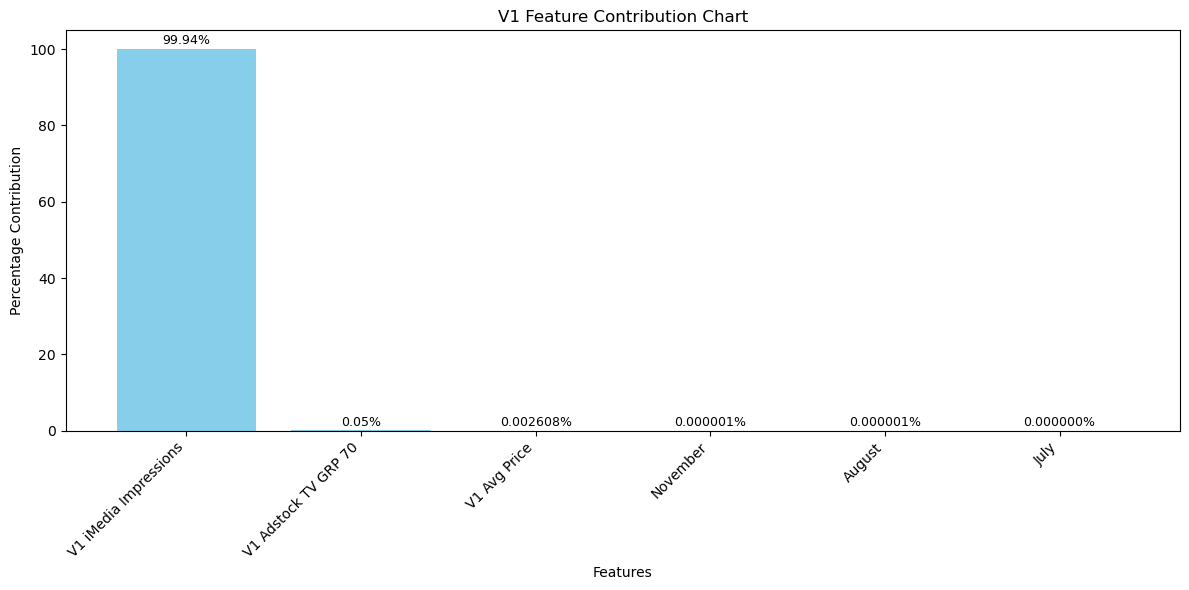

In [106]:
independent_vars = [
    'V1_Avg_Price_per_SU',
    'V1_iMedia_Imp_Total',
    'V1_TV_F30_39_Total_GRP',
    'Month_7', 'Month_8','Month_11'
]
dependent_vars = 'Sales_V1_Value'

# Drop rows with missing values in relevant columns
sales_media_merged = sales_media_merged.dropna(subset=independent_vars + [dependent_var])

# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7
sales_media_merged['Adstock_V1_TV_F30_39_Total_GRP'] = calculate_adstock(sales_media_merged['V1_TV_F30_39_Total_GRP'], decay_factor)

# Update independent variables to use the adstocked feature
independent_vars.remove('V1_TV_F30_39_Total_GRP')
independent_vars.append('Adstock_V1_TV_F30_39_Total_GRP')

# Prepare features (X) and target variable (y)
X = sales_media_merged[independent_vars]
y = sales_media_merged[dependent_var]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Ridge Regression model
ridge_model = Ridge(alpha=1.0)  
ridge_model.fit(X_train, y_train)
# Define a mapping for feature names
feature_mapping = {
    'V1_iMedia_Imp_Total': 'V1 iMedia Impressions',
    'Adstock_V1_TV_F30_39_Total_GRP': 'V1 Adstock TV GRP 70',
    'Month_8':'August',
    'Month_7':'July',
    'Month_11':'November',
    'V1_Avg_Price_per_SU':'V1 Avg Price'
}

# Map the feature names
renamed_features = [feature_mapping.get(col, col) for col in X.columns]

# Sort contributions by absolute value of coefficients
coefficients = np.abs(ridge_model.coef_.flatten())  # Take absolute coefficients
averages = X.mean().values
mul_values = coefficients * averages

# Compute total and contributions
tot = np.sum(mul_values)
contributions = (mul_values * 100) / tot

# Combine feature names, contributions, and sort
contribution_data = pd.DataFrame({
    'Feature': renamed_features,
    'Contribution': contributions
}).sort_values(by='Contribution', ascending=False)

# Plot histogram with percentage numbers
plt.figure(figsize=(12, 6))

# Define the bars
bars = plt.bar(contribution_data['Feature'], contribution_data['Contribution'], color='skyblue')

# Set labels and title
plt.xlabel('Features')
plt.ylabel('Percentage Contribution')
plt.title('V1 Feature Contribution Chart')
plt.xticks(rotation=45, ha='right')

# Add percentage values on the bars with varying decimal places
for bar, contribution in zip(bars, contribution_data['Contribution']):
    # Increase decimal places for very small contributions
    if contribution < 0.01:
        text = f'{contribution:.6f}%'  # 6 decimal places for small values
    else:
        text = f'{contribution:.2f}%'  # Standard 2 decimal places
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center of the bar
        bar.get_height() + 0.5,            # Slightly above the bar
        text,                              # Display text
        ha='center',                       # Center alignment
        va='bottom',                       # Bottom alignment
        fontsize=9                         # Font size
    )

# Final layout adjustments and show plot
plt.tight_layout()
plt.show()


## V2 - Linear Regression Model (MAPE = 2.49%, R² = 0.776)
Since the Linear Regression Model has the least MAPE and highest R² for V2, this model has been selected as the best model

### Actual VS Predicted Sales_V2_Value

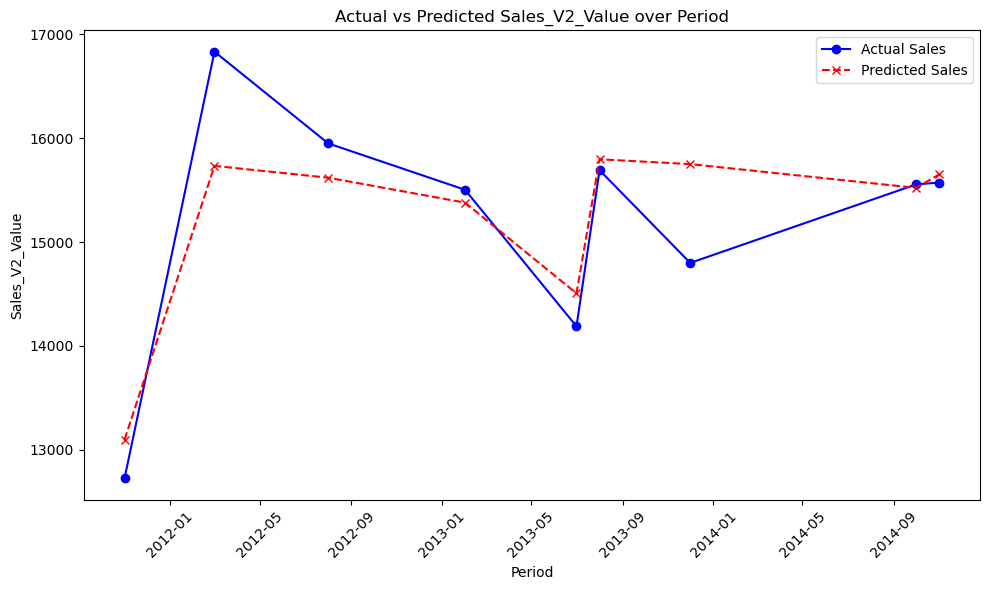

In [102]:

v2_plot_df = pd.DataFrame({
    'Period': v2_y_test.index,  # Using the index of y_test for the period
    'Actual_Sales': v2_y_test,  # Actual sales values from the test set
    'Predicted_Sales': v2_y_pred  # Predicted sales values
})

# Sort the DataFrame by 'Period' to ensure the x-axis is in chronological order
v2_plot_df = v2_plot_df.sort_index()

# Plotting the actual vs predicted sales values
plt.figure(figsize=(10, 6))
plt.plot(v2_plot_df['Period'], v2_plot_df['Actual_Sales'], label='Actual Sales', color='blue', linestyle='-', marker='o')
plt.plot(v2_plot_df['Period'], v2_plot_df['Predicted_Sales'], label='Predicted Sales', color='red', linestyle='--', marker='x')

# Adding titles and labels
plt.title('Actual vs Predicted Sales_V2_Value over Period')
plt.xlabel('Period')
plt.ylabel('Sales_V2_Value')
plt.legend()

# Display the plot
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


### Contribution Chart for V2 Model


Feature Contribution Chart:
                                             Feature  Contribution  \
V1_iMedia_Imp_Total              V1 iMedia Total Imp  3.547865e+08   
V2_Avg_Price_per_SU                     V2 Avg Price  2.423862e+05   
Adstock_V1_TV_F30_39_Total_GRP  V1 Adstock TV GRP 70  2.267499e+05   
V1_TV_Spends_Total_USM            V1 TV Spends Total  1.799454e+03   
Month_7                                         July  3.934699e+01   
Month_1                                      January  2.726784e+01   
Month_3                                        March  1.588044e+01   

                                Percentage Contribution  
V1_iMedia_Imp_Total                           99.867415  
V2_Avg_Price_per_SU                            0.068228  
Adstock_V1_TV_F30_39_Total_GRP                 0.063827  
V1_TV_Spends_Total_USM                         0.000507  
Month_7                                        0.000011  
Month_1                                        0.000008  
Mont

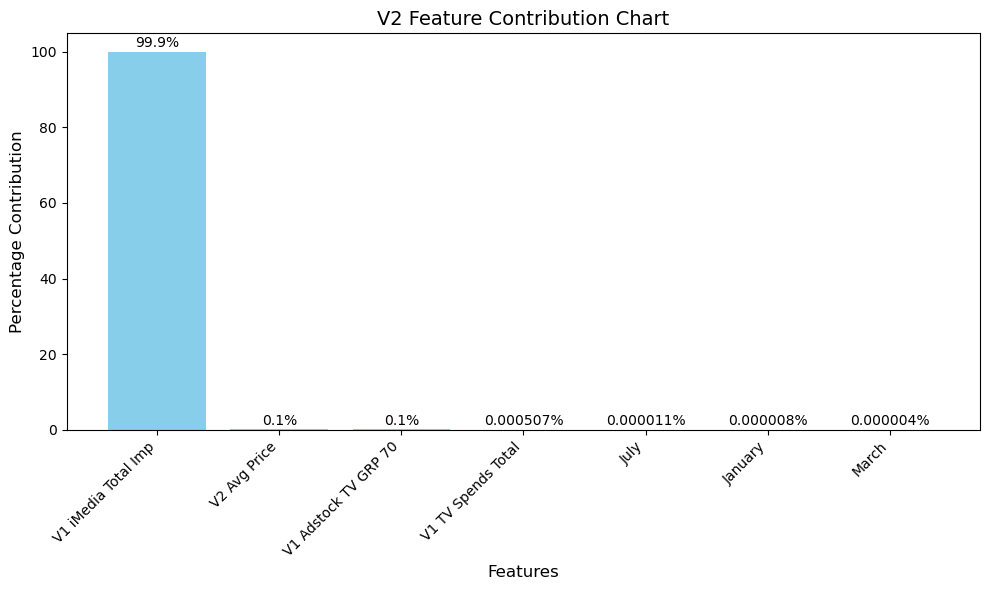

In [107]:
# Calculate the contribution of each feature
contributions = abs(v2_X.mean() * v2_coefficients['Coefficient'])
total_contribution = contributions.sum()

# Placeholder for renaming features
feature_mapping = {
    'V1_iMedia_Imp_Total': 'V1 iMedia Total Imp',
    'V2_Avg_Price_per_SU': 'V2 Avg Price',
    'Adstock_V1_TV_F30_39_Total_GRP':'V1 Adstock TV GRP 70',
    'V1_TV_Spends_Total_USM':'V1 TV Spends Total',
    'Month_7':'July',
    'Month_1':'January',
    'Month_3':'March'
    
}

# Map feature names to new names
renamed_features = [feature_mapping.get(feature, feature) for feature in v2_X.columns]

# Create a DataFrame for contributions
contribution_chart = pd.DataFrame({
    'Feature': renamed_features,  
    'Contribution': contributions,
    'Percentage Contribution': (contributions / total_contribution) * 100
}).sort_values(by='Percentage Contribution', ascending=False)

# Display the contribution chart
print("\nFeature Contribution Chart:")
print(contribution_chart)

# Plot the contribution chart
plt.figure(figsize=(10, 6))
bars = plt.bar(
    contribution_chart['Feature'], 
    contribution_chart['Percentage Contribution'], 
    color='skyblue'
)

# Add percentage values on top of the bars with dynamic precision
for bar, percentage in zip(bars, contribution_chart['Percentage Contribution']):
    # Increase decimal places for very small contributions
    if percentage < 0.01:
        text = f"{percentage:.6f}%"  # 6 decimal places for small values
    else:
        text = f"{percentage:.1f}%"  # Standard 1 decimal place
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        bar.get_height() + 0.5,            # Y-coordinate (slightly above the bar)
        text,                              # Display percentage text
        ha='center', va='bottom', fontsize=10  # Center-align text
    )

# Customize chart aesthetics
plt.xlabel('Features', fontsize=12)
plt.ylabel('Percentage Contribution', fontsize=12)
plt.title('V2 Feature Contribution Chart', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability
plt.ylim(0, contribution_chart['Percentage Contribution'].max() + 5)  # Add extra space for text

# Show the plot
plt.tight_layout()
plt.show()


## V3 - Lasso Regression Model (MAPE = 4.84%, R² = 0.881)
Since the Lasso Regression Model has the least MAPE and highest R² for V3, this model has been selected as the best model

### Actual VS Predicted Sales_V3_Value

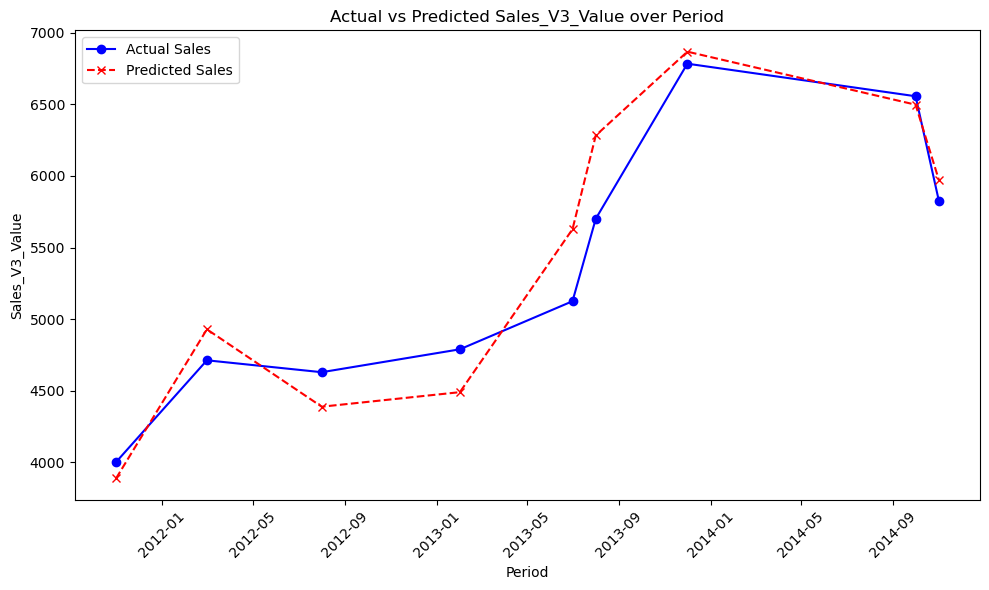

In [104]:

v3_lasso_plot_df = pd.DataFrame({
    'Period': v3_y_test.index,  # Using the index of y_test for the period
    'Actual_Sales': v3_y_test,  # Actual sales values from the test set
    'Predicted_Sales': v3_y_pred  # Predicted sales values
})

# Sort the DataFrame by 'Period' to ensure the x-axis is in chronological order
v3_lasso_plot_df = v3_lasso_plot_df.sort_index()

# Plotting the actual vs predicted sales values
plt.figure(figsize=(10, 6))
plt.plot(v3_lasso_plot_df['Period'], v3_lasso_plot_df['Actual_Sales'], label='Actual Sales', color='blue', linestyle='-', marker='o')
plt.plot(v3_lasso_plot_df['Period'], v3_lasso_plot_df['Predicted_Sales'], label='Predicted Sales', color='red', linestyle='--', marker='x')

# Adding titles and labels
plt.title('Actual vs Predicted Sales_V3_Value over Period')
plt.xlabel('Period')
plt.ylabel('Sales_V3_Value')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Contribution Chart for V3 Model


Feature Contribution Chart:
                                                        Feature  Contribution  \
V1_iMedia_Imp_Total                 V1 iMedia Total Impressions  1.635409e+09   
V3_Shipment_SU                                      V3 Shipment  5.106941e+06   
Adstock_V1_TV_F30_39_Total_GRP             V1 Adstock TV GRP 70  4.094426e+05   
V1_TV_Spends_Total_USM                       V1 TV Total Spends  1.059722e+05   
V1_TV_Spends_ISP_USM                           V1 TV ISP Spends  1.016388e+05   
V3_Avg_Price_per_SU                                V3 Avg Price  9.450957e+04   
V1_Avg_Price_per_SU                                V1 Avg Price  5.948105e+04   
V1_iMedia_Spends_Total_USM_Digital       V1 iMedia Total Spends  9.156955e+03   
Month_1                                                 January  1.664715e+01   
Month_6                                                    June  7.533685e+00   
Month_8                                                  August  7.114491e+00   

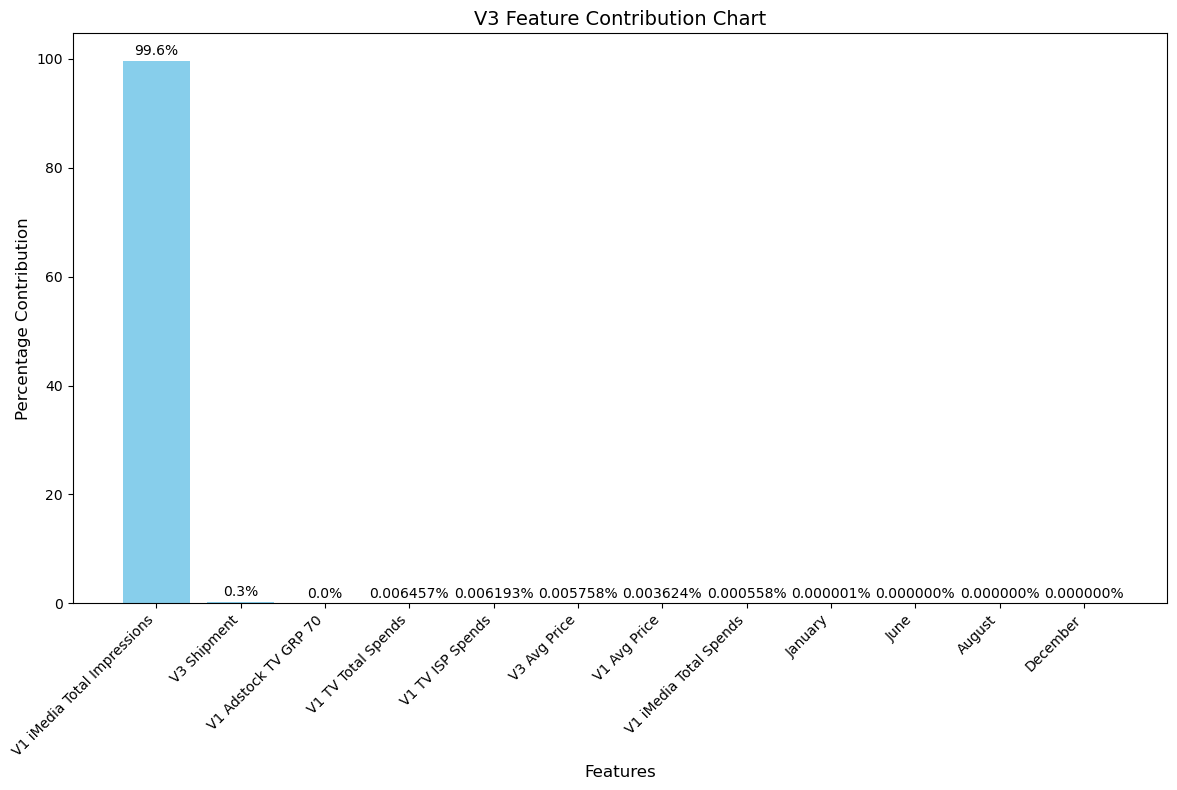

In [108]:
# Calculate the absolute contributions
contributions = abs(v3_X.mean() * v3_coefficients['Coefficient'])
total_contribution = contributions.sum()


feature_mapping = {
    'V1_iMedia_Imp_Total': 'V1 iMedia Total Impressions',
    'V3_Shipment_SU': 'V3 Shipment',
    'Adstock_V1_TV_F30_39_Total_GRP': 'V1 Adstock TV GRP 70',
    'V1_TV_Spends_Total_USM': 'V1 TV Total Spends',
    'V3_Avg_Price_per_SU': 'V3 Avg Price',
    'Month_1': 'January',
    'Month_6': 'June',
    'Month_8': 'August',
    'Month_12': 'December',
    'V1_iMedia_Spends_Total_USM_Digital': 'V1 iMedia Total Spends',
    'V1_Avg_Price_per_SU': 'V1 Avg Price',
    'V1_TV_Spends_ISP_USM': 'V1 TV ISP Spends'
}


# Map feature names to new names
renamed_features = [feature_mapping.get(feature, feature) for feature in v3_X.columns]

# Create a DataFrame for contributions
contribution_chart = pd.DataFrame({
    'Feature': renamed_features,  
    'Contribution': contributions,
    'Percentage Contribution': (contributions / total_contribution) * 100
}).sort_values(by='Percentage Contribution', ascending=False)

# Display the contribution chart
print("\nFeature Contribution Chart:")
print(contribution_chart)

# Plot the contribution chart
plt.figure(figsize=(12, 8))
bars = plt.bar(
    contribution_chart['Feature'], 
    contribution_chart['Percentage Contribution'], 
    color='skyblue'
)

# Add percentage values on top of the bars with dynamic precision
for bar, percentage in zip(bars, contribution_chart['Percentage Contribution']):
    # Increase decimal places for very small contributions
    if percentage < 0.01:
        text = f"{percentage:.6f}%"  # 6 decimal places for small values
    else:
        text = f"{percentage:.1f}%"  # Standard 1 decimal place
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        bar.get_height() + 0.5,            # Y-coordinate (slightly above the bar)
        text,                              # Display percentage text
        ha='center', va='bottom', fontsize=10  # Center-align text
    )

# Customize chart aesthetics
plt.xlabel('Features', fontsize=12)
plt.ylabel('Percentage Contribution', fontsize=12)
plt.title('V3 Feature Contribution Chart', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability
plt.ylim(0, contribution_chart['Percentage Contribution'].max() + 5)  # Add extra space for text

# Show the plot
plt.tight_layout()
plt.show()
